In [1]:
#import neccessary packages
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
from IPython.display import display
pd.set_option('display.max_columns', None,'display.max_rows', None)
import pyutilib.services
from importlib import reload
import matplotlib.pyplot as plt
import numpy as np
Module_path = '../Modules'  # specify path to modules folder where baf, fopt, and are located, 
                            # change as needed for environment
import sys
sys.path.insert(0,Module_path)
import base_functions as baf
import Bolt_opt_functions as fopt
import analysis_functions as anf

# Model Inspection

Models can be inspected independent of the optimization prcedure:

In [2]:
lowKModel='smallModel_lowK.pkl'
highKModel='smallModel_highK.pkl'
model_inspection = lowKModel

In [11]:
S_active, active_reactions, metabolites, Keq = baf.load_model('Saved_models/'+model_inspection)

includes keq


# Compose base simulation

Options can be selected to impose changes on how the metabolites behave in the optimization. The metabolites in the model are set to be variable and an optimal cocnentration will be found or fixed and the concentration will remain constant throughout the simulation.

- **'remove_metabolites'** : metabolites to remove from the model.

- **'initial_conditions'** : the initial concentration values for metabolites in the model. 

- **'boundary_conditions'** : the boundary conditions for the fixed metabolites used for product metabolties ued in biomass objective functions and metabolite fixed to the envionment condition values. 


The concentrations of metabolites in the system are required to be in steady state for the optimization to be sucessful. Whether or not the metabolite concentration is included in the determination of the model steady state can be changed.

- **'implicit_metabolites'** : whether to calculate the steady state of the metabolite but not include the metabolite in the system steady state calculation.

- **'explicit_metabolites'** : whether to calculate the steady state for the metabolite and include the metabolite in the system steady state calculation. Fixed metabolites are required to have their steady states explicitly included in the system calculation.



The metabolite concentration values of the variable metabolites are optimised to be within an upper and lower bound. 

- **'raise_bounds'** : a list of names for metabolites whose upper concentration bound is to be raised to a maximum to remove any constriction on the upper concentration.  

- **'specify_upper_bound'** : the upper bound on the variable metabolite concentrations in the model can be set to constrain the solution.

- **'specify_lower_bound'** : the lower bound on the variable metabolite concentrations in the model can be set to constrain the solution.



Metabolites are in ggeneral both produced or consumed through different reactions in the metabolism. However, throughouth the whol emetabolism a metabolite will either be produced or consumed as the net flux of a metabolite will be the sum of the individual reaction fluxes that the metabolite is involved in. 

- **'net_flux'** : if the direction for the net flux for a particular metabolite it known (i.e the metabolite is known to be produced or consumed). The metabolite is associated with a value +1 for overall production, -1 for overall consumption, and 0 for no setting.

A subset of the metabolites in the model may be designated as redox metabolites if they are involved in reduction-oxidation reactions. These metabolites occur in pairs (the reduced and the oxidised forms) and are often described as having relative concentrations fixed as a ratio. This ratio value depends on the cell species and the state of the cell. Therefore scanning over a range of ratio values can be used to investigate different cell states. 

- **'redox_pairs'** : given a pair of metabolites names, if both species are variable then fix the metabolite to the input concentration value. The second metabolite renames variable. If one of the pair or both species are fixed then do nothing. 
- **'redox_ratios'** : given a pair of metabolites fix the concentratio ratio between them. Both species are fixed with the initial concentration of the first metabolite set to ratio*second metabolite.


Reactions in the model can be altered to incorporate more information into the optimization process. 


- **'remove_reactions'** : reactions to remove from the model.

- **'flux_direction'** : if the direction of the optimized flux is known a priori then the direction can be fixed. The direction can be set to -1, 0, 1, for reverse, no setting, and forward respectively. 

- **'allow_regulation'** : if a reaction is known to be unregulated then the regulation can be removed. The regulation can be set to 1 for including the regulation or 0 for removing all regulaiton of the reaction. 

The optimizing problem requires a list of objective reactions that are included within the model. The metabolite concentrations, regulation, and reaction fluxes will be chosen in order to maximise the flux through the objective reactions. The importance weighting between members of a set of objective reactions is given through the 'obj_coefs' as the flux through a higher coefficient reaction will be given greater improtance in the overall model objective value. A secondary objective can be provided where the flux through the secondary objective reactions will be maximised while remaining within a tolerance of the maximised primary objective value. For the secondary objective to be optimized the primary objective must have origionally converged sucessfully. 

- **'obj_coefs'** : if the input model does not contain the objective coefficients (in the metabolites dataframe) then provide them here. This will override the model coefficients.

- **'secondary_objective'** : use a supplied list of secondary objective coefficients, not the ones in the dataframe as for the primary objective. The secondary objective 

- **'primary_obj_tolerance'** : bound for loss in objective value while maximising the flux through secondary pathways. np.sum(y_ini*primary_obj_coefs) - primary_obj_tolerance


To switch off an experiment option the user can remove the entry from the simulation dictionary. In the event that the option is required for the optimization to proceed then a default parameter will be used. 

In [3]:
base_simulation_list=[]
simulation_test={
    'name':'reducedRTModel',
    'model':RT_reduced_model,
    'model_output':'output_reduced_RTModel_',
#     'secondary_objective': {'protein_syn':1, 'rna_syn':1,'dna_syn':1}, # dictionary 'reaction name': val where val \in reals
#     'primary_obj_tolerance': 100, # positive real, default 100
    'initial_conditions':{}, # dictionary'metabolite name': val where val \in positive reals
    'boundary_conditions':{}, # dictionary'metabolite name': val where val \in positive reals
#     'obj_coefs':{}, # dictionary'reaction name': val where val \in reals; if this is defined 
#     'remove_metabolites':['SUCROSE:ENVIRONMENT'], # list'metabolite name'
#     'remove_reactions':['RXN-1461'], # list 'reaction name'
    'implicit_metabolites':[], # list 'metabolite name', default for Fixed species
    'explicit_metabolites':[], # list 'metabolite name', default for Variable species
#     'redox_pairs':[
#        ['NADPH:CYTOSOL' ,'NADP+:CYTOSOL'],
#        ['A REDUCED THIOREDOXIN:CYTOSOL', 'AN OXIDIZED THIOREDOXIN:CYTOSOL'],
#        ['UBIQUINOL:MITOCHONDRIAL_MEM','UBIQUINONE:MITOCHONDRIAL_MEM'],
#         ['OXYGEN:CYTOSOL' ,'GMP:CYTOSOL']
#     ], # list of pairs of metabolite names [[a,b],[c,d]] if both variable then fix first name (i.e a and c)
#     'redox_ratios':[{'names':['NADH:CYTOSOL','NAD+:CYTOSOL'],'ratio':1.2},
#                    {'names':['NADH:MITOCHONDRIA','NAD+:MITOCHONDRIA'],'ratio':1.2}], # list of dictionaries containing a list of pair of metabolites and the ratio
#     'raise_bounds':['PROTEIN','RNA','DNA'],
#     'specify_upper_bound':{'ALPHA-D-GLUCOSE:CYTOSOL':1e-3}, # default 1e-3
#     'specify_lower_bound':{'ALPHA-D-GLUCOSE:CYTOSOL':1e-120}, # default 1e-120
    'net_flux':{}, # dictionary 'metabolite name': val where val \in {1, 0, -1}, default 0 
    'flux_direction':{}, # dictionary 'reaction_name': val where val \in {1, 0, -1}, default 0 
    'allow_regulation':{} # dictionary 'reaction_name': val where val \in {1, 0}, default 1 
}
base_simulation_list.append(simulation_test)

# Set optimization configuration conditions

In addition to the different simulation experiments for the optimization process, a set of control parameters are required to be passed to the optimization suite. These control parameters alter how the swarm hyperparameter behaves and sets the solver conditions.   

- **'model_file_dir'** : string directory name for the model input files
- **'solution_file_dir'** : string directory name in which to save the simulation solution files
- **'parallel_solve'** : boolean switch for whether to use parallel pool for solving multiple optimization problems in paralllel on the CPU. (default True)
- **'worker_count'** : the number of parallel pool workers distributed over the CPU cores. The value is only used if 'parallel_solve' is True.

- **'deltaConcentration'** : double or list of doubles for the perturbation strength of 
    initial concentrations about the model input for each swarm agents (default 0)
- **'deltaFlux'** : double or list of doubles for the perturbation strength of 
    initial flux values about the model input for each swarm agents (default 0)
- **'mb'** : the relaxation hyperparameter for the optimization constraints (default 100)
- **'zeta'** : scaling parameter for the initial flux values before the optimization solve (default 0.1)
- **'swarm_size'** : number of agents within a swarm (default: 2) 
- **'linear_solver'** : a string for a specific desired solver name (default ma27)
- **'max_cpu_time'** : the maximum number of cpu seconds for a single solve attempt after which the solve has considered to have stalled (default: 800000)
- **'max_iter'** : the maximum number of solver iterations before terminating with a failed convergence (default: 10000)
- **'acceptable_tol'** : acceptable convergence tolerance within which a non-converged solution can be considered accurate enough (default: 1e-6)
- **'solver_tol'** : convergence tolerance within which an optimization is considered converged (default: 1e-7)
- **'hsllib'** : a string file path for the .dylib file of the Haswell Subroutine Library. This option should be set if required for the specific IPOPT solver routine if using the HSL solvers and the environment variable is not already set.
    
For the list of control configurations ('delta_concentration', 'delta_flux', 'mb', 'zeta') the simulation experiment set will be duplicated for each value pair in order to provide hyperparameter scanning capabilities. 

In [4]:
control_dictionary={
    'model_file_dir':'Saved_models', # default 'Saved_models'
    'solution_file_dir':'Saved_solutions', # default 'Saved_solutions'
    'parallel_solve':False,# boolean True/False
    'worker_count': 1,  # natural number, 0 or remove for cpu_count
    'delta_concentration':[0], # list positive reals
    'delta_flux':[0], # list positive reals
    'mb':[100], # list positive naturals
    'zeta':[0.1], # list positive reals
    'swarm_size':1, # naturals, default is 2
    'linear_solver': 'ma57',
    'max_cpu_time':800000,
    'max_iter':10000,
    'acceptable_tol':1e-3,
    'solver_tol':1e-4
#     'hsllib':'/opt/coinhsl/lib/libcoinhsl.dylib'
}

# Form simulation experiments

Different experiments may be performed by scanning over changes in simulation configurations. The scans duplicate the set of base simulation for each scanned condition. Impose experiment scans options:



- **ScanOverInitialCondition(simulation_list,chemical_name,value_list)** : prove a chemical name from the model and set the initial concentration of the chemical to each value in a list. 

- **ScanOverBoundaryCondition(simulation_list,chemical_name,value_list)** : prove a chemical name from the model and set the fixed boundary concentration of the chemical to each value in a list.  

- **ScanOverRedoxRatios(simulation_list,redox_pair_list, ratio_list)** :  prove a list containg a pair of chemical names which are memebers of a redox pair couple. The ratio between the two concentrations is set from ratio values in a provided list. 


In [5]:

simulationList = base_simulation_list

# change gluc:fruc ratios
# metabolite_name = 'x1_e:ENVIRONMENT'

# conditions=[1e-10,1e-9,1e-8,1e-7,1e-6,1e-5,1e-4]
# simulationList = baf.ScanOverInitialCondition(simulationList,metabolite_name,conditions)
# simulationList = baf.ScanOverRedoxRatios(simulationList,['A REDUCED THIOREDOXIN:CYTOSOL', 'AN OXIDIZED THIOREDOXIN:CYTOSOL'],nh3Conditions)


# Run the actual optimization swarm

In [8]:
reload(baf)
reload(fopt)


print()
print("Solving "+str(len(base_simulation_list))+" base simulations.")
print("Solving "+str(len(simulationList))+" total simulations.")
        
bestSimulations = baf.RunSwarmSimulation(simulationList,control_dictionary)
display(bestSimulations)



Solving 1 base simulations.
Solving 1 total simulations.
run serial
Initialize using simulated annealing
Use least squares to initialise log concentrations
233.73812740425356
-235.2674047524599
347.5464441772303
200.9515195638951
Use least suares solution and projection of beta to seed annealing
Dual annealing status : ['Maximum number of iteration reached']
Number of Function evaluations : 3173191
Annealing return function value (a.k.a number misaligned signs) : 187
Percentage sign alignment : 76 
n_ini:  [-2.55157629e+02 -2.06196799e+01 -1.55744361e+02 -2.70932781e+01
 -6.76690922e+01  8.53395466e+00 -1.69107874e+02 -1.35892100e+02
 -1.00189504e+02 -1.94985137e+01 -1.32612444e+02 -2.36158798e+02
 -2.09226276e+02 -2.10753874e+01 -1.51056802e+02 -9.07891228e-01
 -2.27545941e+02 -2.38350250e+01 -8.76529123e+01 -2.17252018e+02
 -2.48700463e+02 -8.05906121e+01 -7.31827462e+01 -1.15330950e+02
 -1.10889594e+02 -1.11738645e+00 -2.60201816e+01 -1.00527516e+02
 -7.76361664e+01 -2.43131650e+02

here 2
Ipopt 3.14.10: max_iter=10000
max_cpu_time=800000
tol=0.0001
acceptable_tol=0.001
linear_solver=ma57


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.10, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:  1021367
Number of nonzeros in inequality constraint Jacobian.:    13328
Number of nonzeros in Lagrangian Hessian.............:     2938

Total number of variables............................:     7351
                     variables with only lower bounds:        0
                variables with lower and upper bounds:     1455
                     variables with only upper bounds:

  86  1.1587887e+00 3.49e+03 3.61e+00  -1.0 5.71e+04    -  5.41e-04 4.19e-04h  1
  87  1.1582816e+00 3.48e+03 3.78e+00  -1.0 6.37e+04    -  5.06e-04 4.38e-04h  1
  88  1.1580504e+00 3.48e+03 3.37e+01  -1.0 6.50e+04    -  9.51e-04 2.00e-04h  1
  89r 1.1580504e+00 3.48e+03 9.99e+02   3.3 0.00e+00    -  0.00e+00 5.00e-07R  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  90r 1.1730531e+00 3.45e+03 9.99e+02   3.3 9.50e+05    -  2.56e-04 5.69e-05f  1
  91r 1.1815083e+00 3.30e+03 9.99e+02   1.9 2.10e+05    -  6.00e-04 2.49e-04f  1
  92r 1.2136603e+00 2.90e+03 9.98e+02   1.9 1.90e+05    -  4.55e-04 7.70e-04f  1
  93r 1.2298401e+00 2.73e+03 9.97e+02   1.9 1.75e+05    -  7.50e-04 3.94e-04f  1
  94  1.2298152e+00 2.73e+03 1.51e+02  -1.0 5.94e+04    -  6.87e-05 2.02e-05h  1
  95r 1.2298152e+00 2.73e+03 9.99e+02   3.3 0.00e+00    -  0.00e+00 1.07e-07R  2
  96r 1.2414117e+00 2.70e+03 2.72e+03   3.3 1.58e+06    -  2.70e-04 5.79e-05f  1
  97r 1.2551185e+00 2.52e+03

 184r 1.2963462e+00 5.97e+02 3.37e+04   1.4 3.08e+00   2.0 9.09e-01 3.28e-01f  1
 185r 1.2770277e+00 5.97e+02 2.48e+04   1.4 1.09e+00   2.4 1.00e+00 5.44e-01f  1
 186r 1.2615725e+00 5.97e+02 2.66e+02   1.4 4.02e-01   2.8 1.00e+00 1.00e+00f  1
 187r 1.2307539e+00 5.97e+02 2.07e+04  -0.0 1.39e+00   2.3 7.23e-01 1.94e-01f  1
 188r 1.1807038e+00 5.97e+02 1.59e+04  -0.0 5.03e+00   1.9 2.57e-01 2.32e-01f  1
 189r 1.1766834e+00 5.97e+02 2.19e+04  -0.0 1.33e+02   1.4 1.24e-01 1.00e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 190r 1.1739362e+00 5.97e+02 3.73e+04  -0.0 4.09e+00   1.8 2.59e-01 1.42e-02f  1
 191r 1.1070422e+00 5.97e+02 3.07e+04  -0.0 1.23e+01   1.3 2.74e-02 1.56e-01f  1
 192r 1.1059497e+00 5.97e+02 3.05e+04  -0.0 4.67e+00   1.8 1.20e-01 5.35e-03f  1
 193r 1.0843927e+00 5.97e+02 2.91e+04  -0.0 2.40e+01   1.3 6.78e-03 4.50e-02f  1
 194r 1.0459236e+00 5.96e+02 2.40e+04  -0.0 5.28e+00   1.7 4.03e-02 1.76e-01f  1
 195r 1.0037539e+00 5.96e+02

 322r 1.5080920e-01 5.95e+02 1.88e+04  -0.0 1.97e+01   1.1 1.22e-01 1.53e-01f  1
 323r 1.4562645e-01 5.95e+02 3.10e+04  -0.0 6.57e+00   1.6 4.61e-01 9.59e-02f  1
 324r 1.4256617e-01 5.95e+02 2.98e+04  -0.0 2.50e+01   1.1 1.16e-02 2.07e-02f  1
 325r 1.3355546e-01 5.95e+02 2.16e+04  -0.0 7.69e+00   1.5 7.55e-02 1.54e-01f  1
 326r 1.3283027e-01 5.95e+02 5.06e+04  -0.0 4.25e-01   2.9 8.30e-01 1.77e-01f  1
 327r 1.3029040e-01 5.95e+02 2.84e+04  -0.0 9.75e-01   2.4 9.82e-01 2.45e-01f  1
 328r 1.2388134e-01 5.95e+02 1.93e+04  -0.0 3.09e+00   1.9 1.72e-02 2.44e-01f  1
 329r 1.2357186e-01 5.95e+02 1.85e+04  -0.0 1.29e+01   2.3 4.02e-02 2.16e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 330r 1.2355314e-01 5.95e+02 2.55e+04  -0.0 1.96e+00   2.8 7.55e-01 4.31e-03f  1
 331r 1.2194142e-01 5.95e+02 2.18e+04  -0.0 1.95e+00   2.3 1.72e-02 1.42e-01f  1
 332r 1.2193352e-01 5.95e+02 2.17e+04  -0.0 1.66e+00   2.7 7.54e-02 1.66e-03f  1
 333r 1.1373562e-01 5.95e+02

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 460r-1.1510299e-01 5.94e+02 6.01e+03  -0.0 1.10e+01   2.1 3.39e-04 7.01e-03f  1
 461r-1.1513742e-01 5.94e+02 6.19e+03  -0.0 6.75e+00   1.7 5.19e-02 4.86e-03f  1
 462r-1.1620767e-01 5.94e+02 5.59e+03  -0.0 2.03e+01   1.2 5.26e-04 5.29e-02f  1
 463r-1.1650277e-01 5.94e+02 5.75e+03  -0.0 1.20e+02   0.7 3.90e-02 4.98e-03f  1
 464r-1.1743438e-01 5.94e+02 5.34e+03  -0.0 2.26e+01   1.1 5.19e-04 4.11e-02f  1
 465r-1.1763780e-01 5.94e+02 5.31e+03  -0.0 7.74e+02   0.7 2.61e-02 3.10e-03f  1
 466r-1.1783343e-01 5.94e+02 6.02e+03  -0.0 3.13e+00   2.0 3.83e-01 5.36e-02f  1
 467r-1.1938224e-01 5.94e+02 5.00e+03  -0.0 9.33e+00   1.5 8.01e-03 1.56e-01f  1
 468r-1.2066781e-01 5.94e+02 3.90e+03  -0.0 3.49e+00   1.9 4.45e-01 3.41e-01f  1
 469r-1.2184185e-01 5.94e+02 4.55e+03  -0.0 1.00e+01   1.5 1.66e-01 1.08e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 470r-1.2349379e-01 5.94e+02

 552r-9.1097399e-02 5.92e+02 1.80e+03  -0.0 6.52e+00   1.6 1.00e+00 4.32e-01f  1
 553r-8.9891293e-02 5.92e+02 2.53e+02  -0.0 2.45e+00   2.0 1.00e+00 8.03e-01f  1
 554r-8.8752010e-02 5.92e+02 1.93e+03  -0.0 7.33e+00   1.5 1.29e-01 2.91e-01f  1
 555r-8.8738232e-02 5.92e+02 1.72e+03  -0.0 2.75e+00   2.0 8.32e-02 9.12e-03f  1
 556r-8.8713510e-02 5.92e+02 1.93e+03  -0.0 1.98e+00   2.4 3.06e-01 4.30e-02f  1
 557r-8.8713424e-02 5.92e+02 1.92e+03  -0.0 5.40e+00   2.8 4.62e-03 5.38e-04h  1
 558r-8.8564505e-02 5.92e+02 1.17e+04  -0.0 2.42e+00   2.3 3.18e-04 2.48e-01f  1
 559r-8.8501315e-02 5.92e+02 8.65e+03  -0.0 1.42e+00   2.8 6.13e-01 2.68e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 560r-8.8412413e-02 5.92e+02 7.48e+03  -0.0 1.31e+00   2.3 1.72e-01 1.39e-01f  1
 561r-8.8378961e-02 5.92e+02 7.35e+03  -0.0 3.92e+00   1.8 5.91e-01 1.69e-02f  1
 562r-8.7873838e-02 5.92e+02 6.59e+03  -0.0 1.18e+01   1.3 1.66e-02 1.04e-01f  1
 563r-8.7871259e-02 5.92e+02

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 690r-6.4266447e-02 5.91e+02 4.00e+04  -0.0 2.00e+00   2.6 7.09e-01 8.11e-02f  1
 691r-6.4246097e-02 5.91e+02 3.80e+04  -0.0 6.34e+00   2.1 1.20e-01 5.44e-02f  1
 692r-6.4239166e-02 5.91e+02 3.92e+04  -0.0 5.93e+00   1.6 1.91e-01 6.10e-03f  1
 693r-6.4159852e-02 5.91e+02 3.79e+04  -0.0 4.63e+01   1.1 8.61e-04 2.32e-02f  1
 694r-6.4112076e-02 5.91e+02 3.64e+04  -0.0 7.34e+00   1.6 1.45e-02 3.71e-02f  1
 695r-6.4111776e-02 5.91e+02 3.65e+04  -0.0 2.10e+01   2.0 6.98e-03 6.13e-04f  1
 696r-6.3893186e-02 5.91e+02 2.97e+04  -0.0 1.04e+01   1.5 4.35e-04 1.51e-01f  1
 697r-6.3885707e-02 5.91e+02 3.10e+04  -0.0 2.70e+00   1.9 2.13e-01 1.18e-02f  1
 698r-6.3560520e-02 5.91e+02 3.53e+04  -0.0 1.36e+00   2.4 7.25e-03 1.00e+00f  1
 699r-6.3461046e-02 5.91e+02 1.44e+04  -0.0 3.21e+00   1.9 1.00e+00 1.56e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 700r-6.3395679e-02 5.91e+02

 828r-3.7686543e-02 5.89e+02 3.37e+02  -0.0 3.66e-01   2.7 9.32e-01 1.00e+00f  1
 829r-3.7548462e-02 5.89e+02 2.61e+03  -0.0 1.23e+00   2.2 3.20e-01 5.11e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 830r-3.7527816e-02 5.89e+02 2.85e+03  -0.0 7.53e-01   2.6 5.79e-02 1.91e-01f  1
 831r-3.7513135e-02 5.89e+02 3.08e+03  -0.0 1.23e+00   2.1 1.00e+00 4.06e-02f  1
 832r-3.7421779e-02 5.89e+02 3.07e+03  -0.0 3.70e+00   1.7 1.93e-01 8.56e-02f  1
 833r-3.7025312e-02 5.89e+02 3.82e+03  -0.0 1.68e+00   2.1 5.12e-02 1.00e+00f  1
 834r-3.6986728e-02 5.89e+02 1.32e+04  -0.0 4.17e+00   1.6 8.66e-01 3.16e-02f  1
 835r-3.5438852e-02 5.89e+02 5.12e+03  -0.0 1.25e+01   1.1 1.96e-01 4.32e-01f  1
 836r-3.5339018e-02 5.89e+02 5.55e+03  -0.0 1.58e+02   0.6 4.38e-02 9.64e-03f  1
 837r-3.5221899e-02 5.89e+02 7.96e+03  -0.0 1.40e+01   1.1 7.62e-01 2.96e-02f  1
 838r-3.4600125e-02 5.89e+02 8.23e+03  -0.0 1.94e+02   0.6 1.49e-01 5.36e-02f  1
 839r-3.4546265e-02 5.89e+02

 966r 3.3648758e-03 5.86e+02 1.88e+04  -0.0 1.90e+01   0.9 3.93e-01 6.14e-02f  1
 967r 3.5538903e-03 5.86e+02 1.84e+04  -0.0 4.89e+01   0.5 3.31e-02 2.41e-02f  1
 968r 3.5621988e-03 5.86e+02 1.83e+04  -0.0 2.57e+01   0.9 3.87e-03 2.34e-03f  1
 969r 3.5675501e-03 5.86e+02 1.83e+04  -0.0 6.37e+01   1.3 7.32e-04 4.87e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 970r 3.5675274e-03 5.86e+02 1.82e+04  -0.0 3.03e+01   2.6 8.26e-04 7.44e-04h  1
 971r 3.5679719e-03 5.86e+02 1.75e+04  -0.0 1.98e+00   3.1 1.08e-03 5.97e-02f  1
 972r 3.5680174e-03 5.86e+02 1.71e+04  -0.0 1.86e+00   2.6 1.38e-01 6.39e-04h  1
 973r 3.5777866e-03 5.86e+02 3.34e+04  -0.0 1.86e+00   3.0 2.98e-04 5.03e-01h  1
 974r 3.5786577e-03 5.86e+02 3.33e+04  -0.0 1.10e+00   2.5 9.87e-01 1.01e-02f  1
 975r 3.5776169e-03 5.86e+02 3.33e+04  -0.0 2.13e+01   2.1 5.57e-03 1.69e-03f  1
 976r 3.5920758e-03 5.86e+02 2.60e+04  -0.0 1.08e+00   2.5 1.48e-03 2.20e-01f  1
 977r 3.7962596e-03 5.86e+02

1103r 2.0815437e-03 5.84e+02 1.82e+02  -0.7 9.20e-02   3.3 1.00e+00 1.00e+00f  1
1104r 2.0810849e-03 5.84e+02 3.86e+03  -0.7 4.73e-01   2.8 5.52e-01 1.00e+00f  1
1105r 2.0819806e-03 5.84e+02 4.07e+02  -0.7 2.45e-01   3.2 1.00e+00 1.00e+00f  1
1106r 2.0818903e-03 5.84e+02 3.12e+03  -0.7 1.03e+00   2.8 3.78e-01 1.88e-01f  1
1107r 2.0826486e-03 5.84e+02 5.07e+02  -0.7 3.28e-01   3.2 1.00e+00 1.00e+00f  1
1108r 2.0826615e-03 5.84e+02 4.85e+03  -0.7 1.98e+00   2.7 3.44e-01 1.75e-02f  1
1109r 2.0826643e-03 5.84e+02 5.21e+03  -0.7 3.10e+01   2.2 2.10e-03 2.77e-04f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1110r 2.0826888e-03 5.84e+02 4.94e+03  -0.7 6.17e+01   1.8 3.22e-04 1.78e-03f  1
1111r 2.0827441e-03 5.84e+02 5.10e+03  -0.7 5.05e+01   1.3 6.73e-03 2.99e-03f  1
1112r 2.0828226e-03 5.84e+02 5.05e+03  -0.7 1.49e+01   1.7 1.65e-04 4.30e-03f  1
1113r 2.0841722e-03 5.84e+02 5.10e+03  -0.7 2.16e+01   1.2 4.12e-02 5.55e-02f  1
1114r 2.0850745e-03 5.84e+02

1196r 2.1348175e-03 5.83e+02 3.81e+03  -0.7 5.93e-01   2.3 9.42e-01 4.59e-01f  1
1197r 2.1365066e-03 5.83e+02 2.35e+03  -0.7 1.95e+00   1.8 2.44e-02 5.09e-01f  1
1198r 2.1385444e-03 5.83e+02 1.56e+03  -0.7 1.51e-01   3.1 6.32e-01 1.00e+00f  1
1199r 2.1408103e-03 5.83e+02 3.75e+03  -0.7 5.97e-01   2.7 2.27e-01 5.54e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1200r 2.1408226e-03 5.83e+02 2.07e+03  -0.7 2.50e+00   2.2 2.06e-01 1.32e-03f  1
1201r 2.1404451e-03 5.83e+02 2.12e+03  -0.7 2.53e+00   1.7 5.65e-01 3.61e-01f  1
1202r 2.1404389e-03 5.83e+02 2.12e+03  -0.7 8.15e+00   1.2 1.21e-02 6.25e-03f  1
1203r 2.1404397e-03 5.83e+02 2.11e+03  -0.7 1.01e+01   1.6 1.26e-03 7.53e-05f  1
1204r 2.1404600e-03 5.83e+02 1.95e+03  -0.7 4.73e+01   2.1 3.30e-03 2.12e-04f  1
1205r 2.1424233e-03 5.83e+02 9.30e+03  -0.7 2.49e+01   1.6 1.90e-04 1.12e-01f  1
1206r 2.1423450e-03 5.83e+02 8.92e+03  -0.7 1.46e+00   2.0 5.65e-01 3.23e-02f  1
1207r 2.1417575e-03 5.83e+02

1333r 2.1042150e-03 5.81e+02 2.35e+03  -0.7 7.32e+00   1.0 2.30e-01 1.95e-02f  1
1334r 2.1030266e-03 5.81e+02 2.43e+03  -0.7 2.34e+01   0.6 2.34e-01 1.13e-01f  1
1335r 2.1026654e-03 5.81e+02 2.37e+03  -0.7 8.77e+01   0.1 3.00e-02 2.73e-02f  1
1336r 2.1025227e-03 5.81e+02 2.06e+03  -0.7 6.50e-01   2.3 4.69e-03 1.04e-01f  1
1337r 2.1019779e-03 5.81e+02 2.70e+03  -0.7 4.02e-01   2.7 6.92e-01 3.52e-01f  1
1338r 2.1018138e-03 5.81e+02 3.21e+02  -0.7 1.69e-01   3.2 8.28e-01 1.00e+00f  1
1339r 2.0994670e-03 5.81e+02 2.58e+03  -0.7 4.93e+00   2.7 3.25e-02 7.84e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1340r 2.0981834e-03 5.81e+02 1.44e+03  -0.7 4.69e-01   3.1 1.00e+00 5.29e-01f  1
1341r 2.0976994e-03 5.81e+02 2.51e+03  -0.7 4.25e+00   2.6 1.14e-01 4.47e-02f  1
1342r 2.0977002e-03 5.81e+02 1.89e+03  -0.7 4.92e+00   2.2 1.44e-01 7.46e-04f  1
1343r 2.0977368e-03 5.81e+02 1.92e+03  -0.7 4.51e+00   1.7 1.69e-03 1.08e-02f  1
1344r 2.0977371e-03 5.81e+02

1471r 2.1370097e-03 5.80e+02 3.40e+03  -0.7 4.25e+01   0.2 2.61e-01 7.32e-02f  1
1472r 2.1372072e-03 5.80e+02 7.65e+03  -0.7 1.49e+01   0.6 9.69e-01 5.56e-02f  1
1473r 2.1372093e-03 5.80e+02 7.64e+03  -0.7 4.94e+01   0.2 4.45e-04 3.09e-04f  1
1474r 2.1343705e-03 5.80e+02 7.42e+03  -0.7 9.86e+01   0.6 2.30e-04 5.97e-02f  1
1475r 2.1343373e-03 5.80e+02 7.30e+03  -0.7 8.81e+01   1.0 9.35e-03 6.44e-04f  1
1476r 2.1320719e-03 5.80e+02 5.23e+03  -0.7 3.27e+01   0.5 8.28e-04 3.12e-01f  1
1477r 2.1331930e-03 5.80e+02 4.11e+03  -0.7 7.06e+00   1.0 3.15e-02 2.14e-01f  1
1478r 2.1327146e-03 5.80e+02 4.10e+03  -0.7 9.84e-01   2.3 8.18e-01 1.47e-01f  1
1479r 2.1313017e-03 5.80e+02 3.55e+03  -0.7 1.65e+00   1.8 1.30e-01 2.49e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1480r 2.1271656e-03 5.80e+02 1.43e+03  -0.7 6.31e-01   2.2 1.00e+00 4.73e-01f  1
1481r 2.1267844e-03 5.80e+02 1.44e+03  -0.7 3.12e+00   1.8 1.40e-01 8.94e-03f  1
1482r 2.1268242e-03 5.80e+02

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1610r 2.0870761e-03 5.79e+02 2.87e+03  -0.7 6.19e+00   1.6 1.46e-02 6.99e-03f  1
1611r 2.0914995e-03 5.79e+02 3.11e+03  -0.7 1.59e+00   2.0 1.08e-02 1.51e-01h  1
1612r 2.0916750e-03 5.79e+02 2.45e+03  -0.7 1.32e+00   2.5 1.12e-01 1.96e-02h  1
1613r 2.0935172e-03 5.79e+02 2.74e+03  -0.7 1.29e+00   2.9 7.13e-03 2.50e-01h  3
1614r 2.0935518e-03 5.79e+02 3.77e+03  -0.7 9.68e-01   2.4 1.00e+00 3.09e-03H  1
1615r 2.0935567e-03 5.79e+02 3.76e+03  -0.7 9.65e-01   2.8 3.88e-03 5.22e-03h  5
1616r 2.0939415e-03 5.79e+02 3.15e+03  -0.7 9.59e-01   2.4 1.00e+00 3.12e-02h  6
1617r 2.0939420e-03 5.79e+02 3.04e+03  -0.7 9.30e-01   2.8 5.29e-02 2.32e-04h  9
1618r 2.0939507e-03 5.79e+02 3.13e+03  -0.7 9.29e-01   2.3 8.34e-02 4.78e-04H  1
1619r 2.0939518e-03 5.79e+02 2.93e+03  -0.7 9.29e-01   2.7 9.90e-02 3.89e-04h  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1620r 2.0939548e-03 5.79e+02

1747r 2.0768303e-03 5.78e+02 7.21e+03  -0.7 3.56e+01   0.4 4.37e-02 5.81e-02f  1
1748r 2.0760117e-03 5.78e+02 7.05e+03  -0.7 1.83e+02  -0.1 3.02e-02 2.18e-02f  1
1749r 2.0759993e-03 5.78e+02 7.04e+03  -0.7 4.36e+01   0.3 1.75e-03 1.46e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1750r 2.0749332e-03 5.78e+02 6.88e+03  -0.7 2.66e+02  -0.2 1.51e-03 2.36e-02f  1
1751r 2.0748724e-03 5.78e+02 6.84e+03  -0.7 8.73e+01   0.3 5.90e-02 5.78e-03f  1
1752r 2.0739699e-03 5.78e+02 6.68e+03  -0.7 5.07e+02  -0.2 5.60e-02 2.26e-02f  1
1753r 2.0732558e-03 5.78e+02 6.33e+03  -0.7 8.40e+01   0.2 1.35e-02 5.17e-02f  1
1754r 2.0732687e-03 5.78e+02 6.33e+03  -0.7 2.66e+01   2.5 3.46e-04 6.38e-04h  1
1755r 2.0732822e-03 5.78e+02 7.30e+03  -0.7 8.56e-01   2.0 4.45e-01 5.50e-03f  1
1756r 2.0733662e-03 5.78e+02 6.45e+03  -0.7 8.09e+01   1.5 1.12e-03 7.00e-03f  1
1757r 2.0735473e-03 5.78e+02 5.64e+03  -0.7 3.23e+01   1.0 8.66e-05 9.65e-02f  1
1758r 2.0753401e-03 5.78e+02

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1840r 2.0374800e-03 5.78e+02 2.00e+03  -0.7 9.62e+01   0.3 6.63e-03 3.00e-04f  1
1841r 2.0372275e-03 5.78e+02 1.90e+03  -0.7 2.35e+02  -0.2 8.07e-04 2.39e-03f  1
1842r 2.0371359e-03 5.78e+02 3.27e+03  -0.7 5.56e+01   0.2 3.92e-02 3.86e-03f  1
1843r 2.0329200e-03 5.78e+02 2.91e+03  -0.7 1.56e+02  -0.3 2.76e-02 3.15e-02f  1
1844r 2.0316988e-03 5.78e+02 7.49e+03  -0.7 6.65e+01   0.2 1.40e-01 3.33e-02f  1
1845r 2.0265153e-03 5.78e+02 9.81e+03  -0.7 2.15e+02  -0.3 6.18e-02 2.36e-02f  1
1846r 2.0263638e-03 5.78e+02 1.45e+04  -0.7 6.47e+01   0.1 1.20e-01 2.97e-03f  1
1847r 2.0153110e-03 5.78e+02 1.27e+04  -0.7 3.08e+02  -0.4 1.98e-02 3.80e-02f  1
1848r 2.0152533e-03 5.78e+02 1.27e+04  -0.7 6.20e+01   0.0 6.09e-04 4.84e-04f  1
1849r 2.0146210e-03 5.78e+02 1.27e+04  -0.7 6.21e+02  -0.4 4.23e-04 7.55e-04f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1850r 2.0139115e-03 5.78e+02

1977r 1.5032820e-03 5.78e+02 1.05e+04  -0.7 1.33e+01   0.8 1.00e+00 3.26e-01f  1
1978r 1.4988705e-03 5.78e+02 1.06e+04  -0.7 1.60e+02   0.3 1.26e-01 7.31e-02f  1
1979r 1.4987987e-03 5.78e+02 1.16e+04  -0.7 4.51e+01   0.8 1.71e-01 2.59e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1980r 1.4906356e-03 5.78e+02 1.04e+04  -0.7 3.29e+01   0.3 1.99e-01 1.40e-01f  1
1981r 1.4891946e-03 5.78e+02 1.14e+04  -0.7 1.10e+02  -0.2 4.86e-02 1.23e-02f  1
1982r 1.4843997e-03 5.78e+02 1.10e+04  -0.7 3.71e+01   0.2 1.76e-01 7.53e-02f  1
1983r 1.4814343e-03 5.78e+02 1.10e+04  -0.7 2.82e+02  -0.2 2.69e-02 1.85e-02f  1
1984r 1.4808891e-03 5.78e+02 1.20e+04  -0.7 4.17e+01   0.2 1.37e-01 7.86e-03f  1
1985r 1.4757208e-03 5.78e+02 1.09e+04  -0.7 3.40e+00   1.5 1.17e-03 8.69e-02f  1
1986r 1.4688992e-03 5.78e+02 9.69e+03  -0.7 7.32e-01   1.9 9.87e-01 3.48e-01f  1
1987r 1.4448499e-03 5.78e+02 1.06e+04  -0.7 2.48e+00   1.5 1.89e-03 4.11e-01f  1
1988r 1.4426623e-03 5.78e+02

2115r 1.1359277e-03 5.78e+02 2.91e+04  -0.7 1.91e+00   2.7 1.80e-02 1.89e-01h  1
2116r 1.1359925e-03 5.78e+02 2.63e+04  -0.7 1.64e+00   3.1 3.28e-01 1.02e-01h  1
2117r 1.1331668e-03 5.78e+02 1.21e+04  -0.7 1.39e+00   2.7 1.49e-01 5.54e-01h  1
2118r 1.1249998e-03 5.78e+02 7.63e+03  -0.7 6.21e-01   2.2 3.45e-01 3.72e-01h  1
2119r 1.1236095e-03 5.78e+02 5.42e+03  -0.7 1.03e+00   1.7 4.71e-02 2.90e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2120r 1.1235909e-03 5.78e+02 5.40e+03  -0.7 3.08e+00   1.2 1.54e-01 4.04e-03f  1
2121r 1.1225539e-03 5.78e+02 6.38e+03  -0.7 5.21e+00   1.6 8.91e-02 2.33e-01f  1
2122r 1.1217771e-03 5.78e+02 5.96e+03  -0.7 3.48e+00   1.2 9.98e-03 1.90e-01f  1
2123r 1.1210711e-03 5.78e+02 5.32e+03  -0.7 1.06e+01   0.7 5.89e-02 1.07e-01f  1
2124r 1.1210648e-03 5.78e+02 5.32e+03  -0.7 3.45e+01   0.2 5.84e-04 4.05e-04f  1
2125r 1.1207684e-03 5.78e+02 5.28e+03  -0.7 1.38e+02  -0.3 3.41e-04 6.89e-03f  1
2126r 1.1194287e-03 5.78e+02

2253r 1.0972355e-03 5.78e+02 3.17e+03  -0.7 3.11e+04   0.1 4.85e-05 3.10e-04f  1
2254r 1.0983986e-03 5.78e+02 3.53e+04  -0.7 3.50e+00   2.3 9.98e-03 5.92e-02f  1
2255r 1.0961635e-03 5.78e+02 1.56e+05  -0.7 5.56e-01   2.7 1.46e-01 1.00e+00f  1
2256r 1.0961541e-03 5.78e+02 1.55e+05  -0.7 2.56e+00   3.2 4.75e-03 3.07e-04h  1
2257r 1.0961483e-03 5.78e+02 1.55e+05  -0.7 5.03e+00   2.7 7.24e-05 8.58e-03h  1
2258r 1.0997080e-03 5.78e+02 9.20e+04  -0.7 1.98e+00   3.1 1.69e-02 5.40e-01h  1
2259r 1.1025866e-03 5.78e+02 7.64e+04  -0.7 1.33e+00   2.6 1.86e-01 2.32e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2260r 1.1023491e-03 5.78e+02 1.49e+04  -0.7 7.00e-01   3.1 7.34e-01 9.90e-01H  1
2261r 1.1018667e-03 5.78e+02 2.23e+04  -0.7 2.23e+00   2.6 5.03e-03 1.86e-01f  1
2262r 1.1018554e-03 5.78e+02 1.92e+04  -0.7 1.99e+00   3.0 8.53e-01 5.83e-03f  1
2263r 1.1018093e-03 5.78e+02 1.89e+04  -0.7 1.87e+00   2.5 1.60e-03 1.57e-02f  1
2264r 1.1016101e-03 5.78e+02

2390r 1.0836218e-03 5.78e+02 4.71e+03  -0.7 7.92e+01   1.5 1.15e-03 6.61e-05h  1
2391r 1.0851471e-03 5.78e+02 1.96e+04  -0.7 9.31e+01   1.1 1.47e-03 1.57e-01f  1
2392r 1.0850234e-03 5.78e+02 1.86e+04  -0.7 9.16e-01   2.4 2.49e-02 3.74e-02f  1
2393r 1.0830537e-03 5.78e+02 1.27e+04  -0.7 1.27e+00   1.9 8.71e-04 2.37e-01f  1
2394r 1.0825283e-03 5.78e+02 1.09e+04  -0.7 4.77e-01   2.3 8.66e-01 1.44e-01f  1
2395r 1.0573001e-03 5.78e+02 3.35e+03  -0.7 1.42e+00   1.9 2.89e-01 8.04e-01f  1
2396r 1.0572294e-03 5.78e+02 3.18e+03  -0.7 1.99e+00   2.3 3.65e-02 1.83e-03f  1
2397r 1.0553892e-03 5.78e+02 3.34e+03  -0.7 9.11e+01   1.8 1.26e-04 1.64e-03f  1
2398r 1.0533322e-03 5.78e+02 3.32e+03  -0.7 7.58e+01   2.2 5.71e-04 1.52e-03f  1
2399r 1.0392688e-03 5.78e+02 6.28e+03  -0.7 1.22e+01   1.8 4.58e-04 1.42e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2400r 1.0392935e-03 5.78e+02 3.99e+03  -0.7 2.00e+00   2.2 4.22e-01 3.10e-03f  1
2401r 1.0439915e-03 5.78e+02

2529r 1.0209815e-03 5.78e+02 3.65e+03  -0.7 1.17e+00   2.0 7.43e-01 6.11e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2530r 1.0209537e-03 5.78e+02 3.64e+03  -0.7 2.61e+00   1.6 1.82e-02 1.36e-03f  1
2531r 1.0207576e-03 5.78e+02 3.63e+03  -0.7 9.16e+01   1.1 9.38e-05 3.89e-03f  1
2532r 1.0197584e-03 5.78e+02 3.42e+03  -0.7 9.59e+01   0.6 5.12e-03 5.67e-02f  1
2533r 1.0183221e-03 5.78e+02 3.22e+03  -0.7 8.58e+01   0.1 6.09e-02 5.80e-02f  1
2534r 1.0179404e-03 5.78e+02 3.20e+03  -0.7 2.90e+02  -0.3 1.62e-02 8.39e-03f  1
2535r 1.0171840e-03 5.78e+02 3.06e+03  -0.7 7.40e+01   0.1 7.17e-02 4.15e-02f  1
2536r 1.0151569e-03 5.78e+02 2.91e+03  -0.7 3.11e+02  -0.4 3.70e-02 5.11e-02f  1
2537r 1.0150427e-03 5.78e+02 2.89e+03  -0.7 8.22e+01   0.0 6.16e-02 5.16e-03f  1
2538r 1.0149093e-03 5.78e+02 2.86e+03  -0.7 3.84e+02  -0.4 5.52e-04 1.25e-02f  1
2539r 1.0149301e-03 5.78e+02 3.73e+03  -0.7 7.79e+00   1.8 3.35e-02 6.91e-03f  1
iter    objective    inf_pr 

2667r 1.1843902e-03 5.78e+02 5.61e+03  -0.7 3.76e+00   1.2 4.67e-01 3.92e-01f  1
2668r 1.1843484e-03 5.78e+02 5.61e+03  -0.7 3.13e+01   1.7 7.75e-04 4.90e-04f  1
2669r 1.1837855e-03 5.78e+02 5.43e+03  -0.7 9.34e+01   1.2 4.36e-04 6.46e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2670r 1.1804229e-03 5.78e+02 6.11e+03  -0.7 8.97e+01   1.6 3.18e-03 1.82e-02f  1
2671r 1.1803640e-03 5.78e+02 6.12e+03  -0.7 1.60e+01   1.1 9.30e-04 2.37e-03f  1
2672r 1.1805204e-03 5.78e+02 5.91e+03  -0.7 1.45e+01   0.6 2.82e-02 3.44e-02f  1
2673r 1.1808120e-03 5.78e+02 5.82e+03  -0.7 5.10e+01   0.2 1.31e-01 1.43e-02f  1
2674r 1.1771108e-03 5.78e+02 5.38e+03  -0.7 3.06e+02  -0.3 5.22e-02 7.58e-02f  1
2675r 1.1770799e-03 5.78e+02 5.38e+03  -0.7 1.97e+01   1.9 5.93e-04 3.75e-04h  1
2676r 1.1767736e-03 5.78e+02 5.38e+03  -0.7 5.51e+01   2.4 3.39e-04 8.20e-04h  1
2677r 1.1740307e-03 5.78e+02 5.44e+03  -0.7 5.51e+01   1.9 1.31e-03 1.34e-02h  1
2678r 1.1676243e-03 5.78e+02

2804r 1.1618115e-03 5.78e+02 5.78e+02  -0.7 1.26e+00   1.8 4.32e-01 9.35e-01f  1
2805r 1.1605259e-03 5.78e+02 3.69e+03  -0.7 3.72e+00   1.3 3.46e-01 1.11e-01f  1
2806r 1.1555353e-03 5.78e+02 2.36e+03  -0.7 1.09e+01   0.8 1.59e-01 1.93e-01f  1
2807r 1.1415946e-03 5.78e+02 1.14e+03  -0.7 3.13e+01   0.4 6.85e-02 1.92e-01f  1
2808r 1.1320039e-03 5.78e+02 6.02e+02  -0.7 1.01e+02  -0.1 6.55e-02 3.13e-02f  1
2809r 1.1228953e-03 5.78e+02 1.92e+03  -0.7 3.38e+01   0.3 2.03e-01 9.64e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2810r 1.1020206e-03 5.78e+02 2.10e+03  -0.7 8.78e+01  -0.2 8.38e-02 6.08e-02f  1
2811r 1.0804417e-03 5.78e+02 6.00e+03  -0.7 3.71e+01   0.3 5.70e-01 1.69e-01f  1
2812r 1.0554321e-03 5.78e+02 5.53e+03  -0.7 9.58e+01  -0.2 2.78e-02 5.26e-02f  1
2813r 1.0547750e-03 5.78e+02 6.15e+03  -0.7 7.37e-01   2.0 9.56e-01 5.42e-02f  1
2814r 1.0390617e-03 5.78e+02 6.37e+02  -0.7 2.04e+00   1.5 1.00e+00 9.11e-01f  1
2815r 1.0390509e-03 5.78e+02

2897r 8.7461611e-04 5.78e+02 2.58e+03  -0.7 1.34e+02   0.8 2.86e-04 1.82e-03f  1
2898r 8.7430376e-04 5.78e+02 2.51e+03  -0.7 9.51e+01   1.2 1.13e-03 4.60e-03f  1
2899r 8.6996138e-04 5.78e+02 2.47e+03  -0.7 1.13e+02   0.7 3.48e-03 2.41e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2900r 8.6945815e-04 5.78e+02 2.55e+03  -0.7 6.61e+01   1.1 3.37e-03 7.33e-03f  1
2901r 8.5977759e-04 5.78e+02 3.70e+03  -0.7 1.26e+02   0.7 3.69e-03 5.24e-02f  1
2902r 8.5834322e-04 5.78e+02 3.84e+03  -0.7 4.67e+01   1.1 9.77e-03 2.18e-02f  1
2903r 8.5670404e-04 5.78e+02 3.79e+03  -0.7 1.39e+02   0.6 2.57e-02 9.32e-03f  1
2904r 8.5668094e-04 5.78e+02 3.79e+03  -0.7 3.79e+01   1.0 5.57e-02 3.41e-04f  1
2905r 8.3988542e-04 5.78e+02 3.52e+03  -0.7 3.43e+01   0.6 2.17e-02 6.97e-02f  1
2906r 8.3956985e-04 5.78e+02 3.52e+03  -0.7 1.40e+01   1.9 4.45e-03 2.47e-03h  1
2907r 8.3932685e-04 5.78e+02 6.98e+03  -0.7 2.35e+00   1.4 3.68e-01 8.55e-03h  1
2908r 8.3886182e-04 5.78e+02

3034r 2.6151277e-04 5.77e+02 2.25e+03  -0.7 8.70e+01   0.4 2.16e-04 1.55e-02f  1
3035r 2.6081601e-04 5.77e+02 2.41e+03  -0.7 7.57e+01   0.8 1.24e-02 2.64e-02f  1
3036r 2.6011432e-04 5.77e+02 3.12e+03  -0.7 9.39e+01   0.4 2.13e-03 2.18e-02f  1
3037r 2.6013819e-04 5.77e+02 2.62e+03  -0.7 4.34e+01   2.6 7.23e-04 4.35e-04h  1
3038r 2.6061056e-04 5.77e+02 4.58e+03  -0.7 2.09e+00   2.1 4.71e-04 8.12e-02h  1
3039r 2.6033017e-04 5.77e+02 4.42e+03  -0.7 4.75e+00   1.6 1.32e-04 3.42e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
3040r 2.6000143e-04 5.77e+02 4.14e+03  -0.7 3.80e+00   1.2 7.60e-02 6.34e-02f  1
3041r 2.5807959e-04 5.77e+02 3.53e+03  -0.7 1.22e+01   0.7 1.83e-02 1.49e-01f  1
3042r 2.5955861e-04 5.77e+02 3.27e+03  -0.7 1.38e+00   2.9 9.24e-02 1.27e-01h  1
3043r 2.6247653e-04 5.77e+02 5.16e+03  -0.7 1.20e+00   2.4 3.00e-01 4.79e-01h  1
3044r 2.6196619e-04 5.77e+02 3.96e+03  -0.7 1.97e+00   2.0 1.92e-02 1.41e-01f  1
3045r 2.6114944e-04 5.77e+02

3172r 2.1646149e-04 5.77e+02 3.00e+04  -0.7 2.73e+01   1.4 7.14e-04 4.58e-04f  1
3173r 2.1658528e-04 5.77e+02 2.99e+04  -0.7 6.80e+01   0.9 3.96e-04 2.27e-03f  1
3174r 2.1588599e-04 5.77e+02 2.84e+04  -0.7 1.92e+01   0.5 3.51e-01 1.67e-01f  1
3175r 2.1844043e-04 5.77e+02 2.08e+04  -0.7 7.19e+00   0.9 6.63e-01 3.78e-01f  1
3176r 2.2576806e-04 5.77e+02 4.90e+03  -0.7 2.67e+00   1.3 1.00e+00 7.82e-01f  1
3177r 2.2579996e-04 5.77e+02 4.90e+03  -0.7 7.24e+01   1.7 4.24e-04 7.78e-04f  1
3178r 2.2617909e-04 5.77e+02 4.86e+03  -0.7 8.26e+01   1.3 1.09e-03 8.59e-03f  1
3179r 2.2641362e-04 5.77e+02 5.49e+03  -0.7 9.13e+00   0.8 2.06e-01 2.26e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
3180r 2.3041101e-04 5.77e+02 1.57e+04  -0.7 1.39e+01   1.2 1.94e-04 7.09e-02f  1
3181r 2.3258462e-04 5.77e+02 1.25e+04  -0.7 8.80e+01   2.5 1.11e-03 6.42e-04f  1
3182r 2.3481155e-04 5.77e+02 1.20e+04  -0.7 3.03e-01   3.0 3.81e-02 3.90e-02f  1
3183r 2.3938755e-04 5.77e+02

3310r 1.8279832e-04 5.77e+02 1.26e+04  -0.7 2.99e+00   2.4 5.18e-01 2.76e-03f  1
3311r 1.8292769e-04 5.77e+02 1.45e+04  -0.7 5.72e+00   1.9 2.65e-01 2.92e-02f  1
3312r 1.8299360e-04 5.77e+02 1.45e+04  -0.7 5.17e+01   1.4 2.82e-04 6.66e-03f  1
3313r 1.8444536e-04 5.77e+02 1.31e+04  -0.7 5.54e+01   1.0 2.27e-02 6.96e-02f  1
3314r 1.8446668e-04 5.77e+02 1.37e+04  -0.7 1.16e+02   0.5 2.75e-02 5.34e-04f  1
3315r 1.8516817e-04 5.77e+02 1.38e+04  -0.7 3.59e+01   0.9 4.52e-02 2.79e-02f  1
3316r 1.8529693e-04 5.77e+02 1.37e+04  -0.7 7.71e+01   0.4 6.68e-04 3.02e-03f  1
3317r 1.8532368e-04 5.77e+02 1.48e+04  -0.7 9.36e+00   0.9 6.06e-02 9.96e-04f  1
3318r 1.8691814e-04 5.77e+02 1.36e+04  -0.7 2.79e+01   0.4 5.72e-03 3.58e-02f  1
3319r 1.8839518e-04 5.77e+02 1.18e+04  -0.7 9.93e+00   0.8 1.06e-02 5.82e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
3320r 1.9028417e-04 5.77e+02 9.87e+03  -0.7 3.15e+01   0.3 3.90e-02 8.13e-02f  1
3321r 1.8799375e-04 5.77e+02

3448r 8.6247315e-05 5.77e+02 5.10e+02  -0.7 2.17e+00   1.6 3.51e-01 1.47e-01f  1
3449r 8.6250754e-05 5.77e+02 7.03e+02  -0.7 4.33e+01   1.1 9.64e-03 2.57e-04f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
3450r 8.6292550e-05 5.77e+02 6.61e+02  -0.7 9.01e+01   1.5 2.11e-04 2.34e-03f  1
3451r 8.6540650e-05 5.77e+02 1.03e+03  -0.7 7.55e+00   1.0 2.81e-01 1.67e-02f  1
3452r 1.1002040e-04 5.77e+02 1.28e+03  -0.7 2.48e+01   0.6 2.15e-01 5.34e-01f  1
3453r 1.1019310e-04 5.77e+02 1.28e+03  -0.7 1.27e+02   0.1 5.44e-04 4.12e-04f  1
3454r 1.1874733e-04 5.77e+02 2.86e+03  -0.7 9.92e+01   0.5 3.44e-04 5.65e-02f  1
3455r 1.3547980e-04 5.77e+02 2.64e+03  -0.7 1.67e+02   0.0 4.36e-02 3.13e-02f  1
3456r 1.5986888e-04 5.77e+02 4.59e+03  -0.7 8.96e+01   0.5 2.42e-02 1.11e-01f  1
3457r 1.9481189e-04 5.77e+02 4.47e+03  -0.7 3.36e+02  -0.0 3.69e-03 4.16e-02f  1
3458r 2.2236763e-04 5.77e+02 4.14e+03  -0.7 6.32e+01   0.4 1.44e-01 7.45e-02f  1
3459r 2.2793664e-04 5.77e+02

3540r 3.4752092e-04 5.77e+02 2.36e+03  -0.7 5.10e+00   1.0 9.01e-02 5.68e-01f  1
3541r 3.4054145e-04 5.77e+02 4.24e+03  -0.7 2.30e-01   2.4 1.00e+00 3.97e-01f  1
3542r 3.2855195e-04 5.77e+02 3.95e+02  -0.7 6.93e-01   1.9 8.20e-01 1.00e+00f  1
3543r 3.2634272e-04 5.77e+02 5.39e+01  -0.7 2.68e-01   2.3 1.00e+00 1.00e+00f  1
3544r 3.1819749e-04 5.77e+02 2.11e+03  -0.7 1.26e+00   1.8 1.86e-01 1.00e+00f  1
3545r 3.0436286e-04 5.77e+02 5.17e+03  -0.7 3.46e+01   2.3 7.44e-04 3.91e-03f  1
3546r 2.6231272e-04 5.77e+02 3.40e+02  -0.7 3.10e-01   2.7 7.24e-01 6.29e-01f  1
3547r 2.6904948e-04 5.77e+02 9.41e+02  -0.7 1.28e-01   3.1 6.97e-01 1.00e+00f  1
3548r 2.4764125e-04 5.77e+02 1.08e+04  -0.7 4.48e+00   2.6 9.39e-04 1.64e-01f  1
3549r 2.4631190e-04 5.77e+02 5.96e+02  -0.7 5.27e-01   3.1 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
3550r 2.4596337e-04 5.77e+02 6.87e+03  -0.7 1.67e+00   2.6 8.52e-01 6.27e-02f  1
3551r 2.4592254e-04 5.77e+02

3678r 4.0722179e-04 5.77e+02 8.71e+03  -0.7 1.72e+03  -0.7 2.64e-02 3.91e-02f  1
3679r 4.0727411e-04 5.77e+02 1.75e+04  -0.7 1.46e+01   0.6 8.18e-01 4.57e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
3680r 4.0734843e-04 5.77e+02 1.72e+04  -0.7 3.35e+00   1.1 8.91e-03 1.57e-02f  1
3681r 4.1859047e-04 5.77e+02 1.02e+04  -0.7 8.06e-01   2.4 3.90e-01 4.20e-01f  1
3682r 4.2134971e-04 5.77e+02 8.02e+02  -0.7 4.80e-01   1.9 1.00e+00 9.36e-01f  1
3683r 4.1824769e-04 5.77e+02 2.46e+03  -0.7 1.41e+00   1.4 1.00e+00 4.73e-01f  1
3684r 4.1633039e-04 5.77e+02 8.68e+02  -0.7 5.29e-01   1.9 1.00e+00 6.40e-01f  1
3685r 4.1338847e-04 5.77e+02 6.51e+03  -0.7 1.58e+00   1.4 9.23e-02 6.53e-01f  1
3686r 4.1363064e-04 5.77e+02 1.34e+03  -0.7 2.00e+00   2.7 8.05e-01 7.05e-01f  1
3687r 4.1284462e-04 5.77e+02 6.31e+03  -0.7 5.91e-01   2.2 1.00e+00 7.27e-01f  1
3688r 4.1347913e-04 5.77e+02 8.83e+01  -0.7 1.62e-01   2.7 1.00e+00 9.91e-01f  1
3689r 4.1356729e-04 5.77e+02

3816r 2.7258020e-04 5.76e+02 1.49e+04  -0.7 1.59e+01   0.3 1.29e-02 6.36e-02f  1
3817r 2.7221907e-04 5.76e+02 1.39e+04  -0.7 5.91e+00   0.7 1.81e-01 1.11e-01f  1
3818r 2.7067605e-04 5.76e+02 1.28e+04  -0.7 1.79e+01   0.2 1.20e-01 9.30e-02f  1
3819r 2.6919804e-04 5.76e+02 1.23e+04  -0.7 6.68e+00   0.7 7.14e-01 2.71e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
3820r 2.6736907e-04 5.76e+02 1.13e+04  -0.7 2.04e+01   0.2 2.02e-01 1.03e-01f  1
3821r 2.6475643e-04 5.76e+02 7.16e+03  -0.7 7.59e+00   0.6 1.00e+00 4.87e-01f  1
3822r 2.5588753e-04 5.76e+02 4.47e+03  -0.7 2.31e+01   0.1 3.44e-01 3.79e-01f  1
3823r 2.5110529e-04 5.76e+02 4.26e+03  -0.7 8.34e+01  -0.3 5.56e-02 6.90e-02f  1
3824r 2.4641433e-04 5.76e+02 2.95e+03  -0.7 2.65e+01   0.1 9.96e-01 1.78e-01f  1
3825r 2.3778121e-04 5.76e+02 2.57e+03  -0.7 9.58e+01  -0.4 1.92e-01 9.00e-02f  1
3826r 2.3243320e-04 5.76e+02 2.19e+03  -0.7 3.10e+01   0.0 8.70e-01 1.73e-01f  1
3827r 2.2981141e-04 5.76e+02

3954r 3.3312099e-05 5.76e+02 6.44e+04  -0.7 3.24e+00   2.2 2.94e-01 2.49e-03f  1
3955r 3.3224518e-05 5.76e+02 6.30e+04  -0.7 1.37e+00   1.7 8.79e-01 2.21e-02h  3
3956r 3.1549369e-05 5.76e+02 4.47e+04  -0.7 1.70e+00   1.2 2.92e-01 2.90e-01f  1
3957r 3.1549318e-05 5.76e+02 4.47e+04  -0.7 1.60e+01   0.7 1.93e-04 1.93e-04f  1
3958r 3.1543764e-05 5.76e+02 4.47e+04  -0.7 2.01e+00   1.2 1.94e-04 7.38e-04f  1
3959r 3.1544401e-05 5.76e+02 4.47e+04  -0.7 4.32e+01   0.7 1.93e-03 1.35e-05h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
3960r 3.2481513e-05 5.76e+02 4.35e+04  -0.7 9.53e+01   1.1 9.75e-04 2.76e-02f  1
3961r 3.2506798e-05 5.76e+02 4.34e+04  -0.7 8.91e+01   1.5 5.37e-03 9.28e-04f  1
3962r 3.1413319e-05 5.76e+02 3.78e+04  -0.7 4.02e+01   1.1 3.65e-04 1.29e-01f  1
3963r 3.1402214e-05 5.76e+02 3.78e+04  -0.7 1.69e+00   1.5 1.65e-01 1.49e-03h  1
3964r 3.1386584e-05 5.76e+02 3.77e+04  -0.7 8.30e+01   1.0 2.15e-02 1.07e-03h  1
3965r 3.0298465e-05 5.76e+02

4091r-2.7864248e-04 5.75e+02 3.78e+03  -0.7 1.72e+01   1.8 2.65e-03 2.37e-03f  1
4092r-2.7864260e-04 5.75e+02 3.80e+03  -0.7 2.29e+00   3.2 1.25e-03 2.20e-05h  1
4093r-2.7864236e-04 5.75e+02 3.81e+03  -0.7 7.93e+01   2.7 5.16e-06 3.47e-06f  2
4094r-2.7864191e-04 5.75e+02 4.19e+03  -0.7 6.09e+01   3.1 5.89e-05 3.13e-06f  2
4095r-2.7863919e-04 5.75e+02 3.71e+03  -0.7 8.07e+00   2.6 8.77e-06 1.80e-03f  1
4096r-2.7902270e-04 5.75e+02 1.70e+03  -0.7 1.96e+00   3.1 1.75e-03 5.55e-01h  1
4097r-2.7907993e-04 5.75e+02 7.43e+02  -0.7 1.38e+00   2.6 9.96e-01 2.99e-01f  1
4098r-2.7921102e-04 5.75e+02 5.35e+02  -0.7 4.31e+00   2.1 1.01e-01 5.47e-01f  1
4099r-2.7921227e-04 5.75e+02 6.85e+02  -0.7 1.30e+01   1.6 2.92e-01 1.86e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
4100r-2.7912731e-04 5.75e+02 1.11e+03  -0.7 4.60e+01   1.2 1.59e-01 5.35e-02f  1
4101r-2.7911305e-04 5.75e+02 1.27e+03  -0.7 1.36e+02   0.7 2.13e-02 3.39e-03f  1
4102r-2.7913477e-04 5.75e+02

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
4230r-3.0352094e-04 5.74e+02 1.80e+03  -0.7 7.23e+00   0.5 6.09e-01 7.53e-01f  1
4231r-3.0458956e-04 5.74e+02 1.54e+03  -0.7 3.60e+01   0.1 2.82e-02 1.34e-01f  1
4232r-3.0749260e-04 5.74e+02 2.81e+03  -0.7 9.68e+00   0.5 2.55e-01 4.30e-01f  1
4233r-3.0787944e-04 5.74e+02 5.58e+02  -0.7 3.57e+00   0.9 5.57e-01 2.82e-01f  1
4234r-3.0942759e-04 5.74e+02 1.03e+03  -0.7 1.85e+01   0.4 1.68e-01 1.84e-01f  1
4235r-3.0943236e-04 5.74e+02 1.03e+03  -0.7 4.80e+00   0.9 7.27e-02 1.24e-03f  1
4236r-3.0958116e-04 5.74e+02 8.19e+02  -0.7 7.36e+01   0.4 1.40e-04 9.33e-03h  1
4237r-3.0954562e-04 5.74e+02 7.80e+02  -0.7 4.93e-01   2.6 4.78e-02 4.92e-02f  1
4238r-3.0954571e-04 5.74e+02 1.91e+03  -0.7 5.62e+01   2.1 2.54e-03 1.29e-05h  1
4239r-3.0973240e-04 5.74e+02 3.88e+03  -0.7 7.81e+01   2.6 6.87e-06 2.02e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
4240r-3.0898487e-04 5.74e+02

4368r-3.9754852e-04 5.73e+02 9.51e+02  -0.7 5.49e+01   2.4 7.54e-05 1.41e-04h  1
4369r-3.9736208e-04 5.73e+02 1.01e+03  -0.7 5.30e+01   2.9 2.72e-04 1.90e-04h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
4370r-3.9781182e-04 5.73e+02 1.70e+03  -0.7 2.81e+01   2.4 1.53e-04 2.37e-03h  1
4371r-3.9728261e-04 5.73e+02 2.47e+03  -0.7 1.99e+00   2.8 1.77e-03 4.45e-02h  1
4372r-3.9728006e-04 5.73e+02 2.47e+03  -0.7 1.91e+00   2.3 4.89e-02 4.67e-04h  1
4373r-3.9728453e-04 5.73e+02 2.47e+03  -0.7 6.50e+01   2.7 5.02e-04 3.38e-05h  1
4374r-3.9760245e-04 5.73e+02 9.54e+03  -0.7 1.39e+01   2.3 7.09e-05 3.81e-02h  1
4375r-3.9503475e-04 5.73e+02 7.37e+03  -0.7 1.83e+00   2.7 8.36e-01 2.04e-01h  1
4376r-3.9503942e-04 5.73e+02 2.82e+04  -0.7 1.46e+00   2.2 3.03e-01 2.58e-03h  1
4377r-3.9501913e-04 5.73e+02 2.82e+04  -0.7 1.02e+01   2.6 3.00e-03 1.24e-03h  1
4378r-3.9501948e-04 5.73e+02 2.83e+04  -0.7 3.78e+00   2.2 3.91e-03 2.89e-05H  1
4379r-3.9506042e-04 5.73e+02

4505r-4.1368767e-04 5.73e+02 7.94e+02  -0.7 1.41e+01   0.3 2.56e-01 5.92e-01f  1
4506r-4.1376784e-04 5.73e+02 5.13e+02  -0.7 4.37e+01  -0.2 1.24e-01 8.05e-03f  1
4507r-4.1411997e-04 5.73e+02 5.35e+02  -0.7 1.60e+01   0.2 1.13e-01 2.20e-01f  1
4508r-4.1486884e-04 5.73e+02 8.67e+02  -0.7 4.97e+01  -0.3 2.72e-02 1.63e-01f  1
4509r-4.1495372e-04 5.73e+02 3.21e+02  -0.7 1.82e+01   0.2 3.86e-01 2.26e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
4510r-4.1530527e-04 5.73e+02 3.10e+01  -0.7 9.72e-01   1.5 9.93e-01 1.00e+00f  1
4511r-4.1548208e-04 5.73e+02 1.83e+02  -0.7 2.53e+00   1.0 1.00e+00 5.17e-01f  1
4512r-4.1548313e-04 5.73e+02 3.07e+02  -0.7 9.72e-01   1.5 1.00e+00 1.07e-02f  1
4513r-4.1548298e-04 5.73e+02 1.47e+03  -0.7 4.14e+01   1.0 3.65e-02 1.76e-03f  1
4514r-4.1534415e-04 5.73e+02 9.88e+03  -0.7 4.21e+01   1.4 3.00e-03 1.09e-01f  1
4515r-4.1535222e-04 5.73e+02 1.15e+04  -0.7 2.86e+01   0.9 7.36e-02 5.05e-03f  1
4516r-4.1543626e-04 5.73e+02

4598r-4.6233060e-04 5.72e+02 4.46e+03  -0.7 3.97e-01   2.9 5.65e-01 1.00e+00f  1
4599r-4.6237722e-04 5.72e+02 3.50e+02  -0.7 1.83e-01   3.3 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
4600r-4.6395046e-04 5.72e+02 2.81e+03  -0.7 8.26e-01   2.8 3.96e-01 1.00e+00f  1
4601r-4.6396323e-04 5.72e+02 1.92e+03  -0.7 1.99e+00   3.2 5.00e-01 1.54e-02f  1
4602r-4.6396967e-04 5.72e+02 1.70e+03  -0.7 7.10e+00   2.8 7.04e-05 8.74e-04f  1
4603r-4.6444560e-04 5.72e+02 2.61e+03  -0.7 1.96e+00   3.2 1.35e-03 5.30e-01h  1
4604r-4.6445456e-04 5.72e+02 2.35e+03  -0.7 1.25e+00   2.7 1.00e+00 3.18e-03f  1
4605r-4.6459771e-04 5.72e+02 2.75e+03  -0.7 2.52e+00   2.2 7.10e-02 1.73e-01f  1
4606r-4.7026550e-04 5.72e+02 2.44e+03  -0.7 1.22e+01   1.8 5.00e-04 3.11e-01f  1
4607r-4.7030197e-04 5.72e+02 2.42e+03  -0.7 4.28e+00   2.2 9.43e-01 8.81e-03f  1
4608r-4.7074318e-04 5.72e+02 2.37e+03  -0.7 3.37e+00   1.7 7.93e-03 2.29e-02f  1
4609r-4.7345082e-04 5.72e+02

4735r-5.1108153e-04 5.72e+02 2.01e+03  -0.7 1.01e+01   0.7 8.27e-02 6.70e-02f  1
4736r-5.1147324e-04 5.72e+02 1.94e+03  -0.7 3.21e+01   0.2 6.69e-03 3.71e-02f  1
4737r-5.1152060e-04 5.72e+02 2.14e+03  -0.7 1.69e+00   1.6 1.00e+00 6.80e-02f  1
4738r-5.1153571e-04 5.72e+02 3.41e+03  -0.7 5.70e+01   1.1 2.25e-02 4.50e-03f  1
4739r-5.1162114e-04 5.72e+02 2.70e+03  -0.7 6.47e+01   0.6 6.24e-04 2.51e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
4740r-5.1166667e-04 5.72e+02 2.68e+03  -0.7 4.19e+01   0.1 7.31e-02 3.40e-03f  1
4741r-5.1168218e-04 5.72e+02 2.54e+03  -0.7 1.75e+01   0.6 1.99e-02 1.70e-03f  1
4742r-5.1256541e-04 5.72e+02 2.35e+03  -0.7 4.80e+01   0.1 7.04e-02 5.73e-02f  1
4743r-5.1256729e-04 5.72e+02 2.66e+03  -0.7 5.93e+01   0.5 1.66e-02 1.90e-04h  1
4744r-5.1250902e-04 5.72e+02 2.41e+03  -0.7 6.34e+01   0.9 8.93e-04 5.24e-03f  1
4745r-5.1253086e-04 5.72e+02 2.32e+03  -0.7 5.89e+01   0.5 1.91e-03 6.74e-03f  1
4746r-5.1254021e-04 5.72e+02

4873r-5.6400767e-04 5.72e+02 1.46e+04  -0.7 3.47e+00   0.8 6.30e-01 2.62e-01f  1
4874r-5.6401788e-04 5.72e+02 1.52e+04  -0.7 9.65e+00   0.3 5.37e-01 3.45e-03f  1
4875r-5.6410779e-04 5.72e+02 1.51e+04  -0.7 6.64e+01  -0.2 1.27e-02 2.88e-03f  1
4876r-5.6454243e-04 5.72e+02 1.33e+04  -0.7 2.30e+01   0.3 7.22e-02 1.16e-01f  1
4877r-5.6454163e-04 5.72e+02 1.34e+04  -0.7 2.71e+01   0.7 4.55e-02 2.35e-04h  1
4878r-5.6459824e-04 5.72e+02 1.32e+04  -0.7 6.95e+01   0.2 6.60e-02 1.42e-02f  1
4879r-5.6435364e-04 5.72e+02 1.27e+04  -0.7 6.71e+01   0.6 1.87e-02 3.87e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
4880r-5.6436828e-04 5.72e+02 1.27e+04  -0.7 1.70e+01   0.2 2.12e-02 1.94e-03f  1
4881r-5.6409685e-04 5.72e+02 1.25e+04  -0.7 2.43e+01   1.5 3.96e-04 1.11e-02H  1
4882r-5.6409595e-04 5.72e+02 1.27e+04  -0.7 4.16e+00   1.0 3.64e-01 2.24e-04h  1
4883r-5.6063917e-04 5.72e+02 1.07e+04  -0.7 2.49e+01   0.5 5.77e-03 1.52e-01f  1
4884r-5.6063897e-04 5.72e+02

5011r-7.7644319e-04 5.71e+02 4.90e+02  -0.7 2.01e+00   0.9 3.86e-01 1.95e-03h 10
5012r-7.7646411e-04 5.71e+02 5.04e+02  -0.7 1.38e+00   1.3 1.00e+00 3.91e-03h  9
5013r-7.7646741e-04 5.71e+02 5.13e+02  -0.7 2.26e+00   0.8 4.08e-01 2.43e-04h 13
5014r-7.7646885e-04 5.71e+02 5.35e+02  -0.7 1.37e+00   1.3 1.00e+00 2.44e-04h 13
5015r-7.7646908e-04 5.71e+02 5.31e+02  -0.7 2.54e+00   0.8 4.11e-01 1.51e-05h 17
5016r-7.7646928e-04 5.71e+02 5.42e+02  -0.7 1.37e+00   1.2 1.00e+00 3.05e-05h 16
5017r-7.8338223e-04 5.71e+02 3.19e+02  -0.7 2.86e+00   0.7 4.12e-01 4.12e-01s 22
5018r-7.8338451e-04 5.71e+02 3.19e+02  -0.7 3.12e+01   1.2 3.14e-04 3.14e-04s 22
5019r-7.8338309e-04 5.71e+02 3.19e+02  -0.7 8.47e+01   1.6 2.83e-04 2.83e-04s 22
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
5020r-7.8338908e-04 5.71e+02 3.19e+02  -0.7 8.55e+01   1.1 5.71e-04 5.71e-04s 22
5021r-7.8338537e-04 5.71e+02 3.18e+02  -0.7 8.71e+01   1.5 1.63e-03 1.63e-03s 22
5022r-7.8347274e-04 5.71e+02

5149r-1.2103925e-03 5.70e+02 1.41e+04  -0.7 1.14e+01   1.9 9.27e-03 3.96e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
5150r-1.2104012e-03 5.70e+02 1.46e+04  -0.7 4.51e+01   1.4 4.52e-03 7.25e-05h  1
5151r-1.2109258e-03 5.70e+02 1.16e+04  -0.7 8.02e+01   1.8 6.76e-05 5.69e-03f  1
5152r-1.2107279e-03 5.70e+02 1.18e+04  -0.7 2.55e+03   1.3 1.48e-04 2.64e-05h  1
5153r-1.2107352e-03 5.70e+02 1.29e+04  -0.7 7.73e+01   1.8 2.57e-03 4.00e-05f  3
5154r-1.2110393e-03 5.70e+02 8.61e+03  -0.7 6.67e+01   2.2 1.12e-05 4.14e-03f  1
5155r-1.2110389e-03 5.70e+02 8.46e+03  -0.7 1.81e+00   1.7 8.54e-01 3.00e-04h  5
5156r-1.2110387e-03 5.70e+02 6.83e+03  -0.7 1.94e+00   2.1 5.87e-02 4.27e-05h  8
5157r-1.2109819e-03 5.70e+02 6.80e+03  -0.7 1.02e+01   1.7 4.45e-03 4.45e-03s 18
5158r-1.2109819e-03 5.70e+02 6.80e+03  -0.7 2.82e+00   2.1 0.00e+00 0.00e+00R  1
5159r-1.2108777e-03 5.70e+02 6.02e+03  -0.7 3.64e-01   1.6 1.00e+00 1.26e-01F  1
iter    objective    inf_pr 

5241r-1.2487000e-03 5.70e+02 7.76e+03  -0.7 4.45e+01  -0.5 2.89e-01 3.91e-02f  1
5242r-1.2490306e-03 5.70e+02 7.42e+03  -0.7 1.31e+02  -1.0 4.81e-03 1.94e-02f  1
5243r-1.2487980e-03 5.70e+02 7.56e+03  -0.7 4.87e+01   2.2 1.19e-03 9.21e-04h  1
5244r-1.2485479e-03 5.70e+02 6.68e+03  -0.7 4.94e+01   1.7 1.99e-04 5.52e-03h  1
5245r-1.2417380e-03 5.70e+02 3.99e+04  -0.7 4.43e+01   2.1 1.56e-03 6.83e-02h  1
5246r-1.2417482e-03 5.70e+02 3.98e+04  -0.7 1.06e+00   1.6 5.36e-04 3.54e-04H  1
5247r-1.2919287e-03 5.70e+02 7.81e+03  -0.7 1.07e+00   2.1 9.16e-03 9.14e-01h  1
5248r-1.2916559e-03 5.70e+02 7.24e+03  -0.7 3.40e+00   1.6 5.63e-02 7.79e-03h  1
5249r-1.2608437e-03 5.70e+02 1.92e+03  -0.7 1.63e-01   2.0 7.90e-01 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
5250r-1.2584818e-03 5.70e+02 1.01e+03  -0.7 7.02e-01   1.5 4.31e-01 3.73e-01f  1
5251r-1.2539875e-03 5.70e+02 2.23e+01  -0.7 2.40e-01   2.0 1.00e+00 1.00e+00f  1
5252r-1.2551429e-03 5.70e+02

5379r-1.2485837e-03 5.67e+02 1.58e+04  -0.7 2.57e+02  -1.3 1.26e-01 2.56e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
5380r-1.2474893e-03 5.67e+02 1.58e+04  -0.7 3.91e+03  -1.8 2.58e-03 2.56e-03f  1
5381r-1.2475099e-03 5.67e+02 1.50e+04  -0.7 2.65e+02  -1.4 1.84e-01 1.04e-02f  1
5382r-1.2481645e-03 5.66e+02 1.48e+04  -0.7 8.68e+02  -1.8 1.35e-02 3.26e-02f  1
5383r-1.2487168e-03 5.66e+02 1.10e+04  -0.7 2.98e+02  -1.4 1.91e-01 1.84e-02f  1
5384r-1.2477501e-03 5.66e+02 1.08e+04  -0.7 1.24e+03  -1.9 2.92e-03 9.86e-03f  1
5385r-1.2477718e-03 5.66e+02 7.93e+03  -0.7 4.18e+01  -0.6 1.99e-01 9.09e-03f  1
5386r-1.2494071e-03 5.66e+02 7.04e+03  -0.7 1.26e+02  -1.0 7.63e-02 5.04e-02f  1
5387r-1.2522625e-03 5.66e+02 7.38e+03  -0.7 3.78e+02  -1.5 2.42e-03 6.02e-02f  1
5388r-1.2513302e-03 5.65e+02 7.77e+03  -0.7 6.60e+04  -2.0 4.10e-04 1.40e-04f  1
5389r-1.2522742e-03 5.65e+02 6.76e+03  -0.7 4.25e+02  -1.6 8.09e-02 1.88e-02f  1
iter    objective    inf_pr 

5517r-1.2789383e-03 5.61e+02 1.18e+03  -0.7 3.04e+00   0.6 2.14e-01 1.00e+00f  1
5518r-1.2725881e-03 5.60e+02 1.25e+03  -0.7 9.12e+00   0.1 1.47e-01 1.00e+00F  1
5519r-1.2755215e-03 5.60e+02 1.41e+03  -0.7 2.74e+01  -0.4 5.36e-02 1.88e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
5520r-1.2779645e-03 5.60e+02 7.93e+02  -0.7 8.22e+01  -0.8 2.05e-01 5.92e-02f  1
5521r-1.2857200e-03 5.60e+02 7.29e+02  -0.7 2.47e+02  -1.3 1.15e-01 7.01e-02f  1
5522r-1.2942400e-03 5.59e+02 1.76e+03  -0.7 9.26e+01  -0.9 5.24e-02 2.47e-01f  1
5523r-1.2946397e-03 5.59e+02 1.84e+03  -0.7 3.47e+01  -0.5 3.07e-01 2.50e-02f  1
5524r-1.2955129e-03 5.59e+02 6.47e+03  -0.7 1.04e+02  -1.0 1.47e-01 2.81e-02f  1
5525r-1.2991657e-03 5.59e+02 3.63e+03  -0.7 6.09e-01   1.3 9.98e-01 2.49e-01f  1
5526r-1.3020452e-03 5.59e+02 1.26e+03  -0.7 1.83e+00   0.8 3.96e-01 5.26e-01f  1
5527r-1.3047620e-03 5.59e+02 2.75e+03  -0.7 6.86e-01   1.2 1.00e+00 6.64e-01f  1
5528r-1.3046726e-03 5.59e+02

5655r-3.2947090e-04 5.53e+02 2.15e+04  -1.4 1.38e+00   2.5 4.01e-01 2.59e-01h  1
5656r-3.3157880e-04 5.53e+02 1.14e+03  -1.4 1.02e+00   2.9 9.22e-01 1.00e+00h  1
5657r-3.2695437e-04 5.53e+02 8.30e+03  -1.4 2.00e+00   2.4 3.20e-01 7.07e-01f  1
5658r-3.2640981e-04 5.53e+02 1.18e+04  -1.4 1.41e+00   2.8 1.96e-01 8.67e-01h  1
5659r-3.2822576e-04 5.53e+02 1.22e+04  -1.4 1.88e-01   3.3 3.68e-02 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
5660r-3.2814398e-04 5.53e+02 5.43e+03  -1.4 1.14e+00   2.8 5.32e-01 2.34e-01f  1
5661r-3.2807648e-04 5.53e+02 4.42e+02  -1.4 2.78e-01   3.2 1.00e+00 1.00e+00f  1
5662r-3.2832353e-04 5.53e+02 5.16e+03  -1.4 1.26e+00   2.7 6.27e-01 4.40e-01f  1
5663r-3.2832393e-04 5.53e+02 3.90e+04  -1.4 7.61e+00   2.3 3.42e-01 6.02e-04f  1
5664r-3.2833525e-04 5.53e+02 3.54e+04  -1.4 6.82e+00   1.8 7.08e-02 1.42e-02f  1
5665r-3.2833992e-04 5.53e+02 3.50e+04  -1.4 1.72e+01   1.3 2.77e-04 1.47e-02f  1
5666r-3.2834006e-04 5.53e+02

5792r-3.8264744e-04 5.49e+02 1.69e+03  -1.4 6.23e+02   0.3 1.59e-04 1.26e-03h  1
5793r-3.8540924e-04 5.49e+02 4.45e+03  -1.4 3.70e+00   0.7 1.39e-02 1.27e-01f  1
5794r-3.8529464e-04 5.49e+02 3.87e+03  -1.4 1.08e+01   0.3 2.70e-02 2.28e-01f  1
5795r-3.8532899e-04 5.49e+02 5.68e+02  -1.4 5.22e-01   1.6 1.00e+00 1.94e-01f  1
5796r-3.8143313e-04 5.49e+02 2.04e+02  -1.4 1.56e+00   1.1 9.54e-01 9.18e-01f  1
5797r-3.8152020e-04 5.49e+02 3.65e+03  -1.4 4.61e+00   0.6 9.09e-01 3.53e-02f  1
5798r-3.8449224e-04 5.49e+02 7.15e+02  -1.4 1.33e+01   0.2 3.29e-01 6.64e-01f  1
5799r-3.8375765e-04 5.49e+02 2.00e+01  -1.4 6.36e-01   1.5 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
5800r-3.8294480e-04 5.49e+02 2.42e+03  -1.4 1.89e+00   1.0 1.00e+00 6.44e-01f  1
5801r-3.8258087e-04 5.49e+02 1.05e+04  -1.4 5.57e+00   0.5 2.76e-01 2.47e-02f  1
5802r-3.8258132e-04 5.49e+02 1.05e+04  -1.4 3.26e+01   0.1 2.01e-05 1.92e-05h  1
5803r-3.8264438e-04 5.49e+02

5904r-3.2656510e-04 5.29e+02 9.14e+03  -1.5 1.24e+00   1.8 1.47e-03 1.50e-03H  1
5905r-3.2657851e-04 5.29e+02 9.31e+03  -1.5 1.24e+00   2.3 4.38e-02 2.43e-03h  1
5906r-3.2662667e-04 5.29e+02 9.65e+03  -1.5 1.23e+00   1.8 3.64e-04 9.43e-04H  1
5907r-3.2680558e-04 5.29e+02 7.91e+03  -1.5 1.85e+00   1.3 2.66e-03 1.21e-01h  2
5908r-3.2719003e-04 5.29e+02 7.43e+03  -1.5 1.09e+00   2.6 1.34e-01 6.31e-02h  1
5909r-3.2719671e-04 5.29e+02 1.13e+04  -1.5 1.02e+00   2.2 1.43e-01 4.22e-03h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
5910r-3.2887751e-04 5.29e+02 1.38e+04  -1.5 1.01e+00   2.6 7.17e-04 4.17e-01h  1
5911r-3.2851712e-04 5.29e+02 4.22e+03  -1.5 1.41e+00   2.1 1.00e+00 6.83e-01f  1
5912r-3.2851534e-04 5.29e+02 1.53e+04  -1.5 1.99e+00   1.6 5.30e-01 4.92e-03f  1
5913r-3.2851883e-04 5.29e+02 1.54e+04  -1.5 9.82e+01   1.2 4.50e-03 9.09e-04f  1
5914r-3.2853993e-04 5.29e+02 1.49e+04  -1.5 9.28e+01   0.7 1.46e-04 1.48e-02f  1
5915r-3.2851821e-04 5.29e+02

6041r-3.3951320e-04 5.28e+02 2.37e+03  -1.5 8.54e+01   1.5 4.15e-03 2.76e-04h  1
6042r-3.3951632e-04 5.28e+02 2.48e+03  -1.5 2.85e+00   1.0 1.50e-02 3.58e-03f  1
6043r-3.3936546e-04 5.28e+02 3.81e+03  -1.5 2.76e+00   1.4 2.22e-01 8.06e-02f  1
6044r-3.3936687e-04 5.28e+02 3.95e+03  -1.5 8.92e+01   1.0 7.94e-03 2.32e-04h  1
6045r-3.3961917e-04 5.28e+02 4.37e+03  -1.5 8.86e+01   1.4 8.92e-05 8.48e-03h  1
6046r-3.3965074e-04 5.28e+02 5.63e+03  -1.5 3.25e+00   0.9 1.73e-01 6.94e-02f  1
6047r-3.3968452e-04 5.28e+02 5.73e+03  -1.5 8.84e+01   1.3 9.19e-05 1.56e-03h  1
6048r-3.3968431e-04 5.28e+02 1.30e+03  -1.5 8.46e+01   0.9 2.57e-02 3.85e-03h  1
6049r-3.3968034e-04 5.28e+02 3.80e+03  -1.5 3.25e+00   1.3 2.50e-01 1.13e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
6050r-3.3971867e-04 5.28e+02 3.80e+03  -1.5 3.39e+00   0.8 7.54e-02 5.84e-02f  1
6051r-3.3971874e-04 5.28e+02 3.80e+03  -1.5 3.30e+01   1.2 1.06e-03 1.74e-05h  1
6052r-3.3982298e-04 5.28e+02

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
6180r-3.7719284e-04 5.26e+02 1.83e+04  -1.5 2.77e+01   1.1 1.20e-05 3.00e-03h  2
6181r-3.7714346e-04 5.26e+02 1.83e+04  -1.5 2.74e+01   1.5 8.41e-04 1.79e-03H  1
6182r-3.7714374e-04 5.26e+02 1.92e+04  -1.5 1.86e+01   2.0 1.17e-02 1.03e-05h  1
6183r-3.7717102e-04 5.26e+02 1.90e+04  -1.5 3.23e+01   1.5 2.05e-04 5.29e-03h  1
6184r-3.7726727e-04 5.26e+02 1.71e+04  -1.5 6.69e+00   1.0 3.46e-05 9.66e-02h  2
6185r-3.7735833e-04 5.26e+02 1.17e+04  -1.5 1.19e+00   2.3 9.21e-01 2.01e-01h  1
6186r-3.7741692e-04 5.26e+02 1.14e+04  -1.5 9.47e-01   1.9 6.84e-01 1.10e-01H  1
6187r-3.7741644e-04 5.26e+02 1.14e+04  -1.5 1.06e+00   1.4 7.48e-06 6.96e-04H  1
6188r-3.7741618e-04 5.26e+02 1.08e+04  -1.5 8.41e-01   1.8 2.68e-01 5.82e-04H  1
6189r-3.7741706e-04 5.26e+02 1.10e+04  -1.5 2.67e+01   1.3 5.35e-03 3.75e-04h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
6190r-3.7741950e-04 5.26e+02

6318r-3.7853205e-04 5.26e+02 9.62e+02  -1.5 6.54e-01   1.2 9.86e-01 9.28e-02f  4
6319r-3.7853341e-04 5.26e+02 1.03e+03  -1.5 1.96e+00   0.7 8.37e-02 1.46e-03f  8
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
6320r-3.7853343e-04 5.26e+02 3.22e+02  -1.5 9.20e-02   2.0 1.00e+00 4.88e-04f 12
6321r-3.7853349e-04 5.26e+02 8.85e+02  -1.5 2.76e-01   1.6 1.00e+00 4.88e-04f 12
6322r-3.7853349e-04 5.26e+02 1.18e+03  -1.5 8.28e-01   1.1 1.00e+00 2.51e-06f 19
6323r-3.7866932e-04 5.26e+02 1.09e+01  -1.5 3.10e-01   1.5 1.00e+00 1.00e+00f  1
6324r-3.7866901e-04 5.26e+02 2.75e+02  -1.5 4.30e+01   1.0 9.90e-05 7.24e-05h  1
6325r-3.7866358e-04 5.26e+02 2.80e+02  -1.5 1.57e+02   0.6 5.92e-05 1.44e-03f  1
6326r-3.7888951e-04 5.26e+02 2.83e+02  -1.5 1.05e+00   1.0 7.29e-01 4.13e-01f  1
6327r-3.7894947e-04 5.26e+02 4.19e+02  -1.5 2.01e+00   1.4 4.72e-01 3.13e-01f  1
6328r-3.7895212e-04 5.26e+02 6.61e+02  -1.5 1.40e+00   0.9 8.47e-01 4.50e-03f  1
6329r-3.7894892e-04 5.26e+02

6455r-3.8231748e-04 5.26e+02 3.37e+03  -1.5 2.39e+00   0.8 1.37e-04 1.14e-04H  1
6456r-3.8238636e-04 5.26e+02 3.28e+03  -1.5 7.02e+01   0.4 6.24e-03 8.66e-03f  1
6457r-3.8238612e-04 5.26e+02 3.18e+03  -1.5 1.45e+00   1.7 1.00e+00 1.58e-03f  1
6458r-3.8236264e-04 5.26e+02 3.29e+03  -1.5 6.18e+01   1.2 3.82e-03 2.98e-03f  1
6459r-3.8232413e-04 5.26e+02 3.18e+03  -1.5 5.89e+01   0.7 1.23e-04 4.90e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
6460r-3.8234048e-04 5.26e+02 3.13e+03  -1.5 5.63e+00   0.3 1.51e-03 7.85e-03h  5
6461r-3.8255431e-04 5.26e+02 3.21e+03  -1.5 1.64e+01  -0.2 9.47e-02 4.54e-02f  1
6462r-3.8257133e-04 5.26e+02 6.14e+03  -1.5 7.70e-01   1.1 1.00e+00 6.68e-02f  1
6463r-3.8259449e-04 5.26e+02 6.65e+03  -1.5 2.31e+00   0.6 2.63e-01 2.28e-02f  1
6464r-3.8260766e-04 5.26e+02 7.48e+03  -1.5 2.23e+01   1.1 7.20e-02 1.83e-03f  1
6465r-3.8265186e-04 5.26e+02 7.35e+03  -1.5 2.54e+01   0.6 2.19e-03 1.08e-02f  1
6466r-3.8265212e-04 5.26e+02

6548r-3.8785692e-04 5.22e+02 1.24e+04  -1.5 5.42e+00   1.6 8.78e-04 3.92e-01f  1
6549r-3.8785590e-04 5.22e+02 7.51e+03  -1.5 1.94e+00   1.1 7.11e-01 4.15e-04f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
6550r-3.8785205e-04 5.22e+02 9.07e+03  -1.5 9.44e+01   0.7 3.59e-02 7.73e-04f  1
6551r-3.8691963e-04 5.22e+02 5.07e+03  -1.5 9.51e+01   0.2 1.16e-03 1.76e-01f  1
6552r-3.8661749e-04 5.22e+02 4.63e+03  -1.5 2.79e+00   0.6 1.06e-03 8.42e-02h  2
6553r-3.8649981e-04 5.22e+02 4.50e+03  -1.5 7.24e+00   0.1 2.95e-01 2.78e-02h  4
6554r-3.8649237e-04 5.22e+02 4.48e+03  -1.5 1.41e+00   1.5 1.48e-01 3.88e-03h  9
6555r-3.8648650e-04 5.22e+02 4.89e+03  -1.5 1.39e+00   1.0 2.64e-01 1.61e-03h 10
6556r-3.8648566e-04 5.22e+02 4.48e+03  -1.5 1.40e+00   1.4 1.90e-01 8.81e-04h 11
6557r-3.8506477e-04 5.22e+02 2.76e+03  -1.5 1.38e+00   0.9 3.70e-01 3.83e-01h  2
6558r-3.8425802e-04 5.22e+02 1.38e+03  -1.5 8.57e-01   1.4 6.46e-01 5.00e-01h  2
6559r-3.8423997e-04 5.22e+02

6685r-3.8597183e-04 5.16e+02 3.11e+03  -1.5 4.22e+01   2.2 6.24e-05 5.27e-05h  1
6686r-3.8596375e-04 5.16e+02 3.11e+03  -1.5 9.08e-01   1.7 7.35e-05 7.60e-05F  1
6687r-3.8617923e-04 5.16e+02 2.35e+03  -1.5 1.63e-01   2.1 1.00e+00 4.55e-01f  1
6688r-3.8617832e-04 5.16e+02 2.40e+03  -1.5 3.10e+01   1.7 5.86e-04 7.94e-05h  1
6689r-3.8618594e-04 5.16e+02 5.32e+03  -1.5 1.27e-01   2.1 8.22e-01 1.16e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
6690r-3.8629086e-04 5.16e+02 3.07e+03  -1.5 5.10e-02   2.5 4.79e-01 1.54e-01f  3
6691r-3.8686066e-04 5.16e+02 6.53e+02  -1.5 1.58e-01   2.0 3.83e-01 5.46e-01f  1
6692r-3.8686672e-04 5.16e+02 6.49e+02  -1.5 5.96e+01   2.5 9.68e-05 5.90e-05h  1
6693r-3.8691732e-04 5.16e+02 8.10e+02  -1.5 8.29e+01   2.0 6.23e-05 4.64e-04f  1
6694r-3.8690936e-04 5.16e+02 9.94e+02  -1.5 8.01e+01   2.4 4.26e-04 5.13e-04h  1
6695r-3.8695602e-04 5.16e+02 1.01e+04  -1.5 3.18e-01   1.9 6.12e-01 3.39e-02f  1
6696r-3.8725230e-04 5.16e+02

6823r-3.9703722e-04 5.15e+02 6.02e+03  -1.5 3.93e+01  -0.4 4.91e-02 6.90e-02f  1
6824r-3.9703696e-04 5.15e+02 6.02e+03  -1.5 3.18e+01  -0.0 8.37e-05 5.84e-05f  1
6825r-3.9689794e-04 5.15e+02 5.99e+03  -1.5 1.05e+02  -0.5 4.37e-05 1.03e-02f  1
6826r-3.9625021e-04 5.15e+02 3.05e+03  -1.5 9.97e+01  -0.1 1.18e-02 2.03e-01f  1
6827r-3.9615553e-04 5.15e+02 3.78e+03  -1.5 1.97e+01   0.4 2.58e-01 1.97e-02f  1
6828r-3.9613530e-04 5.15e+02 3.73e+03  -1.5 8.03e+01  -0.1 9.37e-03 5.43e-03f  1
6829r-3.9619475e-04 5.15e+02 5.26e+03  -1.5 7.63e+01   0.3 1.16e-01 2.71e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
6830r-3.9616086e-04 5.15e+02 6.21e+03  -1.5 3.41e+01  -0.2 3.04e-01 5.86e-03f  1
6831r-3.9466484e-04 5.15e+02 3.36e+03  -1.5 4.04e+01   0.3 1.34e-01 2.83e-01f  1
6832r-3.9466459e-04 5.15e+02 3.36e+03  -1.5 1.33e+02  -0.2 9.01e-05 1.33e-04f  1
6833r-3.9436568e-04 5.15e+02 2.92e+03  -1.5 2.36e+01   0.2 3.47e-03 7.43e-02f  1
6834r-3.9396253e-04 5.15e+02

6961r-3.9821134e-04 5.13e+02 4.30e+03  -1.5 9.77e-01   1.4 3.88e-04 4.15e-04F  1
6962r-3.9836326e-04 5.13e+02 4.15e+03  -1.5 4.96e-01   1.9 1.01e-03 5.16e-02h  4
6963r-3.9836509e-04 5.13e+02 4.46e+03  -1.5 1.24e+00   1.4 9.05e-02 3.72e-04h 10
6964r-3.9836769e-04 5.13e+02 4.19e+03  -1.5 2.91e-01   1.8 9.29e-01 9.42e-04H  1
6965r-3.9851633e-04 5.13e+02 4.15e+03  -1.5 2.89e+00   1.3 7.93e-03 7.93e-03s 15
6966r-3.9849792e-04 5.13e+02 4.15e+03  -1.5 8.54e+01   1.8 4.34e-04 4.34e-04s 15
6967r-3.9844815e-04 5.13e+02 4.15e+03  -1.5 1.89e+02   1.3 6.36e-05 6.36e-05s 15
6968r-3.9844815e-04 5.13e+02 4.15e+03  -1.5 1.95e+00   1.7 0.00e+00 0.00e+00R  1
6969r-3.9849631e-04 5.13e+02 4.23e+03  -1.5 5.74e-01   1.2 3.35e-02 9.49e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
6970r-3.9859103e-04 5.13e+02 5.16e+03  -1.5 2.15e-01   1.7 2.81e-01 3.23e-02f  2
6971r-3.9857522e-04 5.13e+02 5.30e+03  -1.5 6.46e-01   1.2 5.06e-05 5.02e-04F  1
6972r-3.9888870e-04 5.13e+02

7099r-4.0036196e-04 5.02e+02 2.26e+03  -1.5 8.86e+01  -1.2 9.26e-03 1.58e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
7100r-4.0006547e-04 5.02e+02 1.96e+03  -1.5 7.36e+01  -0.8 4.61e-01 2.17e-01f  1
7101r-3.9988780e-04 5.02e+02 1.83e+03  -1.5 5.77e+01  -0.3 2.98e-01 1.43e-01f  1
7102r-3.9982435e-04 5.02e+02 2.86e+03  -1.5 4.91e+01  -0.8 4.84e-01 4.50e-02f  1
7103r-3.9878840e-04 5.01e+02 2.29e+03  -1.5 1.05e+02  -1.3 1.47e-02 8.72e-02f  1
7104r-3.9874427e-04 5.00e+02 2.59e+03  -1.5 4.30e+01  -0.9 3.78e-01 1.79e-01f  1
7105r-3.9821865e-04 5.00e+02 2.23e+03  -1.5 1.13e+02  -1.3 9.56e-03 8.32e-02f  1
7106r-3.9857940e-04 4.99e+02 2.22e+03  -1.5 4.73e+02  -1.8 2.17e-02 1.53e-02f  1
7107r-3.9865860e-04 4.99e+02 2.20e+03  -1.5 1.24e+02  -1.4 4.13e-02 2.03e-02f  1
7108r-3.9867383e-04 4.99e+02 2.18e+03  -1.5 5.08e+01  -1.0 4.54e-02 1.03e-02f  1
7109r-3.9900725e-04 4.98e+02 1.92e+03  -1.5 1.43e+02  -1.4 9.78e-03 7.86e-02f  1
iter    objective    inf_pr 

7191r-3.9603537e-04 4.96e+02 1.97e+04  -1.5 1.32e+02   1.9 1.89e-05 1.00e-03f  1
7192r-3.9603506e-04 4.96e+02 1.88e+04  -1.5 1.47e+02   1.4 1.60e-03 2.05e-05f  1
7193r-3.9603008e-04 4.96e+02 1.89e+04  -1.5 7.37e+01   0.9 1.99e-04 2.26e-03h  1
7194r-3.9603512e-04 4.96e+02 1.89e+04  -1.5 6.78e+01   0.5 2.42e-03 2.26e-02h  1
7195r-3.9609371e-04 4.96e+02 1.78e+04  -1.5 7.26e+01  -0.0 9.35e-03 6.96e-02h  1
7196r-3.9609380e-04 4.96e+02 1.78e+04  -1.5 1.51e+01   3.1 4.39e-04 5.76e-04h  1
7197r-3.9616933e-04 4.96e+02 1.41e+04  -1.5 1.73e+00   2.6 7.64e-04 8.14e-02h  1
7198r-3.9617493e-04 4.96e+02 1.57e+04  -1.5 1.60e+00   3.1 1.05e-01 7.47e-03h  1
7199r-3.9652070e-04 4.96e+02 6.14e+03  -1.5 1.59e+00   2.6 4.61e-01 6.89e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
7200r-3.9652027e-04 4.96e+02 5.74e+03  -1.5 1.74e+00   2.1 1.13e-01 2.18e-02h  1
7201r-3.9652028e-04 4.96e+02 5.97e+03  -1.5 1.69e+00   1.6 2.83e-01 5.60e-04h  1
7202r-3.9653836e-04 4.96e+02

7329r-3.8677095e-04 4.96e+02 3.84e+02  -1.5 1.08e-01   2.0 1.00e+00 3.12e-02f  6
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
7330r-3.8677066e-04 4.96e+02 1.99e+03  -1.5 3.24e-01   1.5 1.00e+00 9.77e-04f 11
7331r-3.8677050e-04 4.96e+02 5.12e+02  -1.5 1.22e-01   1.9 1.00e+00 1.95e-03f 10
7332r-3.8635580e-04 4.96e+02 5.44e+02  -1.5 3.64e-01   1.4 7.54e-01 1.00e+00f  1
7333r-3.8636124e-04 4.96e+02 5.58e+02  -1.5 2.67e+01   1.9 7.37e-05 5.32e-05h  1
7334r-3.8650610e-04 4.96e+02 8.38e+02  -1.5 8.68e+01   2.3 3.99e-05 5.68e-04h  1
7335r-3.8867121e-04 4.96e+02 1.32e+04  -1.5 8.22e+01   1.8 6.14e-04 4.49e-03h  1
7336r-3.8857648e-04 4.96e+02 1.12e+04  -1.5 3.41e-01   2.2 2.23e-01 8.22e-02f  1
7337r-3.8947172e-04 4.96e+02 1.71e+04  -1.5 2.07e+00   1.8 3.22e-03 3.46e-02F  1
7338r-3.8914380e-04 4.96e+02 1.48e+04  -1.5 1.93e+00   1.3 2.61e-03 7.18e-02f  1
7339r-3.8917744e-04 4.96e+02 1.41e+04  -1.5 3.81e-01   2.6 1.19e-01 2.11e-01h  1
iter    objective    inf_pr 

7467r-3.8992790e-04 4.95e+02 4.28e+03  -1.5 3.13e+02   1.1 3.28e-04 3.23e-04h  3
7468r-3.8995951e-04 4.95e+02 4.31e+03  -1.5 2.40e+02   1.6 1.84e-04 6.94e-05h  1
7469r-3.8995951e-04 4.95e+02 4.31e+03  -1.5 6.26e+02   1.1 0.00e+00 2.77e-07R  6
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
7470r-3.8976418e-04 4.95e+02 4.23e+03  -1.5 8.27e-01   1.5 2.85e-02 5.05e-02f  1
7471r-3.9010983e-04 4.95e+02 5.12e+03  -1.5 1.36e+00   1.0 1.66e-01 4.38e-01f  1
7472r-3.8982027e-04 4.95e+02 3.11e+03  -1.5 2.00e+00   1.5 6.96e-01 2.69e-01f  1
7473r-3.8825469e-04 4.95e+02 9.98e+02  -1.5 1.46e+00   1.9 5.64e-01 7.11e-01f  1
7474r-3.8875806e-04 4.95e+02 4.04e+03  -1.5 1.58e+00   1.4 1.29e-01 6.28e-01h  1
7475r-3.8797504e-04 4.95e+02 2.58e+03  -1.5 5.86e-01   1.8 1.00e+00 2.70e-01h  1
7476r-3.8515854e-04 4.95e+02 1.51e+03  -1.5 4.36e-01   1.4 1.93e-01 3.14e-01h  1
7477r-3.8134579e-04 4.95e+02 2.36e+03  -1.5 2.93e-01   1.8 1.00e+00 5.05e-01h  1
7478r-3.8088406e-04 4.95e+02

7605r-3.8983550e-04 4.95e+02 2.27e+04  -1.5 2.08e+00   1.2 8.13e-02 7.57e-03h  5
7606r-3.8983585e-04 4.95e+02 3.02e+04  -1.5 3.36e+00   0.8 2.40e-01 5.61e-04h  6
7607r-3.8983577e-04 4.95e+02 2.83e+04  -1.5 2.10e+00   1.2 2.04e-01 5.18e-04h  9
7608r-3.8983628e-04 4.95e+02 2.45e+04  -1.5 2.19e+00   0.7 6.52e-01 3.70e-04h 10
7609r-3.8983652e-04 4.95e+02 2.17e+04  -1.5 5.96e+00   0.2 4.02e-01 1.11e-04f 13
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
7610r-3.8983654e-04 4.95e+02 2.07e+04  -1.5 2.40e+00   0.7 7.75e-01 1.03e-05h 17
7611r-3.8983655e-04 4.95e+02 1.91e+04  -1.5 6.70e+00   0.2 3.43e-01 4.00e-06f 18
7612r-3.9107696e-04 4.95e+02 3.05e+03  -1.5 2.51e+00   0.6 8.40e-01 8.40e-01s 22
7613r-3.9108042e-04 4.95e+02 3.05e+03  -1.5 9.07e+01   0.1 2.04e-03 2.04e-03s 22
7614r-3.9108852e-04 4.95e+02 3.03e+03  -1.5 9.55e+01  -0.4 6.62e-03 6.62e-03s 22
7615r-3.9110801e-04 4.95e+02 2.99e+03  -1.5 9.15e+01   0.1 1.18e-02 1.18e-02s 22
7616r-3.9113360e-04 4.95e+02

7742r-3.9896441e-04 4.94e+02 7.79e+03  -1.5 3.73e+02  -1.8 1.22e-01 9.21e-02f  1
7743r-3.9719867e-04 4.94e+02 9.44e+03  -1.5 1.15e+02  -1.4 1.40e-01 1.01e-01f  1
7744r-3.9696305e-04 4.94e+02 1.24e+04  -1.5 6.41e+02  -1.9 8.45e-02 3.21e-02f  1
7745r-3.9696300e-04 4.94e+02 1.24e+04  -1.5 1.38e+02  -1.4 3.48e-05 3.48e-05h  1
7746r-3.9689178e-04 4.94e+02 1.17e+04  -1.5 1.19e+03  -1.9 3.46e-05 1.05e-02f  1
7747r-3.9667538e-04 4.94e+02 4.72e+03  -1.5 1.71e+02  -1.5 1.26e-02 1.27e-01f  1
7748r-3.9642891e-04 4.94e+02 1.35e+04  -1.5 5.51e+01  -1.1 1.10e-01 4.46e-01h  1
7749r-3.9642815e-04 4.94e+02 1.33e+04  -1.5 2.04e+02  -1.5 1.20e-02 1.29e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
7750r-3.9634121e-04 4.94e+02 1.27e+04  -1.5 5.33e+02  -2.0 3.47e-02 6.75e-02f  1
7751r-3.9632602e-04 4.94e+02 1.26e+04  -1.5 1.90e+02  -1.6 9.07e-03 1.51e-02f  1
7752r-3.9624116e-04 4.94e+02 7.63e+03  -1.5 7.74e+01  -1.2 3.01e-01 1.82e-01f  1
7753r-3.9624200e-04 4.94e+02

7880r-3.9615440e-04 4.94e+02 6.52e+02  -1.5 5.28e+00   0.1 1.58e-02 8.82e-02f  1
7881r-3.9615525e-04 4.94e+02 9.21e+02  -1.5 7.74e+01  -0.4 7.84e-04 5.11e-03f  1
7882r-3.9615534e-04 4.94e+02 9.38e+02  -1.5 5.93e+01   0.0 7.06e-04 4.81e-05h  1
7883r-3.9616270e-04 4.94e+02 2.94e+03  -1.5 8.43e+01   0.4 4.98e-02 6.82e-03f  1
7884r-3.9615819e-04 4.94e+02 1.75e+03  -1.5 6.03e+00  -0.0 4.40e-01 3.48e-02f  1
7885r-3.9615856e-04 4.94e+02 1.50e+03  -1.5 8.18e+01  -0.5 1.10e-02 4.53e-03f  1
7886r-3.9614802e-04 4.94e+02 3.91e+03  -1.5 8.17e+00  -0.1 1.00e+00 2.55e-01f  1
7887r-3.9602248e-04 4.94e+02 1.06e+03  -1.5 1.76e+01  -0.6 4.90e-01 9.90e-01f  1
7888r-3.9602248e-04 4.94e+02 1.06e+03  -1.5 9.61e+01  -1.0 3.48e-05 3.48e-05h  1
7889r-3.9602085e-04 4.94e+02 2.99e+03  -1.5 3.80e+02  -1.5 3.46e-05 1.05e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
7890r-3.9601564e-04 4.94e+02 2.23e+03  -1.5 9.53e+01  -1.1 1.14e-02 2.53e-01h  1
7891r-3.9598143e-04 4.94e+02

8019r-3.9553942e-04 4.94e+02 1.08e+03  -1.5 1.58e-01   3.3 6.08e-01 3.09e-03h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
8020r-3.9554045e-04 4.94e+02 8.99e+01  -1.5 1.40e-01   2.8 1.00e+00 1.00e+00h  1
8021r-3.9561411e-04 4.94e+02 6.40e+02  -1.5 4.67e-02   2.3 1.00e+00 1.51e-01F  1
8022r-3.9561509e-04 4.94e+02 9.47e+02  -1.5 1.70e+00   1.9 1.00e+00 1.78e-03f  1
8023r-3.9561995e-04 4.94e+02 1.32e+03  -1.5 8.06e+01   1.4 3.30e-03 1.38e-03h  1
8024r-3.9561165e-04 4.94e+02 8.49e+02  -1.5 1.26e+01   0.9 1.30e-01 2.13e-03f  1
8025r-3.9561343e-04 4.94e+02 8.42e+02  -1.5 8.43e+01   0.4 1.56e-02 4.05e-03f  1
8026r-3.9577711e-04 4.94e+02 1.77e+03  -1.5 8.28e+01  -0.1 7.60e-05 2.30e-02f  1
8027r-3.9538265e-04 4.94e+02 1.72e+03  -1.5 1.39e+01   1.3 8.01e-03 3.09e-02f  1
8028r-3.9540008e-04 4.94e+02 1.72e+03  -1.5 6.83e+01   2.6 2.34e-04 8.94e-05h  1
8029r-3.9540236e-04 4.94e+02 1.72e+03  -1.5 6.04e+01   3.0 1.06e-05 1.47e-04h  1
iter    objective    inf_pr 

8156r-3.9762246e-04 4.94e+02 4.73e+02  -1.5 4.68e+01  -0.7 4.23e-02 1.64e-03f  1
8157r-3.9778500e-04 4.94e+02 6.04e+02  -1.5 1.40e+02  -1.1 5.01e-03 9.85e-02f  1
8158r-3.9778888e-04 4.94e+02 5.15e+02  -1.5 5.27e+01  -0.7 1.53e-01 1.29e-02f  1
8159r-3.9787921e-04 4.94e+02 4.68e+02  -1.5 1.58e+02  -1.2 1.19e-01 4.38e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
8160r-3.9786800e-04 4.94e+02 6.90e+02  -1.5 4.53e+01   0.1 7.17e-02 8.25e-03f  1
8161r-3.9787012e-04 4.94e+02 6.66e+02  -1.5 5.04e+01   0.6 5.12e-02 5.73e-04h  1
8162r-3.9786480e-04 4.94e+02 6.29e+02  -1.5 5.32e+01   0.1 1.72e-03 6.93e-02f  1
8163r-3.9795567e-04 4.94e+02 9.37e+02  -1.5 2.52e+01  -0.4 1.06e-02 6.20e-01f  1
8164r-3.9796822e-04 4.94e+02 8.25e+02  -1.5 1.64e+00   0.9 1.22e-01 1.07e-01f  1
8165r-3.9797501e-04 4.94e+02 1.68e+03  -1.5 1.45e+00   1.4 9.57e-01 9.45e-02f  1
8166r-3.9797507e-04 4.94e+02 6.94e+02  -1.5 1.32e+00   0.9 1.00e+00 1.04e-03f  1
8167r-3.9794763e-04 4.94e+02

8249r-3.9787536e-04 4.94e+02 5.87e+02  -1.5 9.66e-01   1.0 1.00e+00 1.95e-01F  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
8250r-3.9788739e-04 4.94e+02 2.06e+02  -1.5 1.65e+01   0.5 3.26e-02 1.22e-02f  1
8251r-3.9787653e-04 4.94e+02 8.07e+02  -1.5 3.47e+01   1.0 2.13e-02 1.37e-03f  1
8252r-3.9789010e-04 4.94e+02 1.97e+03  -1.5 1.87e+01   0.5 5.88e-03 8.17e-02f  1
8253r-3.9787773e-04 4.94e+02 2.04e+03  -1.5 2.63e+01   1.8 6.43e-03 1.36e-03f  1
8254r-3.9787757e-04 4.94e+02 2.05e+03  -1.5 5.96e+01   1.3 8.59e-05 4.27e-05h  1
8255r-3.9788539e-04 4.94e+02 1.93e+03  -1.5 9.63e+00   0.9 1.85e-05 1.53e-02h  5
8256r-3.9788538e-04 4.94e+02 2.51e+03  -1.5 1.60e+00   1.3 2.15e-01 8.49e-04h  8
8257r-3.9787955e-04 4.94e+02 1.81e+03  -1.5 1.60e+00   1.7 1.49e-01 5.76e-02H  1
8258r-3.9788003e-04 4.94e+02 2.74e+03  -1.5 6.79e-01   1.2 6.21e-01 6.59e-04f  1
8259r-3.9785187e-04 4.94e+02 2.71e+03  -1.5 8.03e+00   1.7 1.33e-03 3.97e-03H  1
iter    objective    inf_pr 

8386r-4.0354487e-04 4.94e+02 6.33e+03  -1.5 1.56e-01   2.5 2.03e-02 2.71e-01f  1
8387r-4.0354488e-04 4.94e+02 3.96e+03  -1.5 1.97e+00   2.0 1.15e-01 6.27e-05h  1
8388r-4.0354633e-04 4.94e+02 4.21e+03  -1.5 9.59e+01   2.4 2.06e-04 5.63e-04h  1
8389r-4.0354630e-04 4.94e+02 5.08e+03  -1.5 1.33e-01   1.9 1.56e-01 1.72e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
8390r-4.0354125e-04 4.94e+02 2.90e+03  -1.5 1.90e-01   2.4 3.13e-01 4.85e-01f  2
8391r-4.0354131e-04 4.94e+02 1.33e+03  -1.5 7.61e+01   1.9 1.23e-03 1.33e-05h  2
8392r-4.0354168e-04 4.94e+02 1.43e+03  -1.5 9.28e+01   2.3 6.16e-04 1.94e-04h  2
8393r-4.0354713e-04 4.94e+02 2.53e+03  -1.5 3.52e+01   1.8 4.90e-05 2.07e-03h  3
8394r-4.0355126e-04 4.94e+02 1.30e+03  -1.5 5.35e-02   2.3 7.42e-01 3.51e-01f  1
8395r-4.0355075e-04 4.94e+02 1.20e+04  -1.5 1.29e-01   1.8 9.54e-01 1.87e-02h  1
8396r-4.0355111e-04 4.94e+02 7.61e+03  -1.5 1.92e-01   2.2 1.01e-01 1.00e+00f  1
8397r-4.0355112e-04 4.94e+02

8519r-2.1649069e-03 4.93e+02 1.27e+04  -0.8 3.12e+02  -1.5 5.35e-02 2.85e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
8520r-2.1541413e-03 4.93e+02 7.78e+03  -0.8 1.18e+02  -1.1 7.02e-01 3.49e-02f  1
8521r-2.1427503e-03 4.93e+02 7.61e+03  -0.8 4.03e+02  -1.6 4.09e-02 4.34e-02f  1
8522r-2.1353819e-03 4.93e+02 3.42e+03  -0.8 1.16e+02  -1.1 3.09e-01 2.62e-02f  1
8523r-2.1234274e-03 4.93e+02 1.29e+04  -0.8 7.62e+02  -1.6 6.83e-03 5.39e-02f  1
8524r-2.1143358e-03 4.93e+02 7.42e+03  -0.8 1.28e+02  -1.2 1.31e-01 3.53e-02f  1
8525r-2.0869721e-03 4.93e+02 5.88e+03  -0.8 2.79e+01  -0.8 7.32e-01 1.06e-01f  1
8526r-2.0776841e-03 4.93e+02 1.11e+04  -0.8 1.33e+02  -1.2 1.49e-01 4.24e-02f  1
8527r-1.8718141e-03 4.93e+02 1.11e+03  -0.8 3.48e+01  -0.8 1.00e+00 9.31e-01f  1
8528r-1.8733075e-03 4.93e+02 1.71e+04  -0.8 1.22e+04  -1.3 4.36e-04 2.91e-03f  1
8529r-1.8733549e-03 4.93e+02 1.59e+04  -0.8 3.20e+02  -0.9 8.78e-03 7.88e-02f  1
iter    objective    inf_pr 

8657r-1.9077874e-03 4.91e+02 1.79e+03  -0.8 1.89e+00   1.3 5.07e-01 6.36e-05h 13
8658r-1.9077717e-03 4.91e+02 1.31e+03  -0.8 1.90e+00   1.7 2.87e-01 2.87e-01s 22
8659r-1.9077717e-03 4.91e+02 1.31e+03  -0.8 3.17e+01   1.2 1.50e-04 1.50e-04s 22
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
8660r-1.9077721e-03 4.91e+02 1.30e+03  -0.8 9.65e+01   0.8 3.97e-03 3.97e-03s 22
8661r-1.9077709e-03 4.91e+02 1.29e+03  -0.8 9.86e+01   0.3 8.83e-03 8.83e-03s 22
8662r-1.9077651e-03 4.91e+02 1.25e+03  -0.8 9.78e+01  -0.2 3.23e-02 3.23e-02s 22
8663r-1.9077650e-03 4.91e+02 1.25e+03  -0.8 9.62e+01   0.2 1.32e-04 1.32e-04s 22
8664r-1.9077651e-03 4.91e+02 1.25e+03  -0.8 8.68e+01   1.6 1.59e-04 1.59e-04s 22
8665r-1.9077708e-03 4.91e+02 1.24e+03  -0.8 9.79e+01   1.1 6.48e-03 6.48e-03s 22
8666r-1.9077707e-03 4.91e+02 1.22e+03  -0.8 9.29e+01   0.6 1.30e-02 1.30e-02s 22
8667r-1.9077707e-03 4.91e+02 1.22e+03  -0.8 7.33e+01   0.1 5.42e-04 5.42e-04s 22
8668r-1.9077777e-03 4.91e+02

8794r-6.8015351e-05 4.91e+02 4.31e+02  -2.3 1.60e-01   0.9 1.36e-01 3.29e-01f  2
8795r-6.8016896e-05 4.91e+02 5.39e+02  -2.3 3.18e-02   2.3 1.97e-04 1.18e-04F  1
8796r-6.8018093e-05 4.91e+02 5.20e+02  -2.3 4.67e-02   1.8 9.26e-03 2.62e-01f  2
8797r-6.8019201e-05 4.91e+02 4.45e+02  -2.3 1.90e-02   3.1 7.82e-05 1.10e-04H  1
8798r-6.8019164e-05 4.91e+02 1.15e+03  -2.3 1.68e-02   2.7 1.00e+00 1.13e-02h  1
8799r-6.8018266e-05 4.91e+02 9.02e+02  -2.3 2.91e-02   3.1 1.19e-01 1.58e-01f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
8800r-6.8018196e-05 4.91e+02 8.87e+02  -2.3 2.79e-02   2.6 2.84e-04 2.17e-05F  1
8801r-6.8017997e-05 4.91e+02 8.13e+02  -2.3 2.52e-02   3.0 2.95e-02 6.23e-02f  5
8802r-6.8017969e-05 4.91e+02 9.77e+02  -2.3 2.85e-02   2.6 9.68e-01 1.55e-02h  7
8803r-6.8017938e-05 4.91e+02 7.82e+02  -2.3 1.59e-02   3.0 3.08e-01 1.56e-02f  7
8804r-6.8017935e-05 4.91e+02 9.51e+02  -2.3 2.94e-02   2.5 1.00e+00 1.13e-03h  8
8805r-6.8017930e-05 4.91e+02

8887r-6.8122462e-05 4.91e+02 1.85e+03  -2.3 3.77e+00   2.6 7.30e-03 1.76e-04h  1
8888r-6.8122489e-05 4.91e+02 2.57e+03  -2.3 4.13e+00   2.2 1.26e-02 3.89e-04h  1
8889r-6.8122489e-05 4.91e+02 2.57e+03  -2.3 3.99e-01   1.7 1.06e-05 1.08e-05H  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
8890r-6.8131766e-05 4.91e+02 1.70e+03  -2.3 9.01e-01   1.2 9.60e-03 2.89e-01h  1
8891r-6.8131766e-05 4.91e+02 1.70e+03  -2.3 2.86e-01   2.5 9.56e-06 1.69e-05H  1
8892r-6.8131736e-05 4.91e+02 1.70e+03  -2.3 9.79e-01   2.1 7.68e-04 4.58e-04h  7
8893r-6.8131709e-05 4.91e+02 1.74e+03  -2.3 2.86e-01   2.5 6.99e-01 1.95e-03h 10
8894r-6.8131950e-05 4.91e+02 1.60e+03  -2.3 2.84e-01   2.0 1.89e-01 6.64e-02H  1
8895r-6.8131946e-05 4.91e+02 1.59e+03  -2.3 1.60e+00   2.4 2.44e-01 4.00e-04f  1
8896r-6.8131946e-05 4.91e+02 1.10e+03  -2.3 2.66e+01   2.9 9.85e-04 2.10e-06f  2
8897r-6.8129785e-05 4.91e+02 1.12e+03  -2.3 5.00e+01   2.4 8.84e-06 1.04e-03f  1
8898r-6.8129759e-05 4.91e+02

9024r-6.8171382e-05 4.91e+02 3.29e+04  -2.3 9.62e+01   2.3 1.89e-05 4.17e-03h  1
9025r-6.8170826e-05 4.91e+02 3.28e+04  -2.3 9.26e+01   1.8 1.32e-03 5.78e-04h  1
9026r-6.8168987e-05 4.91e+02 3.27e+04  -2.3 5.14e+01   2.2 2.05e-04 4.03e-03h  1
9027r-6.8168952e-05 4.91e+02 3.26e+04  -2.3 1.98e+00   1.8 2.01e-03 2.50e-03h  7
9028r-6.8168954e-05 4.91e+02 3.26e+04  -2.3 1.98e+00   2.2 8.74e-03 9.77e-04h 11
9029r-6.8170357e-05 4.91e+02 2.06e+03  -2.3 1.97e+00   2.6 9.55e-01 9.55e-01s 22
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
9030r-6.8170357e-05 4.91e+02 2.06e+03  -2.3 1.04e+02   2.1 0.00e+00 0.00e+00R  1
9031r-6.8170450e-05 4.91e+02 1.54e+03  -2.3 2.19e-01   1.7 1.27e-01 2.50e-01f  3
9032r-6.8170451e-05 4.91e+02 1.54e+03  -2.3 8.20e-02   2.1 1.20e-01 1.95e-03f 10
9033r-6.8170451e-05 4.91e+02 1.54e+03  -2.3 2.46e-01   1.6 2.99e-02 1.22e-04f 14
9034r-6.8170902e-05 4.91e+02 1.05e+03  -2.3 9.31e-02   2.0 2.74e-02 1.00e+00f  1
9035r-6.8170250e-05 4.91e+02

9162r-6.8079788e-05 4.91e+02 2.75e+03  -2.3 4.53e-01   2.4 4.37e-02 5.90e-03h  5
9163r-6.8079788e-05 4.91e+02 4.25e+03  -2.3 1.80e-01   2.8 4.34e-04 2.45e-05H  1
9164r-6.8079788e-05 4.91e+02 4.25e+03  -2.3 7.51e-02   3.2 9.89e-04 4.78e-04h  2
9165r-6.8079788e-05 4.91e+02 2.54e+03  -2.3 1.66e-01   2.7 1.67e-01 1.25e-03h  2
9166r-6.8079787e-05 4.91e+02 2.75e+03  -2.3 1.98e-01   3.2 3.27e-04 8.44e-03h  4
9167r-6.8079787e-05 4.91e+02 2.75e+03  -2.3 1.38e-01   2.7 4.53e-04 5.22e-05H  1
9168r-6.8079786e-05 4.91e+02 2.73e+03  -2.3 4.12e-01   3.1 1.27e-02 8.69e-03h  3
9169r-6.8079785e-05 4.91e+02 2.72e+03  -2.3 2.56e-01   2.6 3.76e-04 1.32e-03h  6
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
9170r-6.8079785e-05 4.91e+02 4.45e+03  -2.3 1.17e-02   3.1 1.08e-02 3.36e-05H  1
9171r-6.8079785e-05 4.91e+02 4.44e+03  -2.3 2.28e-01   2.6 1.40e-03 5.20e-04h  4
9172r-6.8079785e-05 4.91e+02 2.75e+03  -2.3 1.92e-01   3.0 8.14e-02 1.41e-03h  1
9173r-6.8079784e-05 4.91e+02

9300r-6.8042217e-05 4.91e+02 3.90e+02  -2.3 2.24e+00   0.7 1.00e+00 7.37e-02f  2
9301r-6.8039946e-05 4.91e+02 5.18e+02  -2.3 6.71e+00   0.2 4.31e-01 1.21e-01f  3
9302r-6.8041242e-05 4.91e+02 1.00e+01  -2.3 3.14e-01   1.5 1.00e+00 1.00e+00f  1
9303r-6.8041239e-05 4.91e+02 2.90e+02  -2.3 3.22e+01   1.9 1.49e-05 1.10e-05h  1
9304r-6.8040452e-05 4.91e+02 8.17e+02  -2.3 9.49e+01   2.4 8.82e-06 3.70e-04f  1
9305r-6.8038067e-05 4.91e+02 3.28e+03  -2.3 9.53e+01   1.9 4.48e-04 3.69e-03f  1
9306r-6.8039134e-05 4.91e+02 6.06e+03  -2.3 9.56e+01   1.4 2.77e-03 1.45e-02f  1
9307r-6.8039136e-05 4.91e+02 6.82e+03  -2.3 1.19e+00   0.9 1.00e+00 4.83e-03f  1
9308r-6.8036734e-05 4.91e+02 4.75e+03  -2.3 3.58e+00   0.4 9.47e-02 2.84e-01f  1
9309r-6.8035565e-05 4.91e+02 2.75e+03  -2.3 1.34e+00   0.9 1.00e+00 5.22e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
9310r-6.8034040e-05 4.91e+02 2.76e+03  -2.3 8.51e+01   0.4 5.25e-03 6.33e-03f  1
9311r-6.8032994e-05 4.91e+02

9438r-6.7651296e-05 4.91e+02 2.18e+03  -2.3 1.57e+00   1.6 3.01e-04 1.52e-04H  1
9439r-6.7651298e-05 4.91e+02 2.51e+03  -2.3 9.89e-01   2.1 3.11e-02 1.07e-04h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
9440r-6.7651289e-05 4.91e+02 2.30e+03  -2.3 1.70e+00   1.6 3.88e-02 2.32e-03h  1
9441r-6.7652709e-05 4.91e+02 2.57e+03  -2.3 1.77e+00   1.1 1.38e-01 3.17e-01h  1
9442r-6.7652449e-05 4.91e+02 2.56e+03  -2.3 3.07e+00   1.5 1.11e-03 1.22e-03h  1
9443r-6.7652716e-05 4.91e+02 2.56e+03  -2.3 9.43e-01   2.0 1.63e-04 3.03e-04F  1
9444r-6.7651830e-05 4.91e+02 2.54e+03  -2.3 1.02e+00   2.4 1.40e-02 1.39e-02h  1
9445r-6.7652820e-05 4.91e+02 2.52e+03  -2.3 9.46e-01   1.9 3.28e-04 1.36e-03H  1
9446r-6.7651248e-05 4.91e+02 2.43e+03  -2.3 1.16e+00   1.4 2.27e-01 3.08e-02h  1
9447r-6.7658017e-05 4.91e+02 1.32e+03  -2.3 1.39e+00   1.0 1.42e-01 5.62e-01f  1
9448r-6.7657458e-05 4.91e+02 9.77e+02  -2.3 3.32e+00   0.5 5.88e-01 1.64e-02f  1
9449r-6.7657449e-05 4.91e+02

9530r-6.7673644e-05 4.91e+02 1.96e+03  -2.3 8.68e+01   2.0 4.11e-04 5.83e-05h  1
9531r-6.7673754e-05 4.91e+02 2.03e+03  -2.3 9.14e+01   2.4 4.52e-05 3.25e-04h  1
9532r-6.7670058e-05 4.91e+02 4.75e+03  -2.3 9.17e+01   2.8 1.44e-04 8.44e-04h  1
9533r-6.7670057e-05 4.91e+02 5.96e+03  -2.3 6.61e-01   2.4 7.54e-02 3.49e-04h  1
9534r-6.7676030e-05 4.91e+02 4.55e+03  -2.3 1.14e+00   2.8 8.19e-03 1.31e-01f  1
9535r-6.7676030e-05 4.91e+02 4.55e+03  -2.3 6.68e+01   2.3 0.00e+00 2.94e-07R  4
9536r-6.7675337e-05 4.91e+02 3.65e+03  -2.3 1.45e-01   1.8 1.30e-02 1.25e-01f  4
9537r-6.7673022e-05 4.91e+02 3.96e+03  -2.3 5.43e-02   2.3 8.79e-01 1.24e-01f  1
9538r-6.7665731e-05 4.91e+02 1.90e+03  -2.3 2.04e-02   2.7 3.23e-01 5.09e-01f  1
9539r-6.7657360e-05 4.91e+02 1.00e+01  -2.3 6.11e-02   2.2 9.95e-01 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
9540r-6.7657390e-05 4.91e+02 3.74e+02  -2.3 1.83e-01   1.7 1.00e+00 1.25e-01f  4
9541r-6.7657441e-05 4.91e+02

9668r-6.7636509e-05 4.91e+02 5.28e+02  -2.3 5.38e+00   0.3 1.00e+00 5.57e-02f  5
9669r-6.7636473e-05 4.91e+02 5.33e+02  -2.3 1.61e+01  -0.2 1.00e+00 6.27e-03f  8
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
9670r-6.7636468e-05 4.91e+02 4.97e+02  -2.3 7.57e-01   1.1 1.00e+00 3.91e-03h  9
9671r-6.7636445e-05 4.91e+02 5.79e+02  -2.3 2.27e+00   0.6 1.00e+00 7.69e-03h  8
9672r-6.7636436e-05 4.91e+02 6.56e+02  -2.3 6.81e+00   0.2 1.00e+00 1.95e-03f 10
9673r-6.7636436e-05 4.91e+02 6.94e+02  -2.3 2.04e+01  -0.3 5.81e-01 2.68e-05f 16
9674r-6.7636437e-05 4.91e+02 7.10e+02  -2.3 1.20e-01   1.9 4.22e-01 4.88e-04h 12
9675r-6.7636437e-05 4.91e+02 7.48e+02  -2.3 3.60e-01   1.4 1.00e+00 1.22e-04h 14
9676r-6.7634753e-05 4.91e+02 7.89e+01  -2.3 1.08e+00   1.0 1.00e+00 8.99e-01w  1
9677r-6.7634711e-05 4.91e+02 2.99e+02  -2.3 9.54e+01   0.5 1.46e-05 1.07e-05w  1
9678r-6.7632386e-05 4.91e+02 8.58e+02  -2.3 1.97e+02   0.0 8.51e-06 5.72e-04w  1
9679r-6.7636437e-05 4.91e+02

9806r-6.7602107e-05 4.91e+02 1.85e+03  -2.3 9.68e+00   0.4 6.19e-04 2.60e-01h  1
9807r-6.7602111e-05 4.91e+02 1.57e+03  -2.3 1.33e+01  -0.1 1.00e+00 5.00e-04h  1
9808r-6.7601796e-05 4.91e+02 1.70e+03  -2.3 4.00e+01  -0.6 1.00e+00 5.97e-02F  1
9809r-6.7601779e-05 4.91e+02 1.70e+03  -2.3 6.17e+01  -1.1 1.85e-01 1.23e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
9810r-6.7591475e-05 4.91e+02 1.26e+03  -2.3 4.24e+01  -1.6 4.38e-01 2.59e-01f  1
9811r-6.7591614e-05 4.91e+02 1.06e+03  -2.3 2.27e+01  -0.2 5.63e-01 1.46e-01f  1
9812r-6.7591604e-05 4.91e+02 1.07e+03  -2.3 7.97e+01  -0.7 2.12e-01 1.20e-03f  1
9813r-6.7590459e-05 4.91e+02 9.94e+02  -2.3 8.02e+01  -1.2 8.91e-02 6.78e-02f  1
9814r-6.7589998e-05 4.91e+02 9.36e+02  -2.3 7.42e+01  -0.8 5.74e-02 5.84e-02f  1
9815r-6.7587910e-05 4.91e+02 7.51e+02  -2.3 6.96e+01  -1.2 2.04e-01 1.99e-01f  1
9816r-6.7587890e-05 4.91e+02 5.75e+02  -2.3 4.26e+01  -0.8 1.76e-01 2.33e-01f  1
9817r-6.7586656e-05 4.91e+02

9944r-6.7604533e-05 5.29e+02 4.66e+03  -2.3 2.94e+01  -0.5 1.12e-01 2.87e-01f  1
9945r-6.7608307e-05 5.29e+02 5.50e+03  -2.3 1.10e+01  -0.0 1.00e+00 2.68e-01f  1
9946r-6.7607712e-05 5.29e+02 5.49e+03  -2.3 1.45e+03  -0.5 2.05e-05 3.88e-05f  1
9947r-6.7610991e-05 5.28e+02 4.07e+03  -2.3 1.24e+01  -0.1 9.28e-01 2.93e-01f  1
9948r-6.7612108e-05 5.28e+02 7.30e+02  -2.3 3.72e+01  -0.6 6.22e-01 6.05e-02f  1
9949r-6.7627055e-05 5.27e+02 2.07e+01  -2.3 1.39e+01  -0.1 1.00e+00 9.94e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
9950r-6.7626833e-05 5.27e+02 8.13e+02  -2.3 2.58e+03  -0.6 3.82e-06 1.02e-05f  1
9951r-6.7626427e-05 5.26e+02 8.12e+02  -2.3 4.69e+02  -1.1 7.28e-03 4.67e-03f  1
9952r-6.7626431e-05 5.26e+02 3.40e+03  -2.3 4.71e+01  -0.7 3.78e-01 4.83e-04f  1
9953r-6.7627983e-05 5.26e+02 5.28e+03  -2.3 1.76e+01  -0.2 1.00e+00 3.75e-01f  1
9954r-6.7627810e-05 5.26e+02 5.28e+03  -2.3 3.82e+03  -0.7 7.78e-06 6.76e-06f  1
9955r-6.7627810e-05 5.26e+02

[{'Mb': 100,
  'zeta': 0.1,
  'delta_concentration': 0,
  'delta_flux': 0,
  'bestSimulations': {'reducedRTModel': {'swarm_instance_name': 'reducedRTModel_swarm_0_100_0.1_0_0',
    'swarm_instance_value': 6.759058350819132e-05,
    'swarm_secondary_value': 0,
    'average_objective': 6.759058350819132e-05,
    'average_secondary_objective': 0.0,
    'number_of_converged_simulations': 1,
    'converged_simulation_list': ['reducedRTModel_swarm_0_100_0.1_0_0'],
    'converged_simulation_objectives': [6.759058350819132e-05],
    'converged_simulation_secondary_objectives': [0]}}}]

In [6]:
reload(baf)
reload(fopt)


print()
print("Solving "+str(len(base_simulation_list))+" base simulations.")
print("Solving "+str(len(simulationList))+" total simulations.")
        
bestSimulations = baf.RunSwarmSimulation(simulationList,control_dictionary)
display(bestSimulations)



Solving 1 base simulations.
Solving 1 total simulations.
run serial
Initialize using simulated annealing
Dual annealing status : ['Maximum number of iteration reached']
Number of Function evaluations : 1680286
Annealing return function value (a.k.a number misaligned signs) : 291
Percentage sign alignment : 63 
n_ini:  [-3.28247864e+01  7.27875115e-01 -1.87918314e+02 -1.81902984e+02
 -1.04545147e+02  1.07964321e+01 -1.36267510e+02  9.02521848e+00
 -3.50507236e+01 -1.75580778e+02 -4.44012990e+01  9.98395235e+00
 -5.69807598e+01 -1.04686907e+02 -2.35568218e+02 -1.03162633e+02
 -1.48747422e+02 -1.55103576e+02 -6.36608708e+01 -4.64129861e+01
 -7.36690730e+01 -7.64197557e+01 -1.61471819e+02 -5.34052798e+01
 -1.02304642e+02 -3.25281420e+01 -7.28279570e+01 -7.85635689e+01
 -1.38223082e+02 -1.46197212e+02  8.73893592e-01 -1.67791708e+02
 -9.70264468e+01 -4.86473393e+01  3.51295029e+00  1.32987486e+01
 -2.28458876e+02 -2.02302156e+02 -1.38197350e+02 -7.43667451e+01
 -7.55411784e+01  9.04321726e

here 2
Ipopt 3.14.10: max_iter=10000
max_cpu_time=800000
tol=0.0001
acceptable_tol=0.001
linear_solver=ma57


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.10, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:  1021367
Number of nonzeros in inequality constraint Jacobian.:    13328
Number of nonzeros in Lagrangian Hessian.............:     2938

Total number of variables............................:     7351
                     variables with only lower bounds:        0
                variables with lower and upper bounds:     1455
                     variables with only upper bounds:

  81r-2.4923395e-01 7.95e+02 9.99e+02   2.9 0.00e+00    -  0.00e+00 3.20e-07R  5
  82r-2.3069282e-01 7.74e+02 9.99e+02   2.9 7.62e+04    -  6.38e-04 4.37e-04f  1
  83r-2.2667306e-01 7.73e+02 9.97e+02   1.5 9.60e+02   0.0 6.63e-03 2.65e-03f  1
  84r-2.2084070e-01 7.72e+02 1.88e+03   1.5 3.84e+02   0.4 2.37e-02 5.50e-03f  1
  85r-2.1257975e-01 7.70e+02 2.39e+03   1.5 1.07e+03  -0.1 9.18e-03 4.47e-03f  1
  86r-1.9960743e-01 7.64e+02 2.30e+03   1.5 2.52e+03  -0.5 3.81e-03 4.54e-03f  1
  87r-1.9315039e-01 7.63e+02 8.13e+03   1.5 1.09e+03  -0.1 3.81e-02 3.23e-03f  1
  88r-1.7306475e-01 7.56e+02 6.95e+03   1.5 2.23e+03  -0.6 2.31e-03 5.89e-03f  1
  89r-1.6331253e-01 7.55e+02 8.35e+03   1.5 1.76e+02   0.7 2.70e-02 1.30e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  90r-1.4870341e-01 7.54e+02 3.04e+04   1.5 6.73e+01   1.2 2.90e-01 3.45e-02f  1
  91r-1.2223162e-01 7.52e+02 3.18e+04   1.5 1.89e+02   0.7 7.04e-02 3.90e-02f  1
  92r-1.0402712e-01 7.51e+02

 211 -1.6517673e-02 7.16e+02 3.12e+02  -1.0 2.62e+04    -  6.27e-05 2.52e-05h  1
 212r-1.6517673e-02 7.16e+02 9.99e+02   2.9 0.00e+00    -  0.00e+00 1.35e-07R  2
 213r-1.6054622e-02 7.13e+02 9.99e+02   2.9 2.51e+05    -  5.88e-06 9.34e-06f  1
 214r-1.3941989e-02 7.08e+02 9.99e+02   1.5 7.38e+04    -  2.81e-04 2.06e-04f  1
 215r-9.2394427e-03 6.94e+02 9.98e+02   1.5 7.23e+04    -  5.25e-04 3.92e-04f  1
 216r-4.5470809e-03 6.78e+02 9.98e+02   1.5 6.37e+04    -  6.34e-05 4.04e-04f  1
 217r-4.3684875e-03 6.76e+02 9.98e+02   1.5 5.90e+05    -  2.13e-05 1.06e-05f  1
 218r 3.6542531e-03 6.46e+02 9.97e+02   1.5 6.07e+04    -  7.80e-05 7.15e-04f  1
 219r 6.6008747e-03 6.46e+02 3.24e+03   1.5 3.54e+02   0.0 2.09e-02 1.08e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 220r 2.0911628e-02 6.43e+02 4.87e+03   1.5 9.34e+02  -0.5 1.21e-02 4.44e-03f  1
 221r 2.0911628e-02 6.43e+02 9.99e+02   2.8 0.00e+00    -  0.00e+00 3.61e-07R  4
 222r 2.5359600e-02 6.35e+02

 313r-2.2687125e-01 6.17e+02 2.65e+04   0.7 3.43e+00   2.3 2.31e-02 1.27e-03f  1
 314r-2.3234929e-01 6.17e+02 1.82e+04   0.7 4.67e+00   1.8 2.52e-03 1.73e-01f  1
 315r-2.3607480e-01 6.16e+02 1.90e+04   0.7 1.75e+00   2.3 7.31e-01 3.23e-01f  1
 316r-2.3923953e-01 6.16e+02 1.61e+04   0.7 5.26e+00   1.8 2.10e-01 8.08e-02f  1
 317r-2.4130443e-01 6.16e+02 1.64e+04   0.7 1.97e+00   2.2 2.48e-01 1.52e-01f  1
 318r-2.4577750e-01 6.16e+02 1.21e+04   0.7 8.23e+00   1.7 4.67e-02 9.86e-02f  1
 319r-2.4710915e-01 6.16e+02 3.34e+04   0.7 2.22e+00   2.2 3.58e-01 8.07e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 320r-2.5355343e-01 6.16e+02 2.98e+04   0.7 1.55e+01   1.7 8.18e-02 1.21e-01f  1
 321r-2.5404373e-01 6.16e+02 2.35e+04   0.7 1.61e+00   3.0 5.30e-01 1.82e-01f  1
 322r-2.5606991e-01 6.16e+02 1.71e+04   0.7 1.32e+00   2.5 4.32e-01 2.76e-01f  1
 323r-2.5711503e-01 6.16e+02 1.13e+04   0.7 9.54e-01   3.0 5.52e-01 3.65e-01f  1
 324r-2.5719151e-01 6.16e+02

 450r-4.4229856e-01 6.12e+02 6.33e+03   0.7 8.40e-01   2.9 2.79e-02 2.00e-02f  1
 451r-4.4245900e-01 6.12e+02 8.30e+03   0.7 1.28e+00   2.4 1.00e+00 2.78e-01f  1
 452r-4.4260130e-01 6.12e+02 2.01e+04   0.7 5.94e-01   2.8 3.21e-01 8.26e-01f  1
 453r-4.4346583e-01 6.12e+02 7.93e+03   0.7 1.44e+00   2.3 6.44e-01 6.98e-01f  1
 454r-4.4357077e-01 6.12e+02 8.14e+03   0.7 1.60e+02   1.9 4.36e-03 4.90e-04f  1
 455r-4.4322196e-01 6.12e+02 8.15e+03   0.7 1.29e+01   1.4 5.15e-02 7.57e-02f  1
 456r-4.4317395e-01 6.12e+02 8.37e+03   0.7 2.00e+00   2.7 2.37e-01 5.45e-02f  1
 457r-4.4317238e-01 6.12e+02 8.48e+03   0.7 1.36e+01   2.2 6.21e-03 1.04e-03f  1
 458r-4.4311740e-01 6.12e+02 1.96e+04   0.7 1.88e+00   2.7 2.07e-03 9.63e-01f  1
 459r-4.4310542e-01 6.12e+02 1.08e+04   0.7 2.04e+00   2.2 3.86e-01 1.77e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 460r-4.4292047e-01 6.12e+02 1.76e+03   0.7 2.00e+00   2.6 1.00e+00 8.98e-01f  1
 461r-4.4292521e-01 6.12e+02

 589r-4.4181203e-01 6.10e+02 8.07e+03   0.0 9.38e+00   1.6 1.45e-01 1.07e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 590r-4.4096381e-01 6.10e+02 4.83e+03   0.0 3.16e+00   2.0 4.88e-01 4.44e-01f  1
 591r-4.4019520e-01 6.10e+02 5.03e+03   0.0 1.22e+01   1.5 3.81e-01 1.38e-01f  1
 592r-4.3989163e-01 6.10e+02 4.43e+03   0.0 3.68e+00   2.0 1.82e-01 1.44e-01f  1
 593r-4.3987073e-01 6.10e+02 1.21e+04   0.0 2.00e+00   2.4 7.09e-01 2.68e-02f  1
 594r-4.3955512e-01 6.10e+02 9.44e+03   0.0 4.34e+00   1.9 2.56e-02 1.53e-01f  1
 595r-4.3944383e-01 6.10e+02 1.28e+04   0.0 1.65e+00   2.3 1.00e+00 1.24e-01f  1
 596r-4.3933334e-01 6.10e+02 1.25e+04   0.0 4.99e+00   1.9 1.44e-02 3.52e-02f  1
 597r-4.3917729e-01 6.10e+02 1.21e+04   0.0 2.51e+01   1.4 9.29e-02 1.89e-02f  1
 598r-4.3873698e-01 6.10e+02 1.18e+04   0.0 4.05e+01   0.9 5.41e-02 2.07e-02f  1
 599r-4.3825281e-01 6.10e+02 1.12e+04   0.0 1.52e+01   1.3 7.97e-02 5.37e-02f  1
iter    objective    inf_pr 

 727r-4.1577606e-01 6.09e+02 2.48e+04   0.0 1.04e+00   2.6 8.76e-01 1.99e-02f  1
 728r-4.1564294e-01 6.09e+02 1.80e+04   0.0 2.59e+00   2.1 1.00e+00 3.87e-01f  1
 729r-4.1563626e-01 6.09e+02 1.78e+04   0.0 7.79e+00   1.6 3.49e-02 6.68e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 730r-4.1563598e-01 6.09e+02 1.78e+04   0.0 1.84e+01   2.0 8.30e-03 1.12e-03f  1
 731r-4.1556567e-01 6.09e+02 9.11e+03   0.0 1.10e+00   2.5 1.12e-03 5.72e-01f  1
 732r-4.1556014e-01 6.09e+02 1.00e+04   0.0 3.28e+00   2.0 6.90e-01 1.37e-02f  1
 733r-4.1555915e-01 6.09e+02 9.95e+03   0.0 5.49e+00   2.4 8.96e-03 6.34e-03f  1
 734r-4.1566383e-01 6.09e+02 9.61e+03   0.0 1.84e+01   1.9 7.92e-04 3.03e-02f  1
 735r-4.1555765e-01 6.09e+02 8.30e+03   0.0 1.38e+00   2.4 5.95e-02 9.06e-01f  1
 736r-4.1553921e-01 6.09e+02 8.29e+02   0.0 5.18e-01   2.8 1.00e+00 9.12e-01f  1
 737r-4.1550909e-01 6.09e+02 4.50e+03   0.0 1.56e+00   2.3 1.00e+00 4.59e-01f  1
 738r-4.1554115e-01 6.09e+02

 864r-4.0424733e-01 6.07e+02 3.22e+03   0.0 4.62e+01   1.3 5.57e-02 3.37e-03f  1
 865r-4.0411843e-01 6.07e+02 1.22e+04   0.0 1.10e+01   1.7 2.70e-02 1.86e-01f  1
 866r-4.0406411e-01 6.07e+02 2.09e+04   0.0 1.76e+00   2.2 2.75e-02 2.56e-01f  1
 867r-4.0384651e-01 6.07e+02 5.39e+03   0.0 5.24e+00   1.7 4.53e-01 2.64e-01f  1
 868r-4.0382829e-01 6.07e+02 1.01e+04   0.0 1.97e+00   2.1 6.65e-01 6.26e-02f  1
 869r-4.0336684e-01 6.07e+02 6.00e+03   0.0 5.89e+00   1.6 2.80e-01 4.85e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 870r-4.0334320e-01 6.07e+02 1.84e+04   0.0 2.20e+00   2.1 8.86e-01 6.51e-02f  1
 871r-4.0333537e-01 6.07e+02 1.95e+04   0.0 8.06e+00   1.6 6.14e-02 7.11e-03f  1
 872r-4.0329016e-01 6.07e+02 1.70e+04   0.0 2.48e+00   2.0 3.36e-03 1.11e-01f  1
 873r-4.0328703e-01 6.07e+02 1.89e+04   0.0 9.45e+00   1.5 8.10e-02 2.59e-03f  1
 874r-4.0321496e-01 6.07e+02 1.57e+04   0.0 2.82e+00   2.0 2.07e-03 1.60e-01f  1
 875r-4.0321059e-01 6.07e+02

 957r-3.8856869e-01 6.07e+02 1.06e+04   0.0 1.01e+01   2.1 1.78e-03 6.39e-03f  1
 958r-3.8856579e-01 6.07e+02 1.07e+04   0.0 7.83e+00   1.6 1.01e-01 2.43e-03f  1
 959r-3.8852616e-01 6.07e+02 1.06e+04   0.0 3.15e+01   1.1 8.41e-03 1.12e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 960r-3.8850852e-01 6.07e+02 1.05e+04   0.0 1.32e+01   1.6 1.34e-02 1.26e-02f  1
 961r-3.8833927e-01 6.07e+02 9.96e+03   0.0 2.12e+01   1.1 9.62e-03 4.09e-02f  1
 962r-3.8824842e-01 6.07e+02 1.02e+04   0.0 7.72e+00   1.5 4.03e-01 5.64e-02f  1
 963r-3.8810121e-01 6.07e+02 9.81e+03   0.0 5.99e+01   1.0 1.58e-03 3.49e-02f  1
 964r-3.8793915e-01 6.07e+02 8.99e+03   0.0 9.08e+00   1.5 1.39e-01 9.16e-02f  1
 965r-3.8758439e-01 6.07e+02 8.47e+03   0.0 2.40e+01   1.0 1.24e-01 6.66e-02f  1
 966r-3.8753974e-01 6.07e+02 8.27e+03   0.0 3.62e+01   1.4 3.04e-03 2.16e-02f  1
 967r-3.8741429e-01 6.07e+02 7.07e+03   0.0 3.27e+00   1.8 9.64e-02 1.40e-01f  1
 968r-3.8730638e-01 6.07e+02

1094r-3.4906206e-01 6.04e+02 1.39e+04   0.0 3.55e+00   1.8 4.42e-01 1.37e-01f  1
1095r-3.4871283e-01 6.04e+02 1.20e+04   0.0 1.10e+01   1.3 6.62e-03 1.36e-01f  1
1096r-3.4834824e-01 6.04e+02 7.25e+03   0.0 4.33e+00   1.7 5.73e-01 3.95e-01f  1
1097r-3.4832508e-01 6.04e+02 1.22e+04   0.0 2.50e+00   2.1 3.62e-03 8.04e-02f  1
1098r-3.4831276e-01 6.04e+02 7.19e+03   0.0 4.85e+00   1.7 3.31e-01 1.20e-02f  1
1099r-3.4828645e-01 6.04e+02 8.24e+03   0.0 8.07e+01   1.2 8.12e-04 8.77e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1100r-3.4822874e-01 6.04e+02 2.38e+04   0.0 6.33e+01   1.6 2.70e-03 5.43e-02f  1
1101r-3.4667267e-01 6.04e+02 1.63e+04   0.0 1.69e+01   1.1 1.64e-02 4.65e-01f  1
1102r-3.4664973e-01 6.04e+02 1.60e+04   0.0 6.12e+01   0.6 2.99e-02 3.27e-03f  1
1103r-3.4639853e-01 6.03e+02 1.38e+04   0.0 1.83e+01   1.1 1.82e-01 9.14e-02f  1
1104r-3.4635829e-01 6.03e+02 1.12e+04   0.0 1.39e+00   2.4 7.47e-01 4.30e-01f  1
1105r-3.4629953e-01 6.03e+02

1232r-3.0444703e-01 6.02e+02 1.96e+04  -0.7 7.06e+00   0.9 9.63e-01 1.34e-01f  1
1233r-3.0269724e-01 6.01e+02 1.78e+04  -0.7 2.11e+01   0.5 1.68e-01 9.89e-02f  1
1234r-3.0018423e-01 6.01e+02 1.69e+04  -0.7 9.05e+01  -0.0 4.16e-02 4.77e-02f  1
1235r-2.9987060e-01 6.01e+02 1.68e+04  -0.7 2.56e+01   0.4 8.22e-02 1.58e-02f  1
1236r-2.9956124e-01 6.01e+02 1.11e+04  -0.7 1.12e+00   1.7 5.17e-01 3.03e-01f  1
1237r-2.9864745e-01 6.01e+02 7.97e+03  -0.7 3.35e+00   1.3 5.83e-01 3.20e-01f  1
1238r-2.9857505e-01 6.01e+02 8.33e+03  -0.7 1.00e+01   0.8 2.54e-01 8.62e-03f  1
1239r-2.9804716e-01 6.01e+02 8.11e+03  -0.7 9.87e+01   0.3 5.69e-03 2.11e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1240r-2.9794972e-01 6.01e+02 8.02e+03  -0.7 9.47e+01   0.7 1.04e-02 1.03e-02f  1
1241r-2.9538769e-01 6.01e+02 6.97e+03  -0.7 8.66e+01   0.3 1.43e-03 9.09e-02f  1
1242r-2.9534411e-01 6.01e+02 7.00e+03  -0.7 6.99e+01   0.7 2.51e-02 4.11e-03f  1
1243r-2.9503891e-01 6.01e+02

1370r-2.4060593e-01 5.92e+02 4.76e+03  -0.7 5.09e+00   1.0 2.04e-01 1.18e-01f  1
1371r-2.3996236e-01 5.92e+02 3.00e+03  -0.7 1.91e+00   1.4 2.33e-01 3.54e-01f  1
1372r-2.3904812e-01 5.92e+02 8.57e+03  -0.7 5.77e+00   1.0 6.29e-01 1.67e-01f  1
1373r-2.3873170e-01 5.92e+02 7.71e+03  -0.7 2.03e+00   1.4 2.65e-01 1.55e-01f  1
1374r-2.3842324e-01 5.92e+02 7.04e+03  -0.7 6.73e+00   0.9 2.54e-01 5.02e-02f  1
1375r-2.3788488e-01 5.92e+02 6.57e+03  -0.7 3.09e+01   0.4 7.03e-02 2.92e-02f  1
1376r-2.3781839e-01 5.92e+02 6.31e+03  -0.7 2.00e+00   1.8 1.00e+00 7.71e-02f  1
1377r-2.3780812e-01 5.92e+02 6.15e+03  -0.7 1.93e+01   1.3 4.66e-02 3.96e-03f  1
1378r-2.3698036e-01 5.92e+02 6.89e+03  -0.7 2.02e+01   0.8 1.47e-03 1.07e-01f  1
1379r-2.3693545e-01 5.92e+02 4.15e+03  -0.7 1.64e+00   2.1 5.34e-01 1.26e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1380r-2.3688709e-01 5.92e+02 2.97e+03  -0.7 1.44e+00   2.6 1.52e-01 3.62e-01f  1
1381r-2.3688478e-01 5.92e+02

1508r-1.6045453e-01 5.83e+02 3.28e+04  -0.7 1.69e+01   1.1 1.33e-02 9.18e-02f  1
1509r-1.6025069e-01 5.83e+02 2.84e+04  -0.7 4.99e+00   1.5 7.91e-02 1.35e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1510r-1.6007928e-01 5.83e+02 2.73e+04  -0.7 5.06e+01   1.1 7.00e-03 3.71e-02f  1
1511r-1.5984774e-01 5.83e+02 2.36e+04  -0.7 6.92e+00   1.5 3.91e-01 1.38e-01f  1
1512r-1.5981632e-01 5.83e+02 2.34e+04  -0.7 1.09e+02   1.0 1.64e-04 6.59e-03f  1
1513r-1.5974586e-01 5.83e+02 2.25e+04  -0.7 8.81e+00   1.4 2.77e-01 3.77e-02f  1
1514r-1.5974557e-01 5.83e+02 2.25e+04  -0.7 3.91e+00   1.9 6.75e-02 4.21e-04f  1
1515r-1.5966262e-01 5.83e+02 2.16e+04  -0.7 3.77e+01   1.4 2.19e-04 3.94e-02f  1
1516r-1.5940448e-01 5.83e+02 1.46e+04  -0.7 3.11e+00   1.8 1.15e-01 3.28e-01f  1
1517r-1.5874508e-01 5.83e+02 1.05e+04  -0.7 1.16e+01   1.3 5.72e-01 2.78e-01f  1
1518r-1.5850596e-01 5.83e+02 8.39e+03  -0.7 3.73e+00   1.8 1.00e+00 2.68e-01f  1
1519r-1.5850151e-01 5.83e+02

1600r-9.5954980e-02 5.81e+02 4.84e+03  -0.7 1.12e+01   0.6 2.05e-04 3.33e-02f  1
1601r-9.4183592e-02 5.81e+02 6.09e+03  -0.7 3.36e+01   0.1 2.61e-01 4.27e-02f  1
1602r-9.1958407e-02 5.81e+02 6.57e+03  -0.7 5.72e+02  -0.4 4.41e-03 1.81e-02f  1
1603r-9.1144380e-02 5.81e+02 7.95e+03  -0.7 3.54e+01   0.0 1.95e-01 1.75e-02f  1
1604r-8.6728262e-02 5.81e+02 7.84e+03  -0.7 1.08e+02  -0.4 6.08e-02 3.20e-02f  1
1605r-8.4390885e-02 5.81e+02 7.76e+03  -0.7 3.96e+01  -0.0 8.74e-02 4.47e-02f  1
1606r-7.8817204e-02 5.81e+02 7.58e+03  -0.7 1.26e+02  -0.5 5.75e-02 3.62e-02f  1
1607r-7.3426934e-02 5.81e+02 6.79e+03  -0.7 4.42e+01  -0.1 7.56e-02 9.20e-02f  1
1608r-6.5156208e-02 5.81e+02 6.34e+03  -0.7 1.45e+02  -0.6 2.27e-02 4.83e-02f  1
1609r-6.4140726e-02 5.81e+02 6.17e+03  -0.7 4.89e+01  -0.1 1.95e-03 1.55e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1610r-6.3283353e-02 5.81e+02 6.16e+03  -0.7 1.71e+02  -0.6 9.57e-03 4.50e-03f  1
1611r-6.2396616e-02 5.81e+02

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1710r-1.4579798e-03 5.78e+02 9.99e+02   2.8 0.00e+00    -  0.00e+00 3.47e-07R  2
1711r-1.4652622e-03 5.78e+02 9.99e+02   2.8 6.41e+05    -  2.58e-07 1.07e-07f  1
1712r-1.5924817e-03 5.78e+02 9.99e+02   1.4 4.54e+04    -  1.76e-05 7.49e-05f  1
1713r-1.8858766e-03 5.78e+02 9.99e+02   1.4 6.63e+04    -  1.38e-04 1.64e-04f  1
1714r-4.2083462e-03 5.78e+02 9.98e+02   1.4 6.99e+04    -  2.36e-03 7.80e-04f  1
1715r-1.6197606e-02 5.78e+02 9.95e+02   1.4 8.62e+04    -  1.44e-03 3.37e-03f  1
1716r-5.2721750e-02 5.78e+02 9.83e+02   1.4 1.13e+05    -  5.88e-03 1.14e-02f  1
1717r-7.9717102e-02 5.78e+02 4.13e+04   1.4 3.39e+01   0.0 4.41e-01 1.81e-02f  1
1718r-7.9611116e-02 5.78e+02 4.02e+04   1.4 8.86e+04    -  1.85e-02 2.21e-02f  1
1719r-8.0301728e-02 5.78e+02 3.93e+04   1.4 7.04e+03    -  4.93e-02 3.81e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1720r-8.0819494e-02 5.77e+02

1847r-1.2405371e-03 5.75e+02 1.24e+04  -0.7 9.48e+01   1.2 1.76e-03 1.24e-03h  1
1848r-1.2390636e-03 5.75e+02 1.11e+04  -0.7 4.75e+01   0.8 1.08e-04 1.04e-01f  1
1849r-1.2398151e-03 5.75e+02 8.00e+03  -0.7 1.76e+00   1.2 7.86e-01 2.77e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1850r-1.2403650e-03 5.75e+02 7.66e+03  -0.7 1.28e+00   1.6 3.50e-01 4.19e-02h  1
1851r-1.2447745e-03 5.75e+02 2.69e+03  -0.7 1.21e+00   1.1 4.22e-01 9.60e-01h  1
1852r-1.2474359e-03 5.75e+02 1.01e+04  -0.7 3.61e+00   0.7 1.00e+00 3.17e-01f  1
1853r-1.2509846e-03 5.75e+02 6.63e+03  -0.7 1.08e+01   0.2 2.02e-01 3.37e-01f  1
1854r-1.2509939e-03 5.75e+02 6.62e+03  -0.7 3.25e+01  -0.3 4.95e-04 3.71e-04f  1
1855r-1.2515451e-03 5.75e+02 6.56e+03  -0.7 3.08e+02  -0.8 3.03e-04 2.77e-03f  1
1856r-1.2515536e-03 5.75e+02 6.56e+03  -0.7 9.85e+01  -0.3 4.81e-04 3.53e-04f  1
1857r-1.2523872e-03 5.75e+02 6.53e+03  -0.7 3.55e+03  -0.8 2.84e-04 3.82e-04f  1
1858r-1.2524685e-03 5.75e+02

1985r-1.5583133e-03 5.74e+02 1.99e+03  -0.7 7.22e+01   2.2 1.25e-03 3.75e-04f  1
1986r-1.5502499e-03 5.74e+02 8.86e+03  -0.7 2.32e+01   1.8 1.18e-04 3.65e-02f  1
1987r-1.5508011e-03 5.74e+02 7.91e+03  -0.7 1.87e+00   3.1 4.75e-02 9.51e-02f  1
1988r-1.5450744e-03 5.74e+02 4.59e+03  -0.7 1.69e+00   2.6 1.26e-01 9.49e-02f  1
1989r-1.5391714e-03 5.74e+02 7.81e+03  -0.7 1.53e+00   3.0 1.49e-01 2.45e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1990r-1.5149264e-03 5.74e+02 2.00e+04  -0.7 1.49e+00   2.6 1.75e-01 5.40e-01f  1
1991r-1.5094461e-03 5.74e+02 1.35e+04  -0.7 5.32e-01   3.0 2.28e-01 8.83e-01f  1
1992r-1.5094836e-03 5.74e+02 1.14e+04  -0.7 1.85e+00   2.5 3.91e-01 3.29e-03f  1
1993r-1.5102284e-03 5.74e+02 1.25e+04  -0.7 4.15e+00   2.0 2.23e-01 4.14e-02f  1
1994r-1.5113520e-03 5.74e+02 1.13e+04  -0.7 1.46e+01   1.5 1.02e-03 4.32e-02f  1
1995r-1.5081719e-03 5.74e+02 1.61e+04  -0.7 8.80e+00   2.0 3.34e-03 2.01e-01f  1
1996r-1.5072174e-03 5.74e+02

2123r-1.5147867e-03 5.73e+02 4.62e+03  -0.7 2.37e+01   1.4 2.94e-04 6.91e-03h  1
2124r-1.5258228e-03 5.73e+02 1.61e+04  -0.7 2.59e+00   0.9 1.22e-02 1.94e-01h  1
2125r-1.5270973e-03 5.73e+02 4.73e+03  -0.7 2.05e+00   1.4 2.22e-01 4.03e-02h  1
2126r-1.5450633e-03 5.73e+02 6.45e+03  -0.7 2.21e+00   0.9 3.25e-01 3.97e-01h  1
2127r-1.5451966e-03 5.73e+02 9.99e+03  -0.7 8.28e-01   1.3 4.29e-01 6.85e-03h  1
2128r-1.5691742e-03 5.73e+02 1.70e+04  -0.7 1.04e+01   0.8 1.58e-01 8.58e-01h  1
2129r-1.5702607e-03 5.73e+02 1.21e+04  -0.7 1.35e+00   1.3 3.07e-01 3.91e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2130r-1.5706451e-03 5.73e+02 1.14e+04  -0.7 7.13e+00   0.8 5.53e-02 6.07e-02f  1
2131r-1.5708450e-03 5.73e+02 3.00e+03  -0.7 1.07e+00   1.2 9.75e-01 1.24e-01f  1
2132r-1.5721082e-03 5.73e+02 1.85e+03  -0.7 3.08e+00   0.7 9.55e-02 3.49e-01f  1
2133r-1.5725204e-03 5.73e+02 1.70e+01  -0.7 1.20e+00   1.2 1.00e+00 1.00e+00f  1
2134r-1.5731376e-03 5.73e+02

2260r-2.0639462e-03 5.69e+02 1.76e+04  -0.7 2.48e+00   0.2 7.74e-01 5.28e-02h  1
2261r-2.0673710e-03 5.69e+02 1.11e+04  -0.7 4.46e+00  -0.3 7.05e-01 3.93e-01h  1
2262r-2.0674489e-03 5.69e+02 1.10e+04  -0.7 3.58e+00   0.1 1.60e-01 2.50e-02h  1
2263r-2.0680313e-03 5.68e+02 2.16e+00  -0.7 6.28e-01   0.5 1.00e+00 1.00e+00h  1
2264r-6.7957288e-04 5.68e+02 6.49e+02  -1.4 1.82e+00   0.1 7.50e-01 8.46e-01f  1
2265r-4.7670171e-04 5.68e+02 2.91e+03  -1.4 5.60e+00  -0.4 3.11e-01 7.69e-01f  1
2266r-4.1646147e-04 5.68e+02 2.31e+03  -1.4 2.09e+00   0.0 5.84e-01 9.90e-01f  1
2267r-4.1650580e-04 5.68e+02 5.31e+02  -1.4 1.70e-01   1.3 1.00e+00 1.83e-01f  1
2268r-4.1706861e-04 5.68e+02 3.07e+02  -1.4 4.55e-01   0.9 3.22e-01 4.23e-01f  1
2269r-4.1812148e-04 5.68e+02 6.17e+02  -1.4 3.19e+00   0.4 3.90e-01 1.41e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2270r-4.1942514e-04 5.68e+02 3.30e+00  -1.4 5.13e-01   0.8 1.00e+00 1.00e+00f  1
2271r-4.2276661e-04 5.68e+02

2399r-4.1348861e-04 5.27e+02 2.16e+03  -1.4 6.76e+01  -0.2 2.62e-01 5.68e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2400r-4.1348403e-04 5.27e+02 3.20e+03  -1.4 7.07e+01  -0.7 4.68e-01 1.53e-02f  1
2401r-4.1350559e-04 5.27e+02 3.13e+03  -1.4 6.94e+01   1.5 3.77e-03 1.77e-02h  1
2402r-4.1350590e-04 5.27e+02 2.99e+03  -1.4 1.81e+01   1.0 9.36e-02 4.20e-04f  1
2403r-4.1379912e-04 5.27e+02 1.03e+04  -1.4 3.14e+01   0.6 1.85e-03 9.75e-01f  1
2404r-4.1379871e-04 5.27e+02 1.03e+04  -1.4 5.99e+00   0.1 4.29e-02 8.55e-04f  1
2405r-4.1379870e-04 5.27e+02 1.11e+04  -1.4 8.14e+01   1.4 4.02e-03 5.09e-05h  1
2406r-4.1368543e-04 5.27e+02 3.83e+04  -1.4 9.90e+01   0.9 1.18e-02 5.15e-01f  1
2407r-4.1368529e-04 5.27e+02 4.00e+04  -1.4 3.23e+01   1.4 2.46e-02 1.30e-03f  1
2408r-4.1368501e-04 5.27e+02 3.78e+04  -1.4 4.25e+01   1.8 7.12e-05 7.58e-03h  1
2409r-4.1359736e-04 5.27e+02 8.80e+03  -1.4 1.02e+00   1.3 1.71e-03 7.64e-01h  1
iter    objective    inf_pr 

2493 -3.3911834e-01 3.87e+02 3.15e+02  -1.0 1.81e+06    -  1.38e-04 1.28e-04h  1
2494r-3.3911834e-01 3.87e+02 9.99e+02   2.6 0.00e+00    -  0.00e+00 3.21e-07R  3
2495r-3.4104121e-01 3.87e+02 9.99e+02   2.6 3.80e+05    -  9.11e-04 8.03e-05f  1
2496r-3.9264781e-01 3.87e+02 1.65e+03   2.6 1.05e+05    -  5.98e-03 2.35e-03f  1
2497r-4.4935359e-01 3.86e+02 6.88e+03   2.6 2.13e+04    -  2.71e-02 2.79e-03f  1
2498r-8.6566608e-01 3.83e+02 7.00e+03   2.6 1.71e+04    -  6.14e-02 3.61e-02f  1
2499r-1.3117249e+00 3.79e+02 2.12e+04   2.6 1.48e+04    -  2.39e-01 6.24e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2500r-2.8564834e+00 3.44e+02 2.19e+04   2.6 1.61e+04    -  5.08e-01 3.79e-01f  1
2501r-2.2244444e+00 3.31e+02 1.86e+04   1.9 8.17e+03    -  3.83e-01 2.93e-01f  1
2502r-1.1287083e+00 2.82e+02 4.49e+03   1.9 1.35e+04    -  5.66e-01 6.63e-01f  1
2503r-8.2631384e-01 3.23e+02 6.84e+03   1.9 2.66e+04    -  6.72e-01 1.00e+00f  1
2504r-6.7840005e-01 3.14e+02

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2630r-1.1830853e-05 3.57e+02 3.13e+02  -2.8 6.62e+02  -3.4 1.25e-03 1.08e-03f  1
2631r-1.1817133e-05 3.57e+02 5.95e+02  -2.8 1.28e+02  -3.0 5.78e-01 3.06e-01f  1
2632r-1.1812000e-05 3.57e+02 7.50e+02  -2.8 3.97e+01  -2.5 2.91e-01 5.79e-01f  1
2633r-1.1808718e-05 3.57e+02 7.37e+02  -2.8 1.88e+02  -3.0 2.61e-01 1.76e-01f  1
2634r-1.1807159e-05 3.57e+02 1.72e+03  -2.8 5.92e+01  -2.6 1.00e+00 3.05e-01f  1
2635r-1.1803692e-05 3.57e+02 1.26e+03  -2.8 5.19e+02  -3.1 8.10e-01 3.87e-01f  1
2636r-1.1803686e-05 3.57e+02 6.62e+03  -2.8 3.11e+02  -1.7 1.12e-01 1.14e-03f  1
2637r-1.1803309e-05 3.57e+02 9.56e+02  -2.8 3.65e+01  -2.2 1.00e+00 1.46e-01f  1
2638r-1.1802951e-05 3.57e+02 1.03e+03  -2.8 2.07e+01  -1.8 1.00e+00 2.10e-01f  1
2639r-1.1802950e-05 3.57e+02 1.15e+03  -2.8 5.56e+01  -2.3 4.96e-02 4.27e-04h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2640r-1.1802853e-05 3.57e+02

2767r-1.1810030e-05 3.55e+02 6.28e+02  -2.8 5.06e-01  -1.0 4.63e-01 4.08e-01f  1
2768r-1.1809429e-05 3.55e+02 1.57e+03  -2.8 3.30e+02   0.3 1.47e-05 3.48e-04h  1
2769r-1.1809952e-05 3.55e+02 7.90e+02  -2.8 2.22e-01  -0.2 4.69e-02 4.97e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2770r-1.1809958e-05 3.55e+02 1.40e+00  -2.8 3.16e-02   0.3 1.00e+00 9.98e-01f  1
2771r-1.1809942e-05 3.55e+02 2.00e+02  -2.8 1.22e+03  -0.2 3.30e-07 6.87e-06h  1
2772r-1.1809998e-05 3.55e+02 6.79e+02  -2.8 6.11e-01  -0.7 2.75e-02 9.07e-02f  1
2773r-1.1809997e-05 3.55e+02 8.15e+02  -2.8 9.39e+01   0.6 4.74e-06 1.79e-06f  2
2774r-1.1809949e-05 3.55e+02 3.50e+04  -2.8 1.74e+02   1.1 2.28e-06 2.93e-04h  1
2775r-1.1809937e-05 3.55e+02 2.71e+04  -2.8 1.03e-01   0.6 7.71e-05 3.43e-05F  1
2776r-1.1809929e-05 3.55e+02 1.74e+04  -2.8 6.47e-01   1.0 5.89e-02 4.42e-02f  1
2777r-1.1809527e-05 3.55e+02 1.78e+04  -2.8 8.82e+01   0.5 2.80e-04 2.05e-03h  1
2778r-1.1809592e-05 3.55e+02

2905r-1.1823344e-05 3.54e+02 1.25e+02  -2.8 5.28e+00  -0.9 1.00e+00 9.12e-01f  1
2906r-1.1823355e-05 3.54e+02 2.71e+03  -2.8 4.28e+01  -1.4 1.00e+00 2.86e-01f  1
2907r-1.1823376e-05 3.54e+02 6.70e+02  -2.8 2.98e+01  -1.0 1.92e-01 5.16e-01f  1
2908r-1.1823376e-05 3.54e+02 8.17e+02  -2.8 3.00e+01   0.3 3.93e-06 1.61e-06f  2
2909r-1.1823373e-05 3.54e+02 7.99e+02  -2.8 9.21e+01   0.8 2.01e-06 2.06e-05f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2910r-1.1823373e-05 3.54e+02 7.99e+02  -2.8 7.64e+02   0.3 0.00e+00 8.94e-08R  2
2911r-1.1823362e-05 3.54e+02 7.95e+02  -2.8 1.96e+00   0.7 1.76e-02 4.48e-03f  1
2912r-1.1823322e-05 3.54e+02 7.73e+02  -2.8 2.63e+00   1.1 1.86e-02 2.65e-02f  1
2913r-1.1823267e-05 3.54e+02 7.63e+02  -2.8 3.87e+00   0.7 2.57e-02 1.24e-02f  3
2914r-1.1823258e-05 3.54e+02 7.60e+02  -2.8 2.68e+00   1.1 9.80e-03 4.86e-03f  4
2915r-1.1823254e-05 3.54e+02 7.59e+02  -2.8 2.38e+00   0.6 1.12e-03 5.77e-04f  8
2916r-1.1823253e-05 3.54e+02

3043r-1.1826879e-05 3.54e+02 1.21e+04  -2.8 1.14e+00   1.0 4.22e-02 3.07e-01h  1
3044r-1.1826863e-05 3.54e+02 9.68e+03  -2.8 8.00e-01   1.4 1.00e+00 8.05e-04h  1
3045r-1.1827313e-05 3.54e+02 7.89e+03  -2.8 1.81e+01   0.9 3.93e-02 4.18e-03h  1
3046r-1.1841760e-05 3.54e+02 1.11e+04  -2.8 1.85e+01   1.3 3.39e-02 8.36e-02h  2
3047r-1.1842097e-05 3.54e+02 1.12e+04  -2.8 1.61e+01   0.8 2.29e-04 5.11e-03h  6
3048r-1.1842097e-05 3.54e+02 1.12e+04  -2.8 7.23e-01   1.3 1.04e-01 2.41e-05H  1
3049r-1.1842244e-05 3.54e+02 1.11e+04  -2.8 1.62e+01   0.8 2.47e-03 2.20e-03h  7
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
3050r-1.1842249e-05 3.54e+02 1.11e+04  -2.8 9.52e+00   1.2 2.70e-06 1.10e-04h 12
3051r-1.1842248e-05 3.54e+02 1.09e+04  -2.8 1.80e+00   0.7 1.00e+00 1.05e-05H  1
3052r-1.1842543e-05 3.54e+02 1.09e+04  -2.8 1.67e+01   1.2 4.50e-03 4.50e-03s 19
3053r-1.1842543e-05 3.54e+02 1.09e+04  -2.8 6.89e+01   0.7 0.00e+00 0.00e+00R  1
3054r-1.1841746e-05 3.54e+02

3180r-1.1856417e-05 3.49e+02 8.10e+02  -2.8 9.12e+01  -1.2 4.55e-02 2.89e-02f  1
3181r-1.1856214e-05 3.49e+02 2.53e+03  -2.8 1.16e+02  -1.7 8.84e-02 2.12e-02f  1
3182r-1.1856222e-05 3.49e+02 2.29e+03  -2.8 8.93e+01  -2.2 4.55e-02 5.39e-03h  1
3183r-1.1856366e-05 3.49e+02 8.31e+03  -2.8 8.88e+01  -2.6 1.00e+00 4.51e-02h  1
3184r-1.1861494e-05 3.48e+02 1.25e+03  -2.8 8.48e+01  -3.1 8.38e-02 7.07e-01f  1
3185r-1.1873791e-05 3.47e+02 1.20e+03  -2.8 1.27e+02  -3.6 4.69e-01 6.42e-01f  1
3186r-1.1877419e-05 3.47e+02 4.88e+02  -2.8 3.62e+02  -4.1 2.68e-01 6.74e-02f  1
3187r-1.1878679e-05 3.47e+02 4.89e+02  -2.8 1.31e+03  -4.5 1.93e-02 7.95e-03f  1
3188r-1.1891879e-05 3.45e+02 3.92e+02  -2.8 4.11e+02  -4.1 2.47e-01 2.16e-01f  1
3189r-1.1893872e-05 3.45e+02 4.11e+02  -2.8 1.96e+03  -4.6 7.78e-03 1.48e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
3190r-1.1894774e-05 3.44e+02 4.11e+02  -2.8 5.86e+03  -5.1 2.54e-02 1.94e-02f  1
3191r-1.1901217e-05 3.43e+02

3273r-1.2033539e-05 3.36e+02 3.37e+03  -2.8 1.71e+02   0.5 1.33e-06 3.12e-07h  5
3274r-1.2033539e-05 3.36e+02 3.37e+03  -2.8 8.12e+01   0.9 1.72e-06 1.86e-05h  1
3275r-1.2033554e-05 3.36e+02 6.64e+03  -2.8 2.84e+02   0.4 1.86e-05 4.30e-04h  1
3276r-1.2033558e-05 3.36e+02 5.98e+03  -2.8 2.00e+00   0.9 1.00e+00 5.52e-02h  5
3277r-1.2033566e-05 3.36e+02 4.85e+03  -2.8 1.89e+00   0.4 5.82e-02 2.75e-02h  4
3278r-1.2033568e-05 3.36e+02 5.66e+03  -2.8 1.84e+00   0.8 9.88e-01 1.80e-02h  6
3279r-1.2033568e-05 3.36e+02 5.85e+03  -2.8 1.80e+00   1.2 1.07e-01 2.40e-03h  9
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
3280r-1.2033568e-05 3.36e+02 6.68e+03  -2.8 1.80e+00   0.8 1.00e+00 1.50e-04h 13
3281r-1.2033583e-05 3.36e+02 1.41e+03  -2.8 1.80e+00   1.2 1.12e-01 6.14e-01h  1
3282r-1.2033685e-05 3.36e+02 5.16e+03  -2.8 6.94e-01   0.7 3.22e-01 7.41e-01h  1
3283r-1.2033737e-05 3.36e+02 6.47e+02  -2.8 1.80e-01   0.2 4.07e-05 2.41e-04H  1
3284r-1.2033933e-05 3.36e+02

3410r-1.2037975e-05 3.35e+02 1.27e+04  -2.8 9.64e+01   1.0 1.90e-03 2.31e-03h  1
3411r-1.2037934e-05 3.35e+02 1.75e+03  -2.8 3.68e-01   0.6 2.70e-01 5.55e-01f  1
3412r-1.2037914e-05 3.35e+02 7.50e+02  -2.8 9.95e+01   0.1 1.44e-03 2.37e-02h  1
3413r-1.2037917e-05 3.35e+02 3.93e+03  -2.8 9.22e+01   0.5 6.68e-05 6.90e-04h  1
3414r-1.2037924e-05 3.35e+02 1.30e+04  -2.8 9.36e+01   0.9 3.81e-04 2.38e-03h  1
3415r-1.2037924e-05 3.35e+02 1.59e+04  -2.8 9.49e+01   1.4 3.36e-03 2.42e-05h  2
3416r-1.2037914e-05 3.35e+02 1.57e+04  -2.8 9.34e+01   0.9 1.30e-03 4.50e-03h  1
3417r-1.2037916e-05 3.35e+02 1.74e+04  -2.8 3.20e+00   1.3 7.04e-02 2.46e-02f  1
3418r-1.2037924e-05 3.35e+02 1.64e+04  -2.8 3.01e+00   0.8 3.26e-02 3.41e-02f  1
3419r-1.2037923e-05 3.35e+02 1.26e+04  -2.8 2.80e+00   1.3 3.20e-02 2.06e-03h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
3420r-1.2037917e-05 3.35e+02 1.88e+04  -2.8 2.71e+00   0.8 1.62e-02 4.88e-02f  1
3421r-1.2037922e-05 3.35e+02

3549r-1.2048898e-05 3.35e+02 1.31e+03  -2.8 1.83e+02  -3.9 7.88e-01 1.37e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
3550r-1.2048418e-05 3.35e+02 1.09e+03  -2.8 6.69e+01  -3.4 4.69e-01 1.68e-01f  1
3551r-1.2048228e-05 3.35e+02 1.14e+03  -2.8 2.04e+02  -3.9 1.00e+00 3.72e-02f  1
3552r-1.2050070e-05 3.35e+02 8.89e+02  -2.8 6.57e+02  -4.4 1.34e-01 1.60e-01f  1
3553r-1.2039162e-05 3.35e+02 8.46e+02  -2.8 4.51e+03  -4.9 3.12e-02 4.24e-02f  1
3554r-1.2037006e-05 3.35e+02 1.78e+03  -2.8 8.86e+02  -4.4 3.57e-01 6.84e-02f  1
3555r-1.2036006e-05 3.35e+02 2.03e+03  -2.8 2.96e+02  -4.0 5.25e-01 1.56e-01f  1
3556r-1.2034388e-05 3.35e+02 3.82e+03  -2.8 1.13e+03  -4.5 3.42e-01 5.68e-02f  1
3557r-1.2035126e-05 3.34e+02 3.52e+03  -2.8 3.26e+02  -4.1 4.11e-02 7.06e-02f  1
3558r-1.2042962e-05 3.34e+02 3.06e+03  -2.8 1.34e+03  -4.5 4.61e-01 2.90e-01f  1
3559r-1.2043200e-05 3.34e+02 3.39e+03  -2.8 6.93e+02  -4.1 2.65e-01 2.57e-02f  1
iter    objective    inf_pr 

3687r-1.3571079e-05 3.33e+02 8.03e+03  -2.8 1.82e+00   0.7 2.12e-01 9.23e-04f  1
3688r-1.3570928e-05 3.33e+02 2.35e+03  -2.8 5.41e+00   0.3 1.00e+00 8.40e-01f  1
3689r-1.3571901e-05 3.33e+02 1.65e+03  -2.8 1.65e+01  -0.2 6.21e-01 4.41e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
3690r-1.3574417e-05 3.33e+02 1.49e+03  -2.8 4.94e+01  -0.7 8.78e-01 5.68e-01F  1
3691r-1.3574609e-05 3.33e+02 3.07e+03  -2.8 6.17e+01  -1.2 3.70e-01 3.07e-02f  1
3692r-1.3577881e-05 3.33e+02 9.52e+01  -2.8 5.51e+01  -0.7 1.00e+00 9.27e-01f  1
3693r-1.3577884e-05 3.33e+02 2.71e+02  -2.8 9.57e+01  -0.3 5.25e-02 2.90e-03h  1
3694r-1.3578358e-05 3.33e+02 7.86e+02  -2.8 9.57e+01  -0.8 3.13e-01 1.81e-01f  1
3695r-1.3578361e-05 3.33e+02 1.60e+03  -2.8 2.15e+01  -0.4 1.00e+00 3.91e-03h  1
3696r-1.3578844e-05 3.33e+02 3.45e+03  -2.8 2.17e+01  -0.9 3.71e-01 1.53e-01f  1
3697r-1.3578857e-05 3.33e+02 2.31e+03  -2.8 8.18e+01  -1.3 1.96e-01 3.76e-03h  1
3698r-1.3579316e-05 3.33e+02

3824r-6.3342196e-07 3.34e+02 2.62e+04  -4.1 9.50e+01  -0.5 9.55e-03 3.20e-03h  1
3825r-6.3342195e-07 3.34e+02 2.73e+04  -4.1 9.39e+01  -1.0 6.35e-03 2.33e-04h  1
3826r-6.3347310e-07 3.34e+02 3.30e+04  -4.1 9.72e+01  -1.5 2.99e-02 5.36e-01f  1
3827r-6.3347353e-07 3.34e+02 2.64e+04  -4.1 4.38e+01   0.8 9.71e-03 2.45e-03f  1
3828r-6.3347491e-07 3.34e+02 3.16e+04  -4.1 4.34e+01   0.3 3.47e-03 7.64e-03h  1
3829r-6.3347486e-07 3.34e+02 3.15e+04  -4.1 5.36e+01   0.7 4.25e-04 4.31e-04h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
3830r-6.3347455e-07 3.34e+02 3.15e+04  -4.1 5.38e+01   0.2 2.17e-03 2.17e-03h  1
3831r-6.3347476e-07 3.34e+02 3.13e+04  -4.1 4.34e+01   0.7 3.14e-03 3.11e-03h  2
3832r-6.3347450e-07 3.34e+02 3.75e+04  -4.1 5.29e+01   0.2 4.73e-03 1.33e-03h  1
3833r-6.3347453e-07 3.34e+02 3.78e+04  -4.1 4.33e+01   0.6 9.20e-06 3.80e-04f  4
3834r-6.3347464e-07 3.34e+02 3.45e+04  -4.1 4.22e+01   0.1 2.32e-03 6.96e-04h  2
3835r-6.3347470e-07 3.34e+02

3917r-6.3347013e-07 3.34e+02 2.30e+04  -4.1 3.66e-01   2.1 9.75e-02 4.96e-02h  1
3918r-6.3347298e-07 3.34e+02 1.79e+04  -4.1 3.50e-01   2.5 3.63e-01 3.25e-01H  1
3919r-6.3347288e-07 3.34e+02 1.79e+04  -4.1 3.86e+01   2.0 2.99e-04 1.69e-05h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
3920r-6.3347242e-07 3.34e+02 1.70e+04  -4.1 3.74e+01   1.5 7.71e-05 4.48e-05h  1
3921r-6.3347189e-07 3.34e+02 8.74e+03  -4.1 3.87e+01   2.0 6.56e-04 1.12e-04h  1
3922r-6.3347209e-07 3.34e+02 2.00e+04  -4.1 3.79e+01   2.4 3.10e-04 2.83e-05H  1
3923r-6.3347467e-07 3.34e+02 1.25e+04  -4.1 3.87e+01   1.9 6.02e-08 3.91e-04F  1
3924r-6.3347401e-07 3.34e+02 1.25e+04  -4.1 3.84e+01   2.3 8.78e-08 1.04e-04h  1
3925r-6.3347388e-07 3.34e+02 1.25e+04  -4.1 3.69e+01   1.9 8.91e-05 1.77e-05h  1
3926r-6.3347379e-07 3.34e+02 1.59e+04  -4.1 3.89e+01   2.3 3.49e-04 1.58e-05h  2
3927r-6.3347443e-07 3.34e+02 1.11e+04  -4.1 3.71e+01   1.8 4.65e-04 7.81e-05H  1
3928r-6.3347442e-07 3.34e+02

4054r-6.3347256e-07 3.34e+02 7.88e+03  -4.1 4.35e-01   1.7 1.23e-02 1.96e-02h  1
4055r-6.3347279e-07 3.34e+02 8.30e+03  -4.1 4.32e-01   2.2 3.64e-02 2.00e-02H  1
4056r-6.3347277e-07 3.34e+02 8.29e+03  -4.1 5.08e-01   1.7 5.47e-04 4.84e-04h  1
4057r-6.3347277e-07 3.34e+02 7.50e+03  -4.1 4.62e-01   2.1 1.54e-02 7.35e-04h  1
4058r-6.3347260e-07 3.34e+02 7.20e+03  -4.1 5.58e-01   1.6 5.75e-03 4.04e-03h  1
4059r-6.3347235e-07 3.34e+02 7.08e+03  -4.1 4.60e-01   2.1 1.70e-02 1.70e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
4060r-6.3347237e-07 3.34e+02 1.03e+04  -4.1 5.92e-01   1.6 5.66e-03 2.40e-04H  1
4061r-6.3347236e-07 3.34e+02 1.23e+04  -4.1 4.51e-01   2.0 1.15e-01 6.53e-04h  1
4062r-6.3347244e-07 3.34e+02 1.18e+04  -4.1 5.85e-01   1.5 1.39e-02 6.75e-04H  1
4063r-6.3347284e-07 3.34e+02 8.68e+03  -4.1 4.52e-01   2.0 5.01e-02 2.16e-02H  1
4064r-6.3347273e-07 3.34e+02 1.03e+04  -4.1 7.72e-01   1.5 7.35e-03 9.42e-04h  1
4065r-6.3347365e-07 3.34e+02

4192r-6.3347389e-07 3.34e+02 1.64e+04  -4.1 1.80e-01   1.8 3.94e-02 5.42e-03H  1
4193r-6.3347389e-07 3.34e+02 1.64e+04  -4.1 5.45e-01   1.3 6.21e-04 3.69e-05h  1
4194r-6.3347370e-07 3.34e+02 1.63e+04  -4.1 6.72e-01   1.8 1.31e-03 9.18e-04h  1
4195r-6.3347343e-07 3.34e+02 1.54e+04  -4.1 1.07e-01   2.2 7.94e-02 3.90e-02h  1
4196r-6.3347346e-07 3.34e+02 1.61e+04  -4.1 2.28e-01   1.7 1.36e-02 5.48e-04H  1
4197r-6.3347368e-07 3.34e+02 1.58e+04  -4.1 1.03e-01   2.1 9.22e-02 1.60e-02H  1
4198r-6.3347330e-07 3.34e+02 1.51e+04  -4.1 2.78e-01   1.7 7.37e-02 1.84e-02h  1
4199r-6.3347330e-07 3.34e+02 1.48e+04  -4.1 1.31e-01   2.1 8.81e-03 1.17e-03h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
4200r-6.3347413e-07 3.34e+02 1.42e+04  -4.1 3.04e-01   1.6 1.02e-02 1.89e-02H  1
4201r-6.3347322e-07 3.34e+02 1.31e+04  -4.1 1.66e-01   2.0 6.32e-02 1.00e-01h  1
4202r-6.3347312e-07 3.34e+02 1.31e+04  -4.1 3.48e-01   1.6 3.75e-03 4.25e-03h  1
4203r-6.3347279e-07 3.34e+02

4330r-6.3347842e-07 3.34e+02 1.31e+04  -4.1 8.82e+00   1.0 3.04e-04 5.20e-04h  1
4331r-6.3347846e-07 3.34e+02 1.30e+04  -4.1 1.68e+00   1.4 5.25e-03 3.49e-04h  1
4332r-6.3347846e-07 3.34e+02 1.24e+04  -4.1 6.48e-01   1.8 4.36e-02 2.62e-04h  1
4333r-6.3347852e-07 3.34e+02 1.21e+04  -4.1 1.63e+00   1.4 1.83e-02 1.55e-02h  1
4334r-6.3347864e-07 3.34e+02 1.31e+04  -4.1 6.39e-01   1.8 5.89e-02 1.08e-02H  1
4335r-6.3347865e-07 3.34e+02 1.31e+04  -4.1 2.10e+00   1.3 2.92e-03 5.07e-04h  1
4336r-6.3347862e-07 3.34e+02 1.12e+04  -4.1 8.14e-01   1.7 5.29e-02 3.91e-03h  1
4337r-6.3347850e-07 3.34e+02 1.14e+04  -4.1 1.94e+00   1.3 2.14e-04 7.37e-04h  1
4338r-6.3347857e-07 3.34e+02 1.17e+04  -4.1 7.59e-01   1.7 6.99e-03 1.94e-03H  1
4339r-6.3347863e-07 3.34e+02 1.27e+04  -4.1 2.25e+00   1.2 1.49e-03 2.18e-04H  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
4340r-6.3347874e-07 3.34e+02 1.36e+04  -4.1 8.87e-01   1.6 8.47e-02 1.71e-02H  1
4341r-6.3347871e-07 3.34e+02

4468r-6.3347608e-07 3.34e+02 1.05e+05  -4.1 8.57e+00   0.2 5.67e-03 2.64e-03H  1
4469r-6.3347498e-07 3.34e+02 1.03e+05  -4.1 1.83e+01  -0.3 1.08e-03 2.14e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
4470r-6.3347501e-07 3.34e+02 1.03e+05  -4.1 1.24e+01   0.1 1.33e-02 1.00e-03f  1
4471r-6.3347529e-07 3.34e+02 1.02e+05  -4.1 2.59e+01  -0.4 5.16e-03 6.09e-03f  1
4472r-6.3347579e-07 3.34e+02 1.01e+05  -4.1 2.28e+00   1.0 1.18e-06 3.36e-03f  1
4473r-6.3347630e-07 3.34e+02 1.00e+05  -4.1 6.57e-01   1.4 4.81e-02 1.15e-02H  1
4474r-6.3347644e-07 3.34e+02 1.00e+05  -4.1 5.75e+00   0.9 7.58e-04 2.60e-04h  1
4475r-6.3347613e-07 3.34e+02 1.00e+05  -4.1 1.82e+00   1.4 8.48e-04 3.62e-04h  1
4476r-6.3347605e-07 3.34e+02 9.98e+04  -4.1 3.58e-01   1.8 3.67e-02 4.22e-03h  1
4477r-6.3347630e-07 3.34e+02 9.96e+04  -4.1 8.63e-01   1.3 1.97e-02 3.39e-03H  1
4478r-6.3347549e-07 3.34e+02 9.65e+04  -4.1 3.61e-01   1.7 1.15e-01 2.76e-02h  1
4479r-6.3347558e-07 3.34e+02

4606r-6.3347280e-07 3.34e+02 8.02e+04  -4.1 4.10e+01   2.1 7.34e-04 1.00e-04h  1
4607r-6.3347276e-07 3.34e+02 7.25e+04  -4.1 3.63e+01   2.5 2.90e-04 1.18e-05h  1
4608r-6.3347334e-07 3.34e+02 7.87e+04  -4.1 3.90e+01   2.0 3.55e-04 9.14e-05F  1
4609r-6.3347334e-07 3.34e+02 7.86e+04  -4.1 3.64e+01   2.4 3.10e-07 2.95e-08f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
4610r-6.3347333e-07 3.34e+02 7.35e+04  -4.1 3.93e+01   2.0 1.94e-04 1.01e-06f  2
4611r-6.3347321e-07 3.34e+02 6.81e+04  -4.1 3.66e+01   2.4 2.72e-04 4.09e-05h  2
4612r-6.3347173e-07 3.34e+02 7.23e+04  -4.1 3.79e+01   1.9 5.34e-06 1.72e-04h  4
4613r-6.3347359e-07 3.34e+02 7.22e+04  -4.1 3.32e+01   2.3 4.61e-04 4.65e-04H  1
4614r-6.3347359e-07 3.34e+02 7.22e+04  -4.1 3.83e+01   1.9 0.00e+00 1.71e-07R  2
4615r-6.3347357e-07 3.34e+02 5.69e+04  -4.1 5.17e-02   2.3 1.32e-01 4.15e-03f  1
4616r-6.3347401e-07 3.34e+02 6.03e+04  -4.1 2.15e-01   1.8 3.77e-02 3.71e-03F  1
4617r-6.3347282e-07 3.34e+02

4744r-6.3349779e-07 3.34e+02 1.97e+04  -4.1 3.03e+01  -0.6 4.81e-03 4.64e-04f  1
4745r-6.3349792e-07 3.34e+02 2.05e+04  -4.1 2.14e+01  -0.1 4.66e-03 2.15e-03F  1
4746r-6.3349798e-07 3.34e+02 2.21e+04  -4.1 3.07e+01  -0.6 4.98e-05 2.40e-03f  1
4747r-6.3349965e-07 3.34e+02 1.85e+04  -4.1 2.36e+01  -0.2 2.38e-06 1.90e-03h  1
4748r-6.3349951e-07 3.34e+02 1.69e+04  -4.1 3.20e+01  -0.7 1.81e-03 5.23e-03F  1
4749r-6.3349951e-07 3.34e+02 1.39e+04  -4.1 2.37e+01  -0.2 5.85e-03 7.41e-05h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
4750r-6.3349925e-07 3.34e+02 1.37e+04  -4.1 1.44e+01   0.2 3.38e-03 3.10e-03h  1
4751r-6.3349925e-07 3.34e+02 1.62e+04  -4.1 2.44e+01  -0.3 5.09e-03 1.00e-05F  1
4752r-6.3349925e-07 3.34e+02 1.50e+04  -4.1 1.53e+01   0.1 5.92e-03 6.67e-05h  1
4753r-6.3349939e-07 3.34e+02 1.45e+04  -4.1 2.64e+01  -0.3 4.69e-04 1.44e-03F  1
4754r-6.3349939e-07 3.34e+02 9.96e+03  -4.1 1.64e+01   0.1 5.58e-03 1.36e-05h  1
4755r-6.3349942e-07 3.34e+02

4881r-6.3350415e-07 3.34e+02 8.56e+03  -4.1 3.07e+01  -0.9 8.21e-03 1.60e-04F  1
4882r-6.3350410e-07 3.34e+02 8.34e+03  -4.1 3.67e+01  -1.4 1.27e-02 1.30e-03f  5
4883r-6.3350409e-07 3.34e+02 8.39e+03  -4.1 3.37e+01  -1.9 1.60e-03 3.93e-06f 11
4884r-6.3350410e-07 3.34e+02 8.35e+03  -4.1 5.76e+00   0.4 5.93e-03 4.79e-04H  1
4885r-6.3350410e-07 3.34e+02 8.35e+03  -4.1 1.35e+01  -0.1 5.06e-04 2.73e-04h  5
4886r-6.3350403e-07 3.34e+02 7.51e+03  -4.1 6.36e+00   0.3 4.49e-03 1.40e-03H  1
4887r-6.3350404e-07 3.34e+02 7.49e+03  -4.1 1.42e+01  -0.2 4.17e-04 3.09e-05F  1
4888r-6.3350403e-07 3.34e+02 7.48e+03  -4.1 7.09e+00   0.3 1.04e-04 9.09e-04h  4
4889r-6.3350406e-07 3.34e+02 7.40e+03  -4.1 1.55e+01  -0.2 1.61e-03 1.27e-04F  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
4890r-6.3350406e-07 3.34e+02 7.38e+03  -4.1 7.81e+00   0.2 1.69e-03 6.81e-04h  3
4891r-6.3350405e-07 3.34e+02 7.66e+03  -4.1 1.64e+01  -0.3 3.03e-03 3.41e-05f  4
4892r-6.3350413e-07 3.34e+02

4974r-6.7670806e-07 3.34e+02 6.99e+02  -4.1 4.84e+02  -4.6 1.09e-01 4.08e-02f  1
4975r-6.7650773e-07 3.34e+02 9.00e+02  -4.1 1.45e+03  -5.1 1.30e-01 1.75e-02f  1
4976r-6.7462780e-07 3.34e+02 9.66e+02  -4.1 4.35e+03  -5.6 5.00e-02 2.06e-02f  1
4977r-6.7450408e-07 3.34e+02 1.08e+03  -4.1 1.61e+03  -5.2 7.32e-02 5.92e-03f  1
4978r-6.7519400e-07 3.34e+02 9.65e+02  -4.1 6.10e+02  -4.7 2.45e-01 1.65e-01f  1
4979r-6.7525790e-07 3.34e+02 8.82e+02  -4.1 2.88e+01  -3.4 1.45e-01 2.47e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
4980r-6.7675532e-07 3.34e+02 3.22e+02  -4.1 8.64e+01  -3.9 1.00e+00 5.17e-01f  1
4981r-6.7728759e-07 3.34e+02 3.21e+02  -4.1 2.58e+02  -4.4 6.02e-01 3.96e-01f  1
4982r-6.7718290e-07 3.34e+02 4.21e+02  -4.1 7.68e+02  -4.8 1.59e-01 5.65e-02f  1
4983r-6.7720437e-07 3.34e+02 6.56e+02  -4.1 2.90e+02  -4.4 8.24e-01 1.04e-01f  1
4984r-6.7657810e-07 3.34e+02 4.90e+02  -4.1 8.64e+02  -4.9 3.20e-01 2.91e-01f  1
4985r-6.7359007e-07 3.34e+02

5111r-5.7544008e-07 3.38e+02 8.25e+02  -4.1 6.57e+01  -3.2 1.97e-01 4.96e-01f  1
5112r-5.7569910e-07 3.38e+02 7.55e+02  -4.1 3.31e+01  -2.7 2.60e-01 3.98e-01f  1
5113r-5.7599943e-07 3.38e+02 1.13e+03  -4.1 1.99e+01  -2.3 1.29e-01 9.31e-01f  1
5114r-5.7627176e-07 3.38e+02 1.31e+03  -4.1 5.38e+01  -2.8 7.69e-02 1.47e-01f  1
5115r-5.7627914e-07 3.38e+02 1.38e+03  -4.1 1.17e+00  -0.6 8.82e-02 2.55e-02f  1
5116r-5.7649831e-07 3.38e+02 3.32e+02  -4.1 1.14e+00  -1.0 6.92e-01 9.95e-01f  1
5117r-5.7649412e-07 3.38e+02 9.83e+02  -4.1 1.73e+00  -1.5 2.69e-01 1.00e+00f  1
5118r-5.7649395e-07 3.38e+02 1.48e+03  -4.1 6.52e-01  -1.1 2.75e-01 7.00e-02f  1
5119r-5.7661467e-07 3.38e+02 6.21e+02  -4.1 2.04e+00  -1.6 6.08e-01 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
5120r-5.7663834e-07 3.38e+02 6.01e+02  -4.1 7.18e+00  -2.1 1.58e-01 4.41e-02f  1
5121r-5.7709654e-07 3.38e+02 4.94e+02  -4.1 3.57e+01  -2.5 3.07e-02 1.66e-01f  1
5122r-5.7710389e-07 3.38e+02

5249r-5.7960552e-07 3.68e+02 2.84e+04  -4.1 9.94e+01   0.5 1.07e-04 8.11e-04f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
5250r-5.7954711e-07 3.68e+02 2.01e+04  -4.1 9.72e+01   0.0 1.11e-03 1.54e-04h  1
5251r-5.7958701e-07 3.68e+02 1.96e+04  -4.1 2.74e+01   0.5 9.96e-03 8.67e-03h  1
5252r-5.7958701e-07 3.68e+02 1.96e+04  -4.1 4.75e+02  -0.0 0.00e+00 3.99e-07R  3
5253r-5.7956953e-07 3.68e+02 1.61e+04  -4.1 3.13e+01   0.4 7.01e-03 1.47e-03f  5
5254r-5.7989337e-07 3.68e+02 9.27e+03  -4.1 3.31e+01  -0.1 9.78e-02 1.23e-02F  1
5255r-5.7987872e-07 3.68e+02 8.09e+03  -4.1 3.35e+01  -0.5 1.15e-01 1.89e-01f  1
5256r-5.7984728e-07 3.68e+02 1.07e+04  -4.1 2.35e+01   0.8 4.73e-02 1.93e-03F  1
5257r-5.7583555e-07 3.68e+02 1.11e+04  -4.1 2.61e+01   0.3 1.79e-02 3.09e-01f  1
5258r-5.7582092e-07 3.68e+02 1.12e+04  -4.1 1.76e+01   0.7 1.54e-01 3.22e-03F  1
5259r-5.7505342e-07 3.68e+02 2.44e+03  -4.1 1.90e+01   0.3 4.16e-01 8.87e-01F  1
iter    objective    inf_pr 

5341r-5.7673923e-07 3.68e+02 6.17e+04  -4.1 6.54e+01   1.8 5.47e-04 1.22e-04f  1
5342r-5.7671336e-07 3.68e+02 6.24e+04  -4.1 6.19e+01   1.3 7.27e-05 1.92e-05f  1
5343r-5.7632271e-07 3.68e+02 5.75e+04  -4.1 6.52e+01   1.7 1.28e-04 5.39e-04f  1
5344r-5.7632277e-07 3.68e+02 5.75e+04  -4.1 3.65e+01   1.3 1.76e-07 7.31e-08f  2
5345r-5.7636018e-07 3.68e+02 5.81e+04  -4.1 9.43e+01   1.7 9.67e-08 1.33e-04f  1
5346r-5.7636227e-07 3.68e+02 5.69e+04  -4.1 2.72e+01   1.2 7.20e-05 1.61e-06f  1
5347r-5.7675965e-07 3.68e+02 5.94e+04  -4.1 2.19e+01   1.6 1.03e-03 1.64e-03f  1
5348r-5.7672343e-07 3.68e+02 5.96e+04  -4.1 6.60e+03   1.1 1.67e-07 9.11e-08f  1
5349r-5.7661013e-07 3.68e+02 6.15e+04  -4.1 6.48e+01   1.6 3.18e-04 1.24e-04f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
5350r-5.7660964e-07 3.68e+02 6.83e+04  -4.1 6.42e+01   2.0 5.39e-04 8.37e-07f  1
5351r-5.7646222e-07 3.68e+02 7.04e+04  -4.1 6.39e+01   1.5 3.92e-04 1.79e-04f  1
5352r-5.7645249e-07 3.68e+02

5479r-5.8062544e-07 3.68e+02 1.27e+03  -4.1 6.10e+00  -1.7 1.82e-01 3.73e-04f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
5480r-5.8063640e-07 3.68e+02 5.18e+03  -4.1 5.23e+00  -2.2 7.23e-01 1.17e-01f  1
5481r-5.8068873e-07 3.68e+02 2.12e+03  -4.1 9.55e+00  -2.7 3.86e-01 5.27e-01f  1
5482r-5.8074009e-07 3.68e+02 4.08e+02  -4.1 9.80e+01  -3.2 2.07e-02 4.95e-01f  1
5483r-5.8077789e-07 3.69e+02 5.71e+02  -4.1 8.26e+01  -3.7 2.91e-01 1.38e-01f  1
5484r-5.8095387e-07 3.69e+02 6.68e+02  -4.1 2.35e+02  -4.1 3.67e-01 1.90e-01f  1
5485r-5.8118057e-07 3.70e+02 6.40e+02  -4.1 6.07e+02  -4.6 1.13e-01 7.78e-02f  1
5486r-5.8118057e-07 3.70e+02 7.50e+02  -4.1 5.15e+03  -5.1 7.47e-08 1.87e-08h  3
5487r-5.8118055e-07 3.70e+02 6.40e+02  -4.1 8.46e+02  -4.7 4.67e-08 1.04e-04h  1
5488r-5.8118055e-07 3.70e+02 6.40e+02  -4.1 3.62e+04  -5.1 0.00e+00 4.88e-07R 12
5489r-5.8122909e-07 3.70e+02 6.71e+02  -4.1 7.25e+02  -4.7 1.04e-01 1.18e-02f  5
iter    objective    inf_pr 

5617r-5.9401911e-07 3.77e+02 1.31e+03  -4.1 2.08e+03  -5.3 4.89e-02 3.76e-02f  1
5618r-5.9459384e-07 3.77e+02 1.22e+03  -4.1 6.93e+02  -4.9 1.41e-01 6.35e-02f  1
5619r-5.9479897e-07 3.77e+02 7.89e+02  -4.1 2.71e+02  -4.4 3.74e-01 3.55e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
5620r-5.9490369e-07 3.77e+02 7.77e+02  -4.1 7.63e+02  -4.9 1.20e-01 1.59e-02h  1
5621r-5.9528478e-07 3.78e+02 5.98e+02  -4.1 3.00e+02  -4.5 7.83e-01 2.30e-01f  1
5622r-5.9579919e-07 3.78e+02 5.58e+02  -4.1 8.45e+02  -5.0 2.09e-01 6.69e-02f  1
5623r-5.9703240e-07 3.78e+02 5.37e+02  -4.1 8.71e+03  -5.4 1.28e-01 3.74e-02f  1
5624r-5.9704558e-07 3.78e+02 1.02e+03  -4.1 1.06e+03  -5.0 1.00e+00 1.34e-03h  1
5625r-6.0076859e-07 3.78e+02 9.38e+02  -4.1 8.49e+03  -5.5 8.41e-02 8.36e-02f  1
5626r-6.0078299e-07 3.78e+02 9.64e+02  -4.1 2.14e+03  -5.1 6.08e-01 1.21e-03h  1
5627r-6.0200338e-07 3.79e+02 4.89e+02  -4.1 5.27e+02  -4.6 2.73e-01 4.98e-01f  1
5628r-6.0703734e-07 3.79e+02

5755r-7.2276716e-07 4.06e+02 1.41e+02  -4.1 2.92e+03  -1.6 1.51e-07 7.21e-08h  2
5756r-7.2276721e-07 4.06e+02 3.59e+02  -4.1 2.84e+04  -2.1 1.45e-07 4.01e-06h  1
5757r-7.2276566e-07 4.06e+02 3.59e+02  -4.1 1.09e+03  -2.5 3.23e-05 4.35e-05h  1
5758r-7.2276980e-07 4.06e+02 1.57e+02  -4.1 6.05e+00  -3.0 5.75e-01 5.23e-01f  1
5759r-7.2278883e-07 4.06e+02 3.05e+01  -4.1 1.78e+01  -3.5 1.00e+00 7.33e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
5760r-7.2282850e-07 4.06e+02 2.89e+02  -4.1 5.13e+01  -4.0 1.00e+00 4.38e-01f  1
5761r-7.2282847e-07 4.06e+02 1.78e+02  -4.1 1.21e+03  -4.4 3.43e-06 3.89e-05h  1
5762r-7.2288830e-07 4.06e+02 2.55e+02  -4.1 3.89e+02  -4.9 3.66e-01 6.21e-02f  1
5763r-7.2289115e-07 4.06e+02 1.98e+02  -4.1 2.03e+00  -2.7 1.00e+00 5.83e-01h  1
5764r-7.2289662e-07 4.06e+02 2.80e+02  -4.1 6.10e+00  -3.2 8.37e-01 3.46e-01h  1
5765r-7.2290112e-07 4.06e+02 9.96e+01  -4.1 4.28e-01  -1.8 6.92e-01 1.00e+00h  1
5766r-7.2290106e-07 4.06e+02

5892r-7.7179410e-07 4.26e+02 8.78e+02  -4.1 1.11e+03  -5.5 2.38e-03 3.55e-01f  1
5893r-7.7179478e-07 4.26e+02 8.78e+02  -4.1 3.14e+03  -6.0 4.10e-02 5.36e-05f  1
5894r-7.7365179e-07 4.26e+02 5.36e+02  -4.1 1.23e+03  -5.6 5.42e-01 3.90e-01f  1
5895r-7.7365205e-07 4.26e+02 5.36e+02  -4.1 8.72e+03  -6.1 8.39e-06 1.20e-05h  1
5896r-7.7376593e-07 4.27e+02 5.30e+02  -4.1 3.69e+03  -5.6 9.23e-03 1.16e-02f  1
5897r-7.7453607e-07 4.27e+02 5.06e+02  -4.1 3.85e+03  -6.1 6.37e-05 4.48e-02f  1
5898r-7.7666749e-07 4.27e+02 3.37e+02  -4.1 1.52e+03  -5.7 1.12e-01 3.34e-01f  1
5899r-7.7685705e-07 4.28e+02 3.10e+02  -4.1 5.76e+02  -5.3 9.02e-01 7.87e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
5900r-7.7933415e-07 4.28e+02 1.99e+02  -4.1 1.68e+03  -5.7 5.80e-01 3.59e-01f  1
5901r-7.7933406e-07 4.28e+02 1.99e+02  -4.1 8.63e+05  -4.4 2.55e-07 6.63e-08h  1
5902r-7.7932794e-07 4.28e+02 1.95e+02  -4.1 2.45e+01  -2.2 2.74e-02 1.96e-02f  1
5903r-7.7928521e-07 4.28e+02

5985r-8.5842880e-07 4.39e+02 2.44e+03  -4.1 2.23e+02  -1.1 1.69e-04 1.11e-04f  1
5986r-8.5892470e-07 4.39e+02 2.38e+03  -4.1 8.73e+00  -0.7 2.46e-02 5.40e-02f  1
5987r-8.6006238e-07 4.39e+02 2.32e+03  -4.1 8.26e+00  -0.3 5.17e-02 7.49e-02f  1
5988r-8.5990934e-07 4.39e+02 2.02e+03  -4.1 9.36e+01  -0.8 1.24e-03 7.53e-03f  1
5989r-8.5989260e-07 4.39e+02 1.94e+03  -4.1 9.01e+00  -1.2 1.27e-03 3.05e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
5990r-8.5989915e-07 4.39e+02 2.29e+03  -4.1 9.68e+01  -0.8 3.47e-04 6.98e-04f  1
5991r-8.5964378e-07 4.39e+02 2.86e+03  -4.1 7.54e+00  -0.4 4.10e-03 1.30e-03f  1
5992r-8.5959350e-07 4.39e+02 3.08e+03  -4.1 9.85e+01  -0.9 1.07e-03 1.53e-03f  1
5993r-8.5965623e-07 4.39e+02 2.94e+03  -4.1 7.54e+00  -1.3 1.46e-03 6.59e-03f  1
5994r-8.5965623e-07 4.39e+02 2.92e+03  -4.1 3.01e+01  -0.9 1.86e-02 8.03e-07h  2
5995r-8.6070060e-07 4.39e+02 2.94e+03  -4.1 7.49e+00  -0.5 1.11e-05 1.06e-01f  1
5996r-8.6070067e-07 4.39e+02

6122r-8.6492947e-07 4.39e+02 1.51e+04  -4.1 8.75e+01   0.3 5.48e-05 6.13e-03f  1
6123r-8.6415756e-07 4.39e+02 1.50e+04  -4.1 1.24e+01   0.7 1.61e-02 1.36e-02f  1
6124r-8.6433038e-07 4.39e+02 1.57e+04  -4.1 8.72e+01   0.3 1.14e-06 9.69e-03f  1
6125r-8.6294618e-07 4.39e+02 1.45e+04  -4.1 1.31e+01   0.7 1.45e-03 1.66e-02f  1
6126r-8.6294872e-07 4.39e+02 1.39e+04  -4.1 8.57e+01   1.1 1.99e-03 2.71e-04f  1
6127r-8.6298477e-07 4.39e+02 1.43e+04  -4.1 8.62e+01   0.6 5.66e-04 2.38e-03f  1
6128r-8.6301680e-07 4.39e+02 1.43e+04  -4.1 8.56e+01   1.1 1.07e-04 2.99e-04f  1
6129r-8.6305322e-07 4.39e+02 1.41e+04  -4.1 8.43e+01   0.6 1.39e-03 4.31e-05f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
6130r-8.6236857e-07 4.39e+02 1.41e+04  -4.1 1.31e+01   1.0 2.72e-03 2.03e-03f  1
6131r-8.6266385e-07 4.39e+02 1.40e+04  -4.1 8.20e+01   0.5 2.37e-05 8.46e-05f  1
6132r-8.6266194e-07 4.39e+02 1.39e+04  -4.1 1.31e+01   1.0 1.35e-03 7.36e-06f  1
6133r-8.6324433e-07 4.39e+02

6260r-8.8416045e-07 4.39e+02 1.43e+04  -4.1 3.97e+00   0.4 3.52e-03 1.21e-04f  1
6261r-8.8443531e-07 4.39e+02 1.56e+04  -4.1 3.65e+01  -0.1 6.79e-03 1.01e-03f  1
6262r-8.8309172e-07 4.39e+02 1.56e+04  -4.1 6.11e+00   0.3 2.02e-03 3.31e-03f  1
6263r-8.8309152e-07 4.39e+02 1.56e+04  -4.1 1.34e+01  -0.1 6.37e-03 1.76e-05f  1
6264r-8.8362750e-07 4.39e+02 1.54e+04  -4.1 5.03e+00   0.3 4.16e-06 3.03e-03f  1
6265r-8.8364181e-07 4.39e+02 1.54e+04  -4.1 7.66e+02  -0.2 7.15e-05 3.26e-05f  1
6266r-8.8366691e-07 4.39e+02 1.58e+04  -4.1 2.14e+01   0.2 1.74e-03 2.54e-05f  1
6267r-8.8366226e-07 4.39e+02 1.58e+04  -4.1 1.70e+01  -0.2 6.81e-03 3.26e-04f  1
6268r-8.8441558e-07 4.39e+02 1.58e+04  -4.1 6.36e+00   0.2 1.59e-02 7.42e-03f  1
6269r-8.8441270e-07 4.39e+02 1.54e+04  -4.1 2.39e+00   0.6 2.78e-01 1.45e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
6270r-8.8438917e-07 4.39e+02 1.47e+04  -4.1 1.30e+03   0.1 1.02e-04 5.74e-07f  1
6271r-8.8451117e-07 4.39e+02

6399r-8.6782216e-07 4.39e+02 4.21e+03  -4.1 1.92e+00   0.0 0.00e+00 4.44e-07R  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
6400r-8.6782019e-07 4.39e+02 4.19e+03  -4.1 2.70e-01  -0.5 2.15e-07 4.88e-03F  1
6401r-8.6781623e-07 4.39e+02 3.41e+03  -4.1 4.88e-01  -0.9 4.20e-01 3.80e-02f  1
6402r-8.6781623e-07 4.39e+02 3.41e+03  -4.1 2.67e+01  -1.4 0.00e+00 4.28e-07R  5
6403r-8.6734165e-07 4.39e+02 2.92e+02  -4.1 5.07e+00  -1.9 1.00e+00 9.22e-01f  1
6404r-8.6649977e-07 4.39e+02 1.40e+02  -4.1 1.56e+01  -2.4 5.45e-01 5.22e-01f  1
6405r-8.6554089e-07 4.39e+02 2.81e+02  -4.1 4.58e+01  -2.9 1.00e+00 2.19e-01f  1
6406r-8.6317774e-07 4.39e+02 4.38e+02  -4.1 1.15e+02  -3.3 8.07e-01 2.09e-01f  1
6407r-8.6316051e-07 4.39e+02 5.72e+02  -4.1 1.75e+01  -3.8 1.00e+00 6.97e-04f  1
6408r-8.3536948e-07 4.39e+02 2.01e+02  -4.1 5.26e+01  -4.3 4.88e-01 6.81e-01f  1
6409r-8.3441572e-07 4.39e+02 1.90e+02  -4.1 1.57e+02  -4.8 1.95e-01 2.29e-02f  1
iter    objective    inf_pr 

6536r-8.0544001e-07 4.41e+02 3.18e+03  -4.1 5.51e-01   1.5 1.13e-03 2.35e-02H  1
6537r-8.0544524e-07 4.41e+02 4.80e+03  -4.1 3.41e+00   1.0 3.71e-03 1.40e-04h  1
6538r-8.0547622e-07 4.41e+02 6.27e+03  -4.1 7.63e-01   1.4 3.34e-02 1.50e-02h  1
6539r-8.0556673e-07 4.41e+02 5.04e+03  -4.1 1.95e+00   0.9 1.71e-03 4.17e-03h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
6540r-8.0555895e-07 4.41e+02 4.02e+03  -4.1 8.10e-01   1.4 6.87e-03 1.05e-03H  1
6541r-8.0555886e-07 4.41e+02 3.64e+03  -4.1 4.35e-01   1.8 6.93e-03 3.90e-04h  1
6542r-8.0559095e-07 4.41e+02 3.96e+03  -4.1 9.32e-01   1.3 1.54e-02 1.21e-02h  1
6543r-8.0559167e-07 4.41e+02 4.87e+03  -4.1 3.54e-01   1.7 1.49e-02 6.97e-04h  1
6544r-8.0559099e-07 4.41e+02 3.25e+03  -4.1 1.00e+00   1.3 3.76e-03 5.95e-05H  1
6545r-8.0556889e-07 4.41e+02 4.73e+03  -4.1 3.97e-01   1.7 2.48e-02 7.73e-03F  1
6546r-8.0547153e-07 4.41e+02 3.69e+03  -4.1 1.34e+00   1.2 1.57e-03 5.87e-03H  1
6547r-8.0549517e-07 4.41e+02

6674r-8.0555059e-07 4.41e+02 5.12e+04  -4.1 4.25e+00   1.6 1.50e-03 2.68e-04h  1
6675r-8.0555692e-07 4.41e+02 5.11e+04  -4.1 3.51e+00   1.1 2.56e-03 2.42e-03h  1
6676r-8.0555810e-07 4.41e+02 5.14e+04  -4.1 1.50e+00   1.5 9.50e-03 4.48e-03h  1
6677r-8.0555800e-07 4.41e+02 5.06e+04  -4.1 3.59e+00   1.0 1.30e-03 5.80e-06H  1
6678r-8.0555711e-07 4.41e+02 4.96e+04  -4.1 1.61e+00   1.5 2.45e-03 3.06e-04F  1
6679r-8.0555724e-07 4.41e+02 4.96e+04  -4.1 4.14e+00   1.0 3.83e-03 9.54e-05h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
6680r-8.0555764e-07 4.41e+02 5.01e+04  -4.1 1.85e+00   1.4 5.31e-03 4.42e-04h  1
6681r-8.0555761e-07 4.41e+02 5.01e+04  -4.1 4.21e+00   0.9 6.45e-04 9.95e-07F  1
6682r-8.0554878e-07 4.41e+02 5.03e+04  -4.1 2.03e+00   1.3 1.54e-03 2.31e-03F  1
6683r-8.0554900e-07 4.41e+02 5.02e+04  -4.1 4.92e+00   0.9 3.42e-04 4.12e-05h  1
6684r-8.0554918e-07 4.41e+02 5.09e+04  -4.1 2.41e+00   1.3 6.77e-03 1.42e-04h  1
6685r-8.0556516e-07 4.41e+02

6812r-8.0556052e-07 4.41e+02 3.43e+04  -4.1 9.94e+00  -0.2 3.79e-03 2.28e-04f  1
6813r-8.0556200e-07 4.41e+02 3.42e+04  -4.1 1.48e+01  -0.6 1.63e-03 7.62e-04f  1
6814r-8.0556209e-07 4.41e+02 3.37e+04  -4.1 1.05e+01  -0.2 3.80e-03 1.22e-04f  1
6815r-8.0556161e-07 4.41e+02 3.51e+04  -4.1 1.48e+01  -0.7 1.19e-03 1.04e-04F  1
6816r-8.0556160e-07 4.41e+02 3.48e+04  -4.1 1.11e+01  -0.3 3.85e-03 2.02e-05f  1
6817r-8.0556161e-07 4.41e+02 3.52e+04  -4.1 2.59e+01  -0.8 2.77e-04 1.24e-06F  1
6818r-8.0556161e-07 4.41e+02 3.52e+04  -4.1 1.21e+01  -0.3 1.51e-04 3.39e-07f  1
6819r-8.0556144e-07 4.41e+02 3.48e+04  -4.1 2.68e+02  -0.8 1.38e-05 4.60e-07f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
6820r-8.0556445e-07 4.41e+02 3.51e+04  -4.1 1.22e+01  -0.4 4.36e-04 3.11e-03f  1
6821r-8.0556490e-07 4.41e+02 3.44e+04  -4.1 7.52e+00   0.1 8.18e-03 3.63e-04f  1
6822r-8.0556453e-07 4.41e+02 3.95e+04  -4.1 1.26e+01  -0.4 8.02e-03 9.27e-05F  1
6823r-8.0556569e-07 4.41e+02

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
6950r-8.0541462e-07 4.41e+02 8.62e+03  -4.1 1.81e+01  -1.0 2.41e-03 5.12e-07f  1
6951r-8.0542703e-07 4.41e+02 8.87e+03  -4.1 1.25e+01  -0.6 5.49e-03 1.31e-02f  1
6952r-8.0542713e-07 4.41e+02 9.49e+03  -4.1 8.92e+00  -0.1 1.30e-03 1.49e-04F  1
6953r-8.0542835e-07 4.41e+02 9.53e+03  -4.1 1.24e+01  -0.6 3.29e-04 7.28e-04f  1
6954r-8.0542748e-07 4.41e+02 6.50e+03  -4.1 9.35e+00  -0.2 2.92e-02 1.55e-03f  1
6955r-8.0542076e-07 4.41e+02 7.12e+03  -4.1 1.29e+01  -0.7 2.80e-03 1.02e-03F  1
6956r-8.0542076e-07 4.41e+02 5.93e+03  -4.1 9.95e+00  -0.2 1.24e-02 1.72e-06f  2
6957r-8.0542073e-07 4.41e+02 4.81e+03  -4.1 2.36e+01  -0.7 5.24e-04 5.27e-06f  1
6958r-8.0542073e-07 4.41e+02 4.49e+03  -4.1 1.04e+01  -0.3 9.33e-03 2.50e-05f  1
6959r-8.0542054e-07 4.41e+02 6.36e+03  -4.1 1.29e+01  -0.8 3.00e-03 1.77e-05F  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
6960r-8.0542232e-07 4.41e+02

7042r-8.0646550e-07 4.41e+02 4.88e+04  -4.1 1.74e+01  -0.6 8.66e-03 3.61e-04F  1
7043r-8.0655561e-07 4.41e+02 4.70e+04  -4.1 1.15e+01  -0.2 1.82e-02 1.06e-02F  1
7044r-8.0658025e-07 4.41e+02 4.11e+04  -4.1 1.04e+00   1.1 1.03e-02 6.96e-02h  2
7045r-8.0661128e-07 4.41e+02 4.08e+04  -4.1 2.76e+00   0.6 2.53e-02 1.26e-02h  1
7046r-8.0663014e-07 4.41e+02 3.87e+04  -4.1 6.69e+00   0.2 9.93e-03 3.37e-03F  1
7047r-8.0653312e-07 4.41e+02 3.82e+04  -4.1 3.26e+00   0.6 1.57e-02 1.62e-03h  1
7048r-8.0655302e-07 4.41e+02 3.64e+04  -4.1 7.32e+00   0.1 9.78e-04 2.16e-02f  1
7049r-8.0656605e-07 4.41e+02 3.46e+04  -4.1 1.34e+01  -0.4 5.24e-03 9.40e-04F  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
7050r-8.0654159e-07 4.41e+02 3.44e+04  -4.1 1.83e+01  -0.8 3.85e-03 5.01e-03f  1
7051r-8.0654641e-07 4.41e+02 3.42e+04  -4.1 2.08e+01  -1.3 2.51e-03 9.85e-04F  1
7052r-8.0654641e-07 4.41e+02 3.31e+04  -4.1 2.21e+01  -1.8 2.67e-02 2.51e-06f  1
7053r-8.0654171e-07 4.41e+02

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
7180r-8.0611896e-07 4.41e+02 4.35e+04  -4.1 1.87e+01  -0.6 1.64e-02 7.11e-03f  1
7181r-8.0611940e-07 4.41e+02 4.25e+04  -4.1 7.91e+02  -1.0 2.16e-05 7.53e-06f  2
7182r-8.0611897e-07 4.41e+02 4.54e+04  -4.1 1.92e+01  -0.6 3.80e-03 1.01e-03F  1
7183r-8.0620640e-07 4.41e+02 5.96e+04  -4.1 1.21e+01  -0.2 1.36e-02 1.35e-03F  1
7184r-8.0620126e-07 4.41e+02 6.05e+04  -4.1 1.91e+01  -0.7 2.33e-03 1.05e-03F  1
7185r-8.0594048e-07 4.41e+02 5.97e+04  -4.1 2.75e+00   0.7 1.37e-02 1.37e-02h  1
7186r-8.0609513e-07 4.41e+02 6.71e+04  -4.1 6.45e+00   0.2 1.89e-03 7.00e-03h  1
7187r-8.0609330e-07 4.41e+02 7.44e+04  -4.1 1.35e+01  -0.3 8.76e-03 4.74e-04F  1
7188r-8.0606595e-07 4.41e+02 7.29e+04  -4.1 1.13e+01   0.1 1.89e-07 2.67e-04h  1
7189r-8.0609789e-07 4.41e+02 7.39e+04  -4.1 3.30e+00   0.6 2.20e-04 7.20e-04h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
7190r-8.0609411e-07 4.41e+02

7318r-8.0580112e-07 4.41e+02 8.40e+04  -4.1 1.29e+01  -0.5 2.72e-03 8.56e-04F  1
7319r-8.0569489e-07 4.41e+02 8.53e+04  -4.1 1.59e+01  -0.9 6.71e-03 3.41e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
7320r-8.0569458e-07 4.41e+02 8.51e+04  -4.1 1.47e+01  -1.4 9.85e-03 3.24e-04f  1
7321r-8.0572489e-07 4.41e+02 8.28e+04  -4.1 6.81e+01  -1.0 7.70e-04 1.57e-04f  1
7322r-8.0572400e-07 4.41e+02 8.18e+04  -4.1 1.28e+01  -0.6 3.16e-03 9.18e-05f  1
7323r-8.0572420e-07 4.41e+02 8.11e+04  -4.1 1.38e+01  -1.0 4.15e-03 3.83e-05f  1
7324r-8.0570343e-07 4.41e+02 8.29e+04  -4.1 1.34e+01  -0.6 2.97e-03 7.53e-04F  1
7325r-8.0568712e-07 4.41e+02 8.44e+04  -4.1 1.16e+01  -0.2 3.22e-03 2.08e-02f  1
7326r-8.0568762e-07 4.41e+02 8.09e+04  -4.1 1.33e+01  -0.7 2.16e-02 8.66e-05f  1
7327r-8.0568874e-07 4.41e+02 8.44e+04  -4.1 1.41e+01  -1.2 2.79e-02 1.45e-04F  1
7328r-8.0567390e-07 4.41e+02 8.17e+04  -4.1 1.45e+01  -1.6 2.19e-01 1.69e-02f  1
7329r-8.0567148e-07 4.41e+02

7456r-8.0613685e-07 4.41e+02 5.72e+04  -4.1 7.65e+00   0.5 2.21e-04 1.59e-04F  1
7457r-8.0613619e-07 4.41e+02 5.94e+04  -4.1 4.32e+00   0.9 1.65e-03 2.60e-05h  1
7458r-8.0613755e-07 4.41e+02 5.57e+04  -4.1 8.14e+00   0.5 6.81e-03 6.29e-04h  1
7459r-8.0613339e-07 4.41e+02 5.62e+04  -4.1 1.20e+01  -0.0 2.73e-03 4.29e-03h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
7460r-8.0601962e-07 4.41e+02 5.62e+04  -4.1 1.43e+01  -0.5 1.13e-02 1.30e-02f  1
7461r-8.0602285e-07 4.41e+02 5.43e+04  -4.1 6.35e+01  -0.1 2.45e-04 8.96e-04f  1
7462r-8.0613176e-07 4.41e+02 5.25e+04  -4.1 7.40e+01  -0.5 1.12e-03 1.77e-03f  1
7463r-8.0607903e-07 4.41e+02 5.90e+04  -4.1 1.27e+01  -0.1 4.91e-03 2.04e-02f  1
7464r-8.0617872e-07 4.41e+02 5.71e+04  -4.1 7.47e+01  -0.6 8.07e-04 1.48e-03f  1
7465r-8.0601993e-07 4.41e+02 5.92e+04  -4.1 8.52e+01  -1.1 1.31e-06 1.34e-03f  1
7466r-8.0612210e-07 4.41e+02 5.30e+04  -4.1 7.51e+01  -0.6 9.84e-06 2.38e-03f  1
7467r-8.0602380e-07 4.41e+02

7593r-8.0588025e-07 4.41e+02 5.23e+04  -4.1 9.94e-01   1.1 4.11e-03 3.63e-05h  1
7594r-8.0588039e-07 4.41e+02 4.97e+04  -4.1 3.91e-01   1.5 4.57e-02 2.91e-04h  1
7595r-8.0588814e-07 4.41e+02 4.55e+04  -4.1 1.48e-01   1.9 1.11e-01 4.59e-02h  1
7596r-8.0588694e-07 4.41e+02 5.93e+04  -4.1 4.19e-01   1.5 2.28e-02 5.13e-04H  1
7597r-8.0589214e-07 4.41e+02 5.91e+04  -4.1 1.19e+00   1.0 3.16e-03 3.90e-04h  1
7598r-8.0589505e-07 4.41e+02 5.51e+04  -4.1 4.82e-01   1.4 3.54e-02 3.83e-03h  1
7599r-8.0589507e-07 4.41e+02 4.65e+04  -4.1 1.83e-01   1.8 4.57e-02 1.60e-05h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
7600r-8.0589519e-07 4.41e+02 4.18e+04  -4.1 5.30e-01   1.3 4.29e-02 2.09e-04h  1
7601r-8.0589761e-07 4.41e+02 5.37e+04  -4.1 2.01e-01   1.8 6.85e-02 4.17e-03H  1
7602r-8.0589780e-07 4.41e+02 5.14e+04  -4.1 6.50e-01   1.3 1.45e-02 1.99e-04h  1
7603r-8.0589780e-07 4.41e+02 5.86e+04  -4.1 3.40e-01   1.7 7.32e-03 3.44e-06f  2
7604r-8.0589793e-07 4.41e+02

7686r-8.0594239e-07 4.41e+02 5.14e+04  -4.1 2.25e-01   1.9 4.11e-02 6.67e-05h  1
7687r-8.0595118e-07 4.41e+02 4.56e+04  -4.1 6.38e-01   1.4 2.29e-02 6.16e-03h  1
7688r-8.0594850e-07 4.41e+02 5.84e+04  -4.1 2.41e-01   1.8 2.12e-02 2.88e-03H  1
7689r-8.0595215e-07 4.41e+02 5.83e+04  -4.1 7.68e-01   1.3 3.61e-03 2.58e-03h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
7690r-8.0595365e-07 4.41e+02 4.17e+04  -4.1 2.97e-01   1.8 2.85e-02 1.97e-03h  1
7691r-8.0595337e-07 4.41e+02 4.36e+04  -4.1 8.30e-01   1.3 3.43e-03 1.75e-03h  1
7692r-8.0595387e-07 4.41e+02 3.70e+04  -4.1 3.25e-01   1.7 3.72e-02 7.91e-04h  1
7693r-8.0596590e-07 4.41e+02 2.56e+04  -4.1 9.08e-01   1.2 6.93e-03 1.25e-03h  1
7694r-8.0596777e-07 4.41e+02 1.50e+04  -4.1 3.53e-01   1.7 5.17e-02 2.69e-03h  1
7695r-8.0595629e-07 4.41e+02 3.36e+04  -4.1 1.73e+00   1.2 2.28e-03 1.91e-04H  1
7696r-8.0595350e-07 4.41e+02 3.26e+04  -4.1 3.85e-01   1.6 1.96e-02 7.75e-03h  1
7697r-8.0591969e-07 4.41e+02

7823r-8.0579623e-07 4.41e+02 1.56e+04  -4.1 1.34e+01   1.5 1.09e-07 1.82e-04F  1
7824r-8.0579669e-07 4.41e+02 1.85e+04  -4.1 1.33e+01   1.9 7.18e-04 7.34e-05h  1
7825r-8.0580020e-07 4.41e+02 1.92e+04  -4.1 1.20e+01   1.5 4.03e-04 2.22e-04h  1
7826r-8.0579084e-07 4.41e+02 2.01e+04  -4.1 1.04e+00   1.0 3.52e-05 2.57e-03h  1
7827r-8.0579315e-07 4.41e+02 2.00e+04  -4.1 3.89e-01   1.4 4.21e-03 4.21e-03h  1
7828r-8.0579560e-07 4.41e+02 3.08e+04  -4.1 2.98e-01   1.8 5.48e-01 1.78e-02h  1
7829r-8.0579727e-07 4.41e+02 3.36e+04  -4.1 4.37e-01   1.4 4.71e-02 4.26e-03H  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
7830r-8.0580005e-07 4.41e+02 3.10e+04  -4.1 8.65e+00   1.8 4.74e-06 9.33e-04h  5
7831r-8.0580010e-07 4.41e+02 4.10e+04  -4.1 4.91e-01   1.3 5.70e-02 6.33e-05H  1
7832r-8.0580153e-07 4.41e+02 3.99e+04  -4.1 1.34e+01   1.7 7.78e-07 2.71e-04h  6
7833r-8.0580153e-07 4.41e+02 4.24e+04  -4.1 5.40e-01   1.3 1.03e-02 1.86e-06H  1
7834r-8.0580224e-07 4.41e+02

7961r-8.0555335e-07 4.41e+02 6.61e+04  -4.1 3.33e+01   0.7 5.73e-05 2.34e-05h  1
7962r-8.0555332e-07 4.41e+02 6.71e+04  -4.1 5.97e+00   1.1 1.23e-03 7.89e-05h  1
7963r-8.0555634e-07 4.41e+02 1.88e+04  -4.1 2.34e+00   1.5 1.68e-02 6.63e-04h  1
7964r-8.0555616e-07 4.41e+02 2.07e+04  -4.1 5.90e+00   1.1 3.27e-03 5.13e-04h  1
7965r-8.0555497e-07 4.41e+02 1.62e+04  -4.1 5.13e-01   1.5 1.33e-01 2.61e-02f  1
7966r-8.0555438e-07 4.41e+02 1.90e+04  -4.1 7.75e+00   1.0 1.57e-03 1.44e-04h  1
7967r-8.0555426e-07 4.41e+02 4.78e+04  -4.1 3.08e+00   1.4 2.97e-02 1.18e-03h  1
7968r-8.0550573e-07 4.41e+02 3.35e+04  -4.1 6.86e+00   1.0 2.08e-03 7.45e-03h  1
7969r-8.0551208e-07 4.41e+02 3.76e+04  -4.1 5.12e-01   1.4 2.68e-03 3.71e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
7970r-8.0552495e-07 4.41e+02 1.94e+04  -4.1 1.17e+00   0.9 5.65e-02 1.07e-02f  1
7971r-8.0552507e-07 4.41e+02 1.42e+04  -4.1 5.59e-01   1.3 6.36e-02 8.97e-04f  1
7972r-8.0557052e-07 4.41e+02

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
8100r-8.0575412e-07 4.41e+02 1.77e+04  -4.1 5.06e+00   0.3 1.55e-02 2.84e-02F  1
8101r-8.0575579e-07 4.41e+02 1.77e+04  -4.1 1.36e+01  -0.2 7.64e-05 5.95e-04f  1
8102r-8.0575639e-07 4.41e+02 1.48e+04  -4.1 5.88e+00   0.3 1.41e-02 1.42e-04h  1
8103r-8.0579807e-07 4.41e+02 1.56e+04  -4.1 1.50e+01  -0.2 1.68e-03 1.48e-02f  1
8104r-8.0583086e-07 4.41e+02 2.02e+04  -4.1 6.52e+00   0.2 2.03e-02 5.96e-03h  1
8105r-8.0580579e-07 4.41e+02 1.50e+04  -4.1 2.61e+00   0.6 5.60e-02 1.72e-02H  1
8106r-8.0580597e-07 4.41e+02 1.85e+04  -4.1 7.41e+00   0.1 5.87e-03 2.18e-05h  1
8107r-8.0584284e-07 4.41e+02 1.98e+04  -4.1 3.00e+00   0.6 1.58e-02 1.17e-02h  1
8108r-8.0581861e-07 4.41e+02 4.01e+04  -4.1 1.95e-01   1.9 1.48e-01 4.44e-02h  1
8109r-8.0580025e-07 4.41e+02 1.82e+04  -4.1 4.26e-01   1.4 5.14e-01 3.42e-01H  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
8110r-8.0580356e-07 4.41e+02

8237r-8.0543638e-07 4.41e+02 3.37e+04  -4.1 6.76e+01   0.9 1.05e-05 1.75e-04h  1
8238r-8.0545076e-07 4.41e+02 3.52e+04  -4.1 1.58e+01   1.3 3.26e-05 2.37e-03f  1
8239r-8.0545218e-07 4.41e+02 3.65e+04  -4.1 5.68e+01   0.8 2.09e-04 1.13e-05h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
8240r-8.0547912e-07 4.41e+02 3.61e+04  -4.1 6.14e+01   0.3 2.31e-05 1.66e-04h  1
8241r-8.0548225e-07 4.41e+02 3.65e+04  -4.1 1.56e+01   0.8 2.46e-05 1.48e-04f  2
8242r-8.0548225e-07 4.41e+02 3.63e+04  -4.1 1.56e+01   1.2 3.85e-04 7.29e-08h  3
8243r-8.0547453e-07 4.41e+02 3.80e+04  -4.1 1.59e+01   1.6 7.31e-05 7.92e-04h  1
8244r-8.0546761e-07 4.41e+02 3.27e+04  -4.1 1.56e+01   1.1 4.94e-03 5.04e-04f  1
8245r-8.0548238e-07 4.41e+02 3.25e+04  -4.1 7.96e+01   0.7 1.18e-06 1.19e-04h  1
8246r-8.0548347e-07 4.41e+02 3.52e+04  -4.1 7.42e+01   1.1 5.41e-04 1.73e-05f  1
8247r-8.0548710e-07 4.41e+02 3.47e+04  -4.1 7.63e+01   1.5 3.17e-05 7.57e-05h  2
8248r-8.0548565e-07 4.41e+02

8375r-8.0540114e-07 4.41e+02 2.35e+04  -4.1 6.63e+00   0.9 1.09e-02 3.97e-03h  1
8376r-8.0540745e-07 4.41e+02 2.29e+04  -4.1 6.69e-01   1.4 6.58e-02 5.08e-02f  1
8377r-8.0540709e-07 4.41e+02 2.23e+04  -4.1 8.11e+00   0.9 1.76e-03 7.73e-05h  1
8378r-8.0540709e-07 4.41e+02 3.53e+04  -4.1 3.27e+00   1.3 2.15e-02 3.06e-08f  2
8379r-8.0537124e-07 4.41e+02 3.48e+04  -4.1 8.18e+00   0.8 1.04e-02 4.84e-03h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
8380r-8.0540093e-07 4.41e+02 3.44e+04  -4.1 7.44e-01   1.3 1.70e-03 3.89e-02f  1
8381r-8.0543731e-07 4.41e+02 3.22e+04  -4.1 2.17e+00   0.8 2.90e-02 1.51e-02f  1
8382r-8.0541795e-07 4.41e+02 3.29e+04  -4.1 4.01e+00   1.2 1.62e-02 1.02e-02h  1
8383r-8.0542035e-07 4.41e+02 3.23e+04  -4.1 2.13e+00   0.7 6.99e-03 5.67e-04f  1
8384r-8.0542717e-07 4.41e+02 3.17e+04  -4.1 8.94e-01   1.2 1.09e-01 1.02e-02f  1
8385r-8.0542091e-07 4.41e+02 2.91e+04  -4.1 1.17e+01   0.7 3.26e-03 6.51e-04h  1
8386r-8.0533180e-07 4.41e+02

8513r-8.0539336e-07 4.41e+02 1.54e+04  -4.1 4.05e+01  -0.8 1.50e-03 4.76e-03f  1
8514r-8.0540762e-07 4.41e+02 1.70e+04  -4.1 2.34e+01  -0.4 4.44e-04 1.67e-04f  1
8515r-8.0540694e-07 4.41e+02 2.60e+04  -4.1 2.03e+00   1.0 1.31e-02 1.28e-04h  7
8516r-8.0540267e-07 4.41e+02 1.57e+04  -4.1 4.89e+00   0.5 9.17e-02 6.60e-03H  1
8517r-8.0539508e-07 4.41e+02 1.50e+04  -4.1 1.30e+01   0.0 8.16e-03 4.39e-03H  1
8518r-8.0539204e-07 4.41e+02 2.01e+04  -4.1 5.60e+00   0.4 1.01e-01 1.89e-02H  1
8519r-8.0539145e-07 4.41e+02 1.99e+04  -4.1 1.49e+01  -0.0 1.86e-03 6.89e-04h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
8520r-8.0538991e-07 4.41e+02 1.94e+04  -4.1 6.42e+00   0.4 1.73e-03 9.88e-04h  1
8521r-8.0538980e-07 4.41e+02 1.72e+04  -4.1 1.61e+01  -0.1 7.65e-03 5.35e-05h  1
8522r-8.0538069e-07 4.41e+02 1.73e+04  -4.1 3.28e+01  -0.6 3.92e-03 6.27e-03f  1
8523r-8.0537909e-07 4.41e+02 1.81e+04  -4.1 1.67e+01  -0.1 3.76e-03 1.22e-03H  1
8524r-8.0537367e-07 4.41e+02

8650r-8.0525249e-07 4.41e+02 3.75e+04  -4.1 8.01e-01   1.6 1.03e-01 8.23e-02H  1
8651r-8.0525250e-07 4.41e+02 3.83e+04  -4.1 1.96e+00   1.1 4.34e-03 4.36e-05h  1
8652r-8.0525274e-07 4.41e+02 4.22e+04  -4.1 8.95e-01   1.5 3.09e-02 3.07e-03h  1
8653r-8.0525274e-07 4.41e+02 4.22e+04  -4.1 2.07e+00   1.1 0.00e+00 2.53e-07R  6
8654r-8.0525274e-07 4.41e+02 4.27e+04  -4.1 3.26e-01   1.5 1.57e-02 4.29e-06f  2
8655r-8.0525280e-07 4.41e+02 3.65e+04  -4.1 3.96e+00   1.0 7.70e-03 2.39e-04F  1
8656r-8.0525280e-07 4.41e+02 3.84e+04  -4.1 3.67e-01   1.4 3.82e-02 1.57e-05h  1
8657r-8.0525138e-07 4.41e+02 3.51e+04  -4.1 1.06e+01   1.0 3.12e-05 4.45e-04f  2
8658r-8.0525668e-07 4.41e+02 3.18e+04  -4.1 4.12e-01   1.4 1.04e-01 1.54e-01F  1
8659r-8.0525745e-07 4.41e+02 3.11e+04  -4.1 1.54e+00   0.9 1.30e-04 3.68e-03h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
8660r-8.0525737e-07 4.41e+02 3.20e+04  -4.1 5.86e-01   1.3 8.37e-03 1.12e-03h  1
8661r-8.0525786e-07 4.41e+02

8743r-8.0494805e-07 4.41e+02 7.33e+04  -4.1 2.85e+01   0.6 2.06e-03 1.48e-03h  1
8744r-8.0494825e-07 4.41e+02 8.26e+04  -4.1 3.52e+00   1.0 1.16e-02 1.74e-04f  1
8745r-8.0496339e-07 4.41e+02 8.10e+04  -4.1 7.17e+00   0.5 6.90e-04 1.22e-03f  1
8746r-8.0496347e-07 4.41e+02 1.04e+05  -4.1 3.95e+00   0.9 3.87e-02 6.48e-05f  1
8747r-8.0497239e-07 4.41e+02 7.83e+04  -4.1 1.86e+00   1.4 2.85e-02 1.07e-01f  1
8748r-8.0496561e-07 4.41e+02 7.74e+04  -4.1 2.64e+01   0.9 2.34e-03 1.74e-03h  1
8749r-8.0496762e-07 4.41e+02 7.43e+04  -4.1 1.24e+01   1.3 1.03e-02 7.40e-03h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
8750r-8.0496790e-07 4.41e+02 7.64e+04  -4.1 5.21e+00   0.8 3.52e-03 1.54e-04f  1
8751r-8.0496791e-07 4.41e+02 8.79e+04  -4.1 2.48e+00   1.3 4.64e-02 4.11e-05f  1
8752r-8.0499866e-07 4.41e+02 8.26e+04  -4.1 6.24e+00   0.8 6.77e-03 2.03e-02f  1
8753r-8.0504710e-07 4.41e+02 8.39e+04  -4.1 4.99e+01   0.3 1.97e-06 5.94e-03h  1
8754r-8.0505042e-07 4.41e+02

8880r-8.0525846e-07 4.42e+02 4.63e+03  -4.1 9.23e+01   1.1 1.62e-05 3.78e-04h  1
8881r-8.0528249e-07 4.42e+02 3.22e+03  -4.1 3.13e-01   0.6 3.02e-02 6.19e-02f  1
8882r-8.0531763e-07 4.42e+02 4.49e+03  -4.1 9.77e+01   0.2 2.77e-06 7.23e-04h  1
8883r-8.0531826e-07 4.42e+02 5.76e+03  -4.1 3.39e-01   0.6 3.11e-02 1.64e-03h  1
8884r-8.0529501e-07 4.42e+02 5.03e+03  -4.1 3.99e-01   0.1 3.86e-02 1.24e-01f  1
8885r-8.0531656e-07 4.42e+02 5.02e+03  -4.1 9.32e+01  -0.4 1.82e-04 1.79e-04h  1
8886r-8.0531559e-07 4.42e+02 5.56e+03  -4.1 3.37e-01   1.0 4.84e-02 3.07e-02f  1
8887r-8.0535807e-07 4.42e+02 7.02e+03  -4.1 9.71e+01   0.5 7.60e-06 6.30e-04h  1
8888r-8.0535693e-07 4.42e+02 8.15e+03  -4.1 4.07e-01   0.9 7.59e-02 5.15e-03f  1
8889r-8.0535654e-07 4.42e+02 7.13e+03  -4.1 3.79e-01   0.4 1.76e-02 1.49e-03h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
8890r-8.0522589e-07 4.42e+02 5.77e+03  -4.1 4.08e-01  -0.0 3.08e-01 7.35e-01f  1
8891r-8.0523603e-07 4.42e+02

9019r-8.0524523e-07 4.42e+02 1.63e+04  -4.1 8.86e+01   0.7 1.69e-04 9.16e-04h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
9020r-8.0519790e-07 4.42e+02 1.61e+04  -4.1 8.57e+00   1.2 2.48e-03 9.41e-03f  1
9021r-8.0518777e-07 4.42e+02 1.60e+04  -4.1 6.86e+00   0.7 1.49e-03 5.51e-04f  2
9022r-8.0516436e-07 4.42e+02 1.60e+04  -4.1 8.17e+00   0.2 1.07e-02 2.09e-03h  3
9023r-8.0516606e-07 4.42e+02 1.60e+04  -4.1 8.86e+01   0.6 9.87e-04 7.87e-05h  4
9024r-8.0516611e-07 4.42e+02 1.60e+04  -4.1 8.66e+01   0.1 2.58e-04 8.34e-05h  3
9025r-8.0516567e-07 4.42e+02 1.59e+04  -4.1 8.73e+01   0.6 8.65e-04 4.78e-05h  4
9026r-8.0516646e-07 4.42e+02 1.57e+04  -4.1 7.89e+00   1.9 2.32e-03 2.40e-04h  2
9027r-8.0516512e-07 4.42e+02 1.58e+04  -4.1 8.06e+01   1.4 4.82e-05 1.98e-05h  4
9028r-8.0516592e-07 4.42e+02 1.54e+04  -4.1 7.85e+00   1.9 1.60e-03 1.97e-04h  2
9029r-8.0516375e-07 4.42e+02 1.55e+04  -4.1 7.95e+01   1.4 5.07e-05 2.96e-05h  3
iter    objective    inf_pr 

9157r-8.0487119e-07 4.42e+02 9.66e+03  -4.1 1.69e+00   0.8 4.69e-04 7.68e-05H  1
9158r-8.0486958e-07 4.42e+02 9.72e+03  -4.1 3.52e+00   1.2 1.60e-04 7.81e-05h  1
9159r-8.0488176e-07 4.42e+02 9.69e+03  -4.1 1.63e+01   0.8 6.65e-04 2.48e-04F  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
9160r-8.0488146e-07 4.42e+02 1.18e+04  -4.1 8.25e-01   1.2 3.55e-03 4.70e-04F  1
9161r-8.0489062e-07 4.42e+02 1.56e+04  -4.1 2.01e+00   0.7 1.71e-03 8.76e-04F  1
9162r-8.0488084e-07 4.42e+02 1.30e+04  -4.1 3.92e+00   0.2 1.52e-02 3.06e-03f  1
9163r-8.0485868e-07 4.42e+02 1.22e+04  -4.1 2.25e+00   0.7 1.88e-02 1.23e-02h  1
9164r-8.0485935e-07 4.42e+02 1.00e+04  -4.1 1.02e+00   1.1 9.31e-03 3.48e-04h  1
9165r-8.0487875e-07 4.42e+02 2.48e+04  -4.1 2.42e+00   0.6 4.37e-03 7.86e-04F  1
9166r-8.0487864e-07 4.42e+02 1.05e+04  -4.1 4.32e+00   0.1 3.69e-02 2.92e-05f  1
9167r-8.0489612e-07 4.42e+02 1.88e+04  -4.1 2.65e+00   0.6 3.56e-03 6.43e-04F  1
9168r-8.0489610e-07 4.42e+02

9294r-8.0492089e-07 4.42e+02 7.36e+04  -4.1 4.06e+00   0.5 2.74e-04 2.63e-03h  1
9295r-8.0495626e-07 4.42e+02 6.87e+04  -4.1 5.88e+00  -0.0 1.19e-05 4.64e-04F  1
9296r-8.0494804e-07 4.42e+02 6.33e+04  -4.1 4.36e+00   0.4 1.28e-02 1.89e-03h  1
9297r-8.0493221e-07 4.42e+02 5.89e+04  -4.1 2.42e+00   0.8 8.61e-03 3.63e-03h  1
9298r-8.0493106e-07 4.42e+02 6.04e+04  -4.1 4.48e+00   0.4 1.87e-03 5.15e-03h  1
9299r-8.0493090e-07 4.42e+02 5.59e+04  -4.1 2.65e+00   0.8 1.53e-02 9.30e-04h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
9300r-8.0493248e-07 4.42e+02 5.61e+04  -4.1 4.61e+00   0.3 2.21e-04 1.88e-04F  1
9301r-8.0493247e-07 4.42e+02 5.20e+04  -4.1 2.84e+00   0.7 1.04e-02 2.11e-04h  1
9302r-8.0493274e-07 4.42e+02 5.17e+04  -4.1 1.37e+00   1.2 3.65e-03 3.28e-03h  1
9303r-8.0493426e-07 4.42e+02 5.10e+04  -4.1 5.75e-01   1.6 2.27e-02 1.66e-02h  1
9304r-8.0493411e-07 4.42e+02 5.08e+04  -4.1 1.44e+00   1.1 1.36e-04 3.55e-04H  1
9305r-8.0493497e-07 4.42e+02

9387r-8.0536951e-07 4.42e+02 7.13e+04  -4.1 4.84e+00   0.3 1.13e-03 5.84e-06F  1
9388r-8.0537778e-07 4.42e+02 7.23e+04  -4.1 5.58e+01  -0.1 9.48e-05 2.50e-05f  1
9389r-8.0543615e-07 4.42e+02 7.83e+04  -4.1 5.12e+00   0.3 2.36e-03 6.95e-04H  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
9390r-8.0543281e-07 4.42e+02 6.65e+04  -4.1 6.63e+00  -0.2 1.81e-02 2.68e-04f  1
9391r-8.0558338e-07 4.42e+02 7.15e+04  -4.1 5.37e+00   0.2 3.19e-03 1.77e-03F  1
9392r-8.0558245e-07 4.42e+02 5.96e+04  -4.1 6.59e+00  -0.2 1.11e-02 4.62e-05f  1
9393r-8.0570974e-07 4.42e+02 6.44e+04  -4.1 5.68e+00   0.2 2.80e-03 1.45e-03F  1
9394r-8.0572246e-07 4.42e+02 6.61e+04  -4.1 1.05e+01  -0.3 8.55e-05 1.05e-03f  1
9395r-8.0569670e-07 4.42e+02 4.93e+04  -4.1 5.95e+00   0.1 4.61e-02 2.07e-03f  1
9396r-8.0569639e-07 4.42e+02 4.63e+04  -4.1 4.04e+00   0.6 3.93e-03 2.62e-05h  1
9397r-8.0565735e-07 4.42e+02 4.48e+04  -4.1 2.19e+00   1.0 9.23e-03 3.06e-03h  1
9398r-8.0566036e-07 4.42e+02

9524r-8.0573705e-07 4.42e+02 7.72e+04  -4.1 5.72e+00   0.0 3.88e-03 6.50e-04f  1
9525r-8.0573722e-07 4.42e+02 8.45e+04  -4.1 3.02e+00   0.4 2.29e-02 1.50e-05f  1
9526r-8.0583924e-07 4.42e+02 8.30e+04  -4.1 6.12e+00  -0.0 1.92e-03 2.76e-03F  1
9527r-8.0582210e-07 4.42e+02 8.39e+04  -4.1 9.08e+00  -0.5 2.16e-03 6.14e-03f  1
9528r-8.0575589e-07 4.42e+02 7.52e+04  -4.1 6.48e+00  -0.1 3.42e-02 1.36e-02f  1
9529r-8.0606222e-07 4.42e+02 6.56e+04  -4.1 3.68e+00   0.3 3.57e-03 1.04e-02F  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
9530r-8.0606083e-07 4.42e+02 6.39e+04  -4.1 6.96e+00  -0.1 7.16e-03 2.57e-04f  1
9531r-8.0600652e-07 4.42e+02 6.16e+04  -4.1 4.22e+00   0.3 1.49e-02 6.34e-03f  1
9532r-8.0595898e-07 4.42e+02 6.13e+04  -4.1 7.09e+00  -0.2 3.22e-03 3.03e-03f  1
9533r-8.0610365e-07 4.42e+02 5.84e+04  -4.1 4.53e+00   0.2 1.09e-03 2.76e-03F  1
9534r-8.0610353e-07 4.42e+02 5.63e+04  -4.1 7.57e+00  -0.3 5.16e-03 1.12e-05f  1
9535r-8.0581357e-07 4.42e+02

9662r-8.0513209e-07 4.42e+02 1.37e+04  -4.1 8.85e+00  -0.8 1.01e-03 3.41e-04F  1
9663r-8.0513171e-07 4.42e+02 8.50e+03  -4.1 7.13e+00  -0.4 7.25e-03 4.50e-05F  1
9664r-8.0513173e-07 4.42e+02 9.62e+03  -4.1 4.86e+00   0.0 4.99e-02 2.97e-05f  1
9665r-8.0513175e-07 4.42e+02 9.66e+03  -4.1 7.47e+00  -0.4 6.35e-04 2.69e-05f  1
9666r-8.0513182e-07 4.42e+02 9.03e+03  -4.1 5.12e+00  -0.0 8.29e-04 8.16e-06F  1
9667r-8.0511942e-07 4.42e+02 8.16e+03  -4.1 7.70e+00  -0.5 3.16e-03 8.49e-04F  1
9668r-8.0511943e-07 4.42e+02 8.22e+03  -4.1 5.49e+00  -0.1 2.91e-02 1.22e-05f  1
9669r-8.0511943e-07 4.42e+02 7.70e+03  -4.1 7.30e+00  -0.5 5.36e-04 4.07e-06F  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
9670r-8.0511255e-07 4.42e+02 7.17e+03  -4.1 9.19e+00  -1.0 2.81e-04 5.15e-05F  1
9671r-8.0511255e-07 4.42e+02 7.50e+03  -4.1 8.30e+00  -0.6 9.80e-03 3.68e-06f  1
9672r-8.0509744e-07 4.42e+02 7.91e+03  -4.1 4.80e+00  -0.2 9.12e-04 4.23e-04f  2
9673r-8.0509751e-07 4.42e+02

9800r-8.0472850e-07 4.42e+02 2.24e+04  -4.1 7.90e+00  -0.7 2.87e-03 1.31e-04F  1
9801r-8.0469972e-07 4.42e+02 2.16e+04  -4.1 6.78e+00  -0.3 1.65e-03 2.56e-03F  1
9802r-8.0469986e-07 4.42e+02 1.37e+04  -4.1 4.73e+00   0.1 4.12e-02 1.54e-04f  1
9803r-8.0469984e-07 4.42e+02 1.42e+04  -4.1 5.61e+00  -0.4 8.81e-04 1.39e-06F  1
9804r-8.0469986e-07 4.42e+02 1.47e+04  -4.1 5.33e+00   0.1 1.20e-03 2.85e-06f  1
9805r-8.0469986e-07 4.42e+02 1.37e+04  -4.1 2.18e+01  -0.4 5.10e-04 1.37e-07f  2
9806r-8.0471387e-07 4.42e+02 1.46e+04  -4.1 8.43e+00  -0.9 8.59e-03 2.46e-03f  1
9807r-8.0471383e-07 4.42e+02 1.53e+04  -4.1 6.41e+00  -0.5 2.12e-03 1.81e-06F  1
9808r-8.0469243e-07 4.42e+02 1.57e+04  -4.1 4.45e+01  -0.9 4.29e-05 2.95e-05F  1
9809r-8.0469240e-07 4.42e+02 1.82e+04  -4.1 2.43e+01  -0.5 5.03e-04 1.49e-06f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
9810r-8.0471418e-07 4.42e+02 1.86e+04  -4.1 5.88e+00  -0.1 8.39e-03 1.50e-02f  1
9811r-8.0471409e-07 4.42e+02

9938r-8.0479404e-07 4.42e+02 6.16e+03  -4.1 8.63e+00  -0.7 9.80e-04 1.71e-03f  1
9939r-8.0479012e-07 4.42e+02 6.31e+03  -4.1 7.14e+00  -0.2 1.76e-04 1.03e-03F  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
9940r-8.0479024e-07 4.42e+02 7.19e+03  -4.1 5.15e+00   0.2 2.69e-02 2.66e-04f  1
9941r-8.0479025e-07 4.42e+02 1.31e+04  -4.1 7.43e+00  -0.3 2.04e-02 1.39e-05f  1
9942r-8.0479154e-07 4.42e+02 1.59e+04  -4.1 5.46e+00   0.2 1.35e-02 2.06e-03f  1
9943r-8.0479993e-07 4.42e+02 2.64e+04  -4.1 7.64e+00  -0.3 4.88e-02 7.15e-03f  1
9944r-8.0480024e-07 4.42e+02 2.76e+04  -4.1 5.71e+00   0.1 2.34e-02 5.04e-04f  1
9945r-8.0480025e-07 4.42e+02 3.70e+04  -4.1 7.78e+00  -0.4 3.19e-02 5.96e-06f  1
9946r-8.0480031e-07 4.42e+02 4.05e+04  -4.1 6.00e+00   0.0 3.28e-02 6.50e-05f  1
9947r-8.0477833e-07 4.42e+02 1.78e+04  -4.1 8.03e+00  -0.4 8.55e-03 1.05e-03F  1
9948r-8.0478079e-07 4.42e+02 2.10e+04  -4.1 6.31e+00  -0.0 1.72e-02 3.68e-03f  1
9949r-8.0477682e-07 4.42e+02

[{'Mb': 100,
  'zeta': 0.1,
  'delta_concentration': 0,
  'delta_flux': 0,
  'bestSimulations': {'reducedRTModel': {'swarm_instance_name': 'reducedRTModel_swarm_0_100_0.1_0_0',
    'swarm_instance_value': 8.048208729689717e-07,
    'swarm_secondary_value': 0,
    'average_objective': 8.048208729689717e-07,
    'average_secondary_objective': 0.0,
    'number_of_converged_simulations': 1,
    'converged_simulation_list': ['reducedRTModel_swarm_0_100_0.1_0_0'],
    'converged_simulation_objectives': [8.048208729689717e-07],
    'converged_simulation_secondary_objectives': [0]}}}]

In [98]:
reload(baf)
reload(fopt)

'model':'RhodosporidiumToruloides_TUNED_01_maxCosine.pkl',
print()
print("Solving "+str(len(base_simulation_list))+" base simulations.")
print("Solving "+str(len(simulationList))+" total simulations.")
        
bestSimulations = baf.RunSwarmSimulation(simulationList,control_dictionary)
display(bestSimulations)



Solving 1 base simulations.
Solving 1 total simulations.
includes keq
run serial
here 0
includes keq
here 1
here 2
here 3
here 4
here 5
here 6
here 0
here 1
here 2
here 3
here 4
###################### Keq #############################
[8.33159481e+16]
[1.92048256]
[1153.08883952]
[3.50369659e+101]
[1.]
[1609526.79956709]
[4.69060088]
[6600486.44410843]
[4.25368416e-16]
[8.5713374]
[414.82894012]
[6.57684913e+12]
[9.69956972e+90]
[56.45686097]
[3.07866076e+80]
[1.08032207e-06]
[81.47614086]
[7.8970388e-169]
##################################
[925649.8825822]
[4.81735533e+15]
[5.95746466e+11]
[3.76795167]
[5.26723759e+89]
[1073494.72186722]
[29.91590138]
[12.94312136]
[1.]
[0.01328943]
[482997.96401084]
[2.03887146]
[0.21126004]
[72.96881179]
[1.19941079e-05]
[0.29716366]
[2.47651321e-06]
[2.67730312e-245]
##################################
[2.47651321e-06]
[1.48510196]
[4.88631864e+13]
[0.01872027]
[33725996.56625231]
[0.0031545]
[2.46204827e+20]
[4.85328183e+09]
[6142.79766669]
[2.670

here 9
###################### np.log(K_v) #############################
[38.96141638]
[0.65257649]
[7.05019957]
[233.81491297]
[0.]
[14.29145078]
[1.54556069]
[15.70265391]
[-35.39357602]
[2.14842378]
[6.02786624]
[29.51457689]
[209.5047399]
[4.03347682]
[185.33130212]
[-13.73825135]
[4.40031023]
[-36.84136149]
[13.73825135]
[36.11100149]
[27.11308102]
[1.32653153]
[206.59157933]
[13.88642998]
[3.39839016]
[2.56056448]
[0.]
[-4.32078632]
[13.08776772]
[0.71239645]
[-1.55466551]
[4.29003211]
[-11.33109504]
[-1.21347225]
[-12.90865895]
[-36.84136149]
[-12.90865895]
[0.39548343]
[31.52004539]
[-3.97814835]
[17.33377951]
[-5.75892551]
[46.95269549]
[22.30292098]
[8.72303556]
[-36.84136149]
[382.38432369]
[0.57941337]
[-3.65066595]
[23.94512775]
[-4.48953369]
[-36.84136149]
[0.]
[10.7635049]
[9.0291277]
[-3.37582973]
[-14.56071066]
[37.69840008]
[22.88758829]
[-2.3479679]
[18.15280165]
[13.73825135]
[39.22716763]
[8.03156902]
[0.33274131]
[1.31004515]
[9.33661045]
[12.90865895]
[5.53902181]

[1.]
[1.]
[1.]
[1.]
[-1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[-1.]
[-1.]
[1.]
[1.]
[1.]
[1.]
[-1.]
[-1.]
[-1.]
[1.]
[-1.]
[-1.]
[1.]
[-1.]
[-1.]
[-1.]
[-1.]
[1.]
[1.]
[-1.]
[-1.]
[-1.]
[-1.]
[-1.]
[1.]
[-1.]
[1.]
[1.]
[1.]
[1.]
[-1.]
[-1.]
[-1.]
[1.]
[1.]
[-1.]
[1.]
[-1.]
[1.]
[-1.]
[-1.]
[-1.]
[1.]
[1.]
[1.]
[-1.]
[1.]
[1.]
[-1.]
[-1.]
[1.]
[-1.]
[1.]
[-1.]
[-1.]
[1.]
[-1.]
[-1.]
[-1.]
[-1.]
[-1.]
[1.]
[-1.]
[-1.]
[-1.]
[1.]
[-1.]
[1.]
[-1.]
[1.]
[-1.]
[1.]
[1.]
[1.]
[-1.]
[-1.]
[-1.]
[1.]
[-1.]
[-1.]
[-1.]
[-1.]
[1.]
[1.]
[-1.]
[1.]
[1.]
[1.]
[-1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[-1.]
[1.]
[-1.]
[1.]
[-1.]
[1.]
[1.]
[-1.]
[1.]
[1.]
[-1.]
[-1.]
[-1.]
[-1.]
[-1.]
[-1.]
[-1.]
[1.]
[-1.]
[1.]
[1.]
[1.]
[-1.]
[-1.]
[1.]
[-1.]
[1.]
[1.]
[1.]
[1.]
[-1.]
[-1.]
[-1.]
[-1.]
[-1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[-1.]
[1.]
[-1.]
[1.]
[1.]
[1.]
[-1.]
[1.]
[-1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[-1.]
[-1.]
[-1.]
[-1.]
[-1.]
[-1.]
[1.]
[-1.]
[-1.]
[1.]
[1.]
[1.]
[-1.]
[1.]
[-1.]
[1.]
[-1.]
[1.]
[1.]
[1.]
[-1.]
[-1.]
[1.]
[1.]
[

here 10
here 7
save initial 1
here 8
Ipopt 3.14.10: max_iter=10000
max_cpu_time=800000
tol=0.0001
acceptable_tol=0.001
linear_solver=ma57


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.10, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:  1321657
Number of nonzeros in inequality constraint Jacobian.:    15652
Number of nonzeros in Lagrangian Hessian.............:     3432

Total number of variables............................:     8588
                     variables with only lower bounds:        0
                variables with lower and upper bounds:     1702
                     var

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110r 5.2772818e-02 5.93e+02 1.49e+04   1.4 5.53e+00   1.6 3.91e-01 2.28e-01f  1
 111r 2.0766111e-02 5.93e+02 2.69e+04   1.4 2.11e+00   2.0 1.00e+00 2.84e-01f  1
 112r 2.0234624e-03 5.93e+02 1.73e+04   1.4 6.85e+00   1.5 4.34e-01 3.64e-01f  1
 113r-7.1252400e-03 5.93e+02 1.23e+03   1.4 1.27e+00   2.8 9.40e-01 9.19e-01f  1
 114r 1.6498887e-03 5.93e+02 6.80e+03   0.7 9.00e-01   2.4 9.42e-01 4.91e-01f  1
 115r-2.8198689e-03 5.93e+02 6.33e+03   0.7 1.22e+01   1.9 7.35e-02 7.09e-02f  1
 116r-5.1093539e-03 5.93e+02 3.48e+04   0.7 8.44e-01   2.3 5.32e-01 1.97e-01f  1
 117r-5.4508760e-02 5.93e+02 1.28e+04   0.7 2.68e+00   1.8 1.59e-01 6.06e-01f  1
 118r-5.5450906e-02 5.93e+02 1.20e+04   0.7 1.99e+00   2.3 6.85e-01 3.58e-02f  1
 119r-5.9855768e-02 5.93e+02 1.05e+04   0.7 3.22e+00   1.8 2.46e-03 1.24e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120r-6.2038088e-02 5.93e+02

 247r-4.0892932e-02 5.92e+02 9.94e+03  -0.0 8.69e+00   1.2 1.54e-01 1.29e-02f  1
 248r-4.0753240e-02 5.92e+02 1.28e+04  -0.0 2.49e+00   1.6 4.41e-01 2.72e-01f  1
 249r-4.0716818e-02 5.92e+02 1.47e+04  -0.0 8.41e+00   1.2 1.18e-01 3.14e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 250r-4.0695369e-02 5.92e+02 1.51e+04  -0.0 4.19e+00   1.6 8.46e-02 3.93e-02f  1
 251r-4.0511999e-02 5.92e+02 1.35e+04  -0.0 9.33e+00   1.1 1.86e-01 1.53e-01f  1
 252r-4.0490195e-02 5.92e+02 1.25e+04  -0.0 3.07e+00   1.5 1.80e-02 4.52e-02f  1
 253r-4.0489514e-02 5.92e+02 1.39e+04  -0.0 2.13e+01   1.1 7.75e-02 6.26e-04f  1
 254r-4.0402654e-02 5.92e+02 8.97e+03  -0.0 1.92e+01   1.5 3.41e-04 1.68e-01f  1
 255r-4.0271542e-02 5.92e+02 1.02e+04  -0.0 1.08e+01   1.0 2.39e-01 1.21e-01f  1
 256r-4.0254737e-02 5.92e+02 1.07e+04  -0.0 6.84e+01   0.5 5.68e-02 9.31e-03f  1
 257r-4.0212533e-02 5.92e+02 1.07e+04  -0.0 1.18e+01   1.0 8.86e-02 4.11e-02f  1
 258r-4.0203990e-02 5.92e+02

 385r-1.5737609e-02 5.92e+02 9.84e+03  -0.0 9.02e+00   1.3 6.00e-02 7.35e-03f  1
 386r-1.5393842e-02 5.92e+02 1.33e+04  -0.0 8.25e+00   1.7 1.78e-02 3.44e-01f  1
 387r-1.5386722e-02 5.92e+02 1.21e+04  -0.0 2.00e+00   3.0 1.20e-01 9.56e-02f  1
 388r-1.5343138e-02 5.92e+02 8.92e+03  -0.0 1.81e+00   2.6 2.43e-01 2.63e-01f  1
 389r-1.5341532e-02 5.92e+02 8.88e+03  -0.0 1.33e+00   2.1 2.97e-03 3.81e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 390r-1.5341239e-02 5.92e+02 8.87e+03  -0.0 5.52e+00   2.5 1.03e-02 1.69e-03f  1
 391r-1.5329410e-02 5.92e+02 8.64e+03  -0.0 4.85e+00   2.0 1.72e-03 2.56e-02f  1
 392r-1.5269576e-02 5.92e+02 8.24e+03  -0.0 2.39e+00   1.6 5.69e-02 4.64e-02f  1
 393r-1.4455105e-02 5.92e+02 6.17e+03  -0.0 7.16e+00   1.1 2.91e-01 2.52e-01f  1
 394r-1.3774907e-02 5.92e+02 2.82e+03  -0.0 2.69e+00   1.5 4.02e-01 5.43e-01f  1
 395r-1.3725554e-02 5.92e+02 3.32e+03  -0.0 3.96e+00   1.9 9.83e-03 1.05e-01f  1
 396r-1.3722767e-02 5.92e+02

 523r-8.4685680e-03 5.92e+02 4.36e+04  -0.0 2.00e+00   2.3 2.18e-01 1.14e-03f  1
 524r-8.4684525e-03 5.92e+02 4.21e+04  -0.0 2.00e+00   2.7 2.97e-04 1.39e-02f  1
 525r-8.4683067e-03 5.92e+02 4.20e+04  -0.0 6.42e+00   2.2 1.64e-02 1.41e-03f  1
 526r-8.4636375e-03 5.92e+02 1.99e+04  -0.0 1.97e+00   2.7 2.98e-03 5.17e-01f  1
 527r-8.4634041e-03 5.92e+02 1.97e+04  -0.0 1.05e+00   2.2 7.47e-01 1.07e-02f  1
 528r-8.4633738e-03 5.92e+02 1.97e+04  -0.0 9.03e+00   2.6 4.59e-03 7.71e-04h  1
 529r-8.4570537e-03 5.92e+02 1.42e+04  -0.0 1.04e+00   2.1 2.04e-03 2.77e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 530r-8.4414306e-03 5.92e+02 1.10e+04  -0.0 1.92e+00   1.6 5.81e-01 2.29e-01f  1
 531r-8.4413603e-03 5.92e+02 1.09e+04  -0.0 9.65e-01   2.1 3.05e-01 3.10e-03f  1
 532r-8.4046267e-03 5.92e+02 5.18e+03  -0.0 2.86e+00   1.6 1.85e-03 5.27e-01f  1
 533r-8.3953602e-03 5.92e+02 4.88e+03  -0.0 6.47e+00   1.1 9.89e-02 5.86e-02f  1
 534r-8.3953523e-03 5.92e+02

 660r-7.7489637e-03 5.91e+02 1.65e+04  -0.0 3.88e+00   1.9 3.36e-03 2.50e-01h  1
 661r-7.7441024e-03 5.91e+02 1.50e+04  -0.0 3.65e+00   1.5 2.46e-01 8.63e-02f  1
 662r-7.7036696e-03 5.91e+02 1.01e+04  -0.0 1.09e+01   1.0 3.77e-01 3.28e-01f  1
 663r-7.7032683e-03 5.91e+02 1.00e+04  -0.0 5.05e+01   0.5 3.70e-03 2.26e-03f  1
 664r-7.7017476e-03 5.91e+02 9.98e+03  -0.0 1.66e+02   0.0 2.30e-03 5.14e-03f  1
 665r-7.6980730e-03 5.91e+02 9.76e+03  -0.0 1.53e+02   0.5 4.27e-03 2.30e-02f  1
 666r-7.6980787e-03 5.91e+02 9.74e+03  -0.0 3.26e+00   2.7 9.85e-03 1.78e-03f  1
 667r-7.6980978e-03 5.91e+02 9.72e+03  -0.0 2.81e+01   2.2 3.07e-04 1.88e-03f  1
 668r-7.6980887e-03 5.91e+02 9.40e+03  -0.0 1.99e+00   2.6 1.89e-02 3.31e-02f  1
 669r-7.6975132e-03 5.91e+02 8.10e+03  -0.0 1.92e+00   2.2 7.16e-03 1.40e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 670r-7.6929292e-03 5.91e+02 5.95e+03  -0.0 2.19e+00   1.7 2.69e-01 2.65e-01f  1
 671r-7.6924690e-03 5.91e+02

 753r-9.8175947e-03 5.91e+02 3.27e+03  -0.0 7.57e+00   0.9 1.78e-02 7.48e-03f  1
 754r-9.8257848e-03 5.91e+02 3.05e+03  -0.0 2.25e+01   0.4 1.03e-01 8.73e-02f  1
 755r-9.8259496e-03 5.91e+02 3.03e+03  -0.0 7.45e+01   0.9 7.16e-04 2.25e-03f  1
 756r-9.8285358e-03 5.91e+02 3.32e+03  -0.0 4.93e+00   1.3 1.34e-01 3.66e-02f  1
 757r-9.8287976e-03 5.91e+02 3.30e+03  -0.0 9.40e+01   0.8 1.06e-03 3.25e-03f  1
 758r-9.8348468e-03 5.91e+02 2.77e+03  -0.0 7.66e+00   1.2 1.70e-02 8.53e-02f  1
 759r-9.8348698e-03 5.91e+02 6.39e+03  -0.0 2.24e+00   1.7 1.69e-01 2.37e-04h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 760r-9.8351940e-03 5.91e+02 6.22e+03  -0.0 6.91e+01   1.2 1.80e-04 4.23e-03f  1
 761r-9.8351814e-03 5.91e+02 6.41e+03  -0.0 6.34e+01   1.6 6.09e-03 1.05e-03h  1
 762r-9.8637195e-03 5.91e+02 1.01e+04  -0.0 2.73e+01   1.1 4.37e-04 3.46e-01f  1
 763r-9.8699098e-03 5.91e+02 1.32e+04  -0.0 2.97e+01   0.7 1.73e-02 9.02e-02f  1
 764r-9.8918894e-03 5.91e+02

 890r-2.9130667e-03 5.91e+02 9.44e+03  -0.7 9.97e+01   0.6 7.14e-05 9.78e-05f  1
 891r-2.9129922e-03 5.91e+02 9.44e+03  -0.7 1.98e+02   1.0 5.26e-05 9.29e-05h  1
 892r-2.9125533e-03 5.91e+02 9.44e+03  -0.7 5.69e+02   0.5 7.81e-05 4.76e-04h  1
 893r-2.9124228e-03 5.91e+02 9.45e+03  -0.7 8.16e+01   0.9 2.69e-02 1.45e-04f  1
 894r-2.9013690e-03 5.91e+02 9.36e+03  -0.7 8.59e+01   0.5 8.07e-04 1.06e-02f  1
 895r-2.6947558e-03 5.91e+02 7.01e+03  -0.7 6.84e+00   0.9 2.81e-04 2.27e-01f  1
 896r-2.6944066e-03 5.91e+02 7.01e+03  -0.7 1.06e+02   1.3 4.32e-04 6.71e-04h  1
 897r-2.6923319e-03 5.91e+02 7.01e+03  -0.7 7.86e+01   1.7 4.47e-04 5.96e-03h  1
 898r-2.6802580e-03 5.91e+02 3.81e+04  -0.7 3.19e+01   2.2 1.64e-03 6.92e-02h  1
 899r-2.5632112e-03 5.91e+02 2.59e+04  -0.7 1.30e+00   1.7 5.44e-01 3.19e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 900r-2.5631495e-03 5.91e+02 2.59e+04  -0.7 6.37e+01   2.1 1.82e-03 3.71e-04h  1
 901r-2.5621868e-03 5.91e+02

1029r-1.9925946e-03 5.91e+02 4.21e+03  -0.7 7.61e+00   2.0 3.18e-03 6.18e-04f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1030r-1.9925832e-03 5.91e+02 4.21e+03  -0.7 8.12e+01   2.4 2.21e-04 4.29e-04h  1
1031r-1.9926610e-03 5.91e+02 4.20e+03  -0.7 7.96e+01   1.9 5.96e-04 2.35e-03f  1
1032r-1.9926438e-03 5.91e+02 4.15e+03  -0.7 5.63e+01   1.5 6.52e-04 1.22e-02f  1
1033r-1.9925639e-03 5.91e+02 4.95e+03  -0.7 1.08e+01   1.0 6.09e-03 3.06e-01f  1
1034r-1.9925646e-03 5.91e+02 4.95e+03  -0.7 2.84e+01   1.4 5.50e-04 4.01e-04f  1
1035r-1.9925598e-03 5.91e+02 4.94e+03  -0.7 7.46e+01   1.8 3.74e-04 1.71e-03f  1
1036r-1.9925894e-03 5.91e+02 4.91e+03  -0.7 7.41e+01   1.4 4.35e-03 6.82e-03f  1
1037r-1.9925971e-03 5.91e+02 4.87e+03  -0.7 4.65e+01   1.8 7.42e-04 6.91e-03f  1
1038r-1.9926064e-03 5.91e+02 4.69e+03  -0.7 2.54e+00   1.3 3.06e-03 3.85e-02f  1
1039r-1.9926064e-03 5.91e+02 4.69e+03  -0.7 1.89e+00   1.7 3.01e-01 4.07e-04f  1
iter    objective    inf_pr 

1167r-2.0086140e-03 5.90e+02 2.98e+04  -0.7 7.85e+01   1.2 8.08e-03 2.03e-02f  1
1168r-2.0066707e-03 5.90e+02 2.32e+04  -0.7 3.17e+01   0.7 6.41e-04 2.33e-01f  1
1169r-2.0065193e-03 5.90e+02 2.21e+04  -0.7 2.15e+01   0.2 2.30e-01 5.63e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1170r-2.0059324e-03 5.90e+02 1.93e+04  -0.7 7.03e+00   0.6 6.47e-01 1.31e-01f  1
1171r-2.0056975e-03 5.90e+02 1.63e+04  -0.7 2.09e+01   0.2 1.90e-01 1.54e-01f  1
1172r-2.0054268e-03 5.90e+02 1.45e+04  -0.7 7.89e+00   0.6 9.27e-02 1.11e-01f  1
1173r-2.0054767e-03 5.90e+02 1.33e+04  -0.7 2.34e+01   0.1 6.22e-02 8.58e-02f  1
1174r-2.0054728e-03 5.90e+02 1.33e+04  -0.7 2.33e+01   1.4 3.64e-03 1.25e-03f  1
1175r-2.0054682e-03 5.90e+02 1.33e+04  -0.7 9.27e+01   1.9 1.29e-03 1.58e-03f  1
1176r-2.0052995e-03 5.90e+02 1.16e+04  -0.7 1.63e+00   1.4 1.00e+00 5.53e-02f  1
1177r-2.0051048e-03 5.90e+02 1.06e+04  -0.7 3.75e+00   0.9 5.21e-01 8.35e-02f  1
1178r-2.0050891e-03 5.90e+02

1304r-2.0852782e-03 5.90e+02 1.67e+03  -0.7 2.05e+02  -0.1 2.33e-03 4.04e-03f  1
1305r-2.0956284e-03 5.90e+02 1.49e+03  -0.7 1.31e+01   0.3 4.32e-01 1.20e-01f  1
1306r-2.0972277e-03 5.90e+02 1.38e+03  -0.7 3.84e+01  -0.1 7.18e-02 7.06e-03f  1
1307r-2.0972411e-03 5.90e+02 1.38e+03  -0.7 7.69e+01   0.3 5.64e-04 1.30e-04f  1
1308r-2.1017144e-03 5.90e+02 1.41e+03  -0.7 9.64e+01  -0.2 1.77e-04 1.41e-02f  1
1309r-2.1082442e-03 5.90e+02 1.92e+03  -0.7 8.65e+01   0.2 4.47e-03 3.61e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1310r-2.1146480e-03 5.90e+02 1.88e+03  -0.7 4.85e+01  -0.2 6.20e-02 1.93e-02f  1
1311r-2.1148461e-03 5.90e+02 4.95e+03  -0.7 6.65e+01   0.2 1.75e-01 1.42e-03f  1
1312r-2.1437274e-03 5.90e+02 3.43e+03  -0.7 7.08e+01  -0.3 9.44e-03 7.95e-02f  1
1313r-2.1437451e-03 5.90e+02 3.43e+03  -0.7 3.95e+01   1.0 9.77e-04 4.79e-04f  1
1314r-2.1437793e-03 5.90e+02 3.46e+03  -0.7 2.93e+00   1.5 2.78e-02 1.67e-03f  1
1315r-2.1438306e-03 5.90e+02

1397r-2.4789754e-03 5.89e+02 7.06e+03  -0.7 1.85e+01   0.7 1.66e-01 2.71e-02f  1
1398r-2.4817807e-03 5.89e+02 6.46e+03  -0.7 1.74e+01   0.2 8.55e-03 1.39e-01f  1
1399r-2.4817379e-03 5.89e+02 6.46e+03  -0.7 3.63e+02  -0.3 7.59e-04 9.75e-04f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1400r-2.4800103e-03 5.89e+02 6.39e+03  -0.7 4.82e+02  -0.7 1.30e-02 1.01e-02f  1
1401r-2.4807846e-03 5.89e+02 6.14e+03  -0.7 5.93e+01  -0.3 4.16e-04 9.55e-03f  1
1402r-2.4807826e-03 5.89e+02 6.13e+03  -0.7 5.45e+01   1.9 4.24e-03 8.51e-05h  1
1403r-2.4803434e-03 5.89e+02 1.13e+04  -0.7 2.66e+01   2.3 3.27e-05 2.08e-02h  1
1404r-2.4801492e-03 5.89e+02 1.13e+04  -0.7 1.90e+00   1.9 3.52e-02 8.45e-03h  1
1405r-2.4801472e-03 5.89e+02 1.13e+04  -0.7 7.28e+00   2.3 1.35e-02 9.33e-05h  1
1406r-2.4795815e-03 5.89e+02 1.11e+04  -0.7 4.01e+01   1.8 7.41e-05 1.34e-02h  1
1407r-2.4780968e-03 5.89e+02 1.04e+04  -0.7 1.84e+00   1.3 1.54e-02 6.47e-02h  1
1408r-2.4774744e-03 5.89e+02

1534r-2.1578726e-03 5.88e+02 9.02e+03  -0.7 2.20e+01   0.4 4.91e-02 1.82e-01f  1
1535r-2.1578077e-03 5.88e+02 9.02e+03  -0.7 7.32e+01   1.7 6.39e-04 6.67e-04f  1
1536r-2.1577706e-03 5.88e+02 9.02e+03  -0.7 2.07e+03   1.2 2.90e-05 1.13e-05f  1
1537r-2.1576974e-03 5.88e+02 9.02e+03  -0.7 2.41e+02   1.6 5.21e-06 1.56e-04f  1
1538r-2.1576969e-03 5.88e+02 9.02e+03  -0.7 7.49e+01   1.2 2.29e-04 1.49e-04h  1
1539r-2.1576969e-03 5.88e+02 9.02e+03  -0.7 6.77e+01   2.5 0.00e+00 3.95e-07R  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1540r-2.1572165e-03 5.88e+02 7.56e+03  -0.7 3.78e-01   2.0 4.51e-01 9.79e-02f  1
1541r-2.1512302e-03 5.88e+02 4.15e+03  -0.7 8.62e-01   1.5 1.04e-01 8.92e-01f  1
1542r-2.1495577e-03 5.88e+02 4.39e+02  -0.7 2.96e-01   2.0 9.08e-01 9.82e-01f  1
1543r-2.1462409e-03 5.88e+02 1.33e+03  -0.7 8.90e-01   1.5 3.93e-01 1.00e+00f  1
1544r-2.1462310e-03 5.88e+02 1.33e+03  -0.7 1.99e+01   1.0 5.75e-04 4.21e-04f  1
1545r-2.1461599e-03 5.88e+02

1672r-1.9976253e-03 5.87e+02 3.75e+03  -0.7 1.37e+00   2.2 1.25e-01 3.21e-03h  6
1673r-1.9976228e-03 5.87e+02 3.55e+03  -0.7 1.36e+00   1.8 5.71e-01 9.77e-04h 11
1674r-1.9976216e-03 5.87e+02 3.74e+03  -0.7 1.36e+00   2.2 1.13e-01 5.58e-04h  9
1675r-1.9976212e-03 5.87e+02 3.54e+03  -0.7 1.36e+00   1.7 6.04e-01 1.22e-04h 14
1676r-1.9972572e-03 5.87e+02 3.05e+03  -0.7 1.36e+00   2.1 1.45e-01 1.43e-01h  1
1677r-1.9970993e-03 5.87e+02 3.48e+03  -0.7 1.16e+00   1.7 4.09e-01 6.04e-02h  4
1678r-1.9970943e-03 5.87e+02 3.99e+03  -0.7 3.15e+00   1.2 1.14e-02 5.47e-04h  7
1679r-1.9970930e-03 5.87e+02 5.09e+03  -0.7 1.09e+00   1.6 3.79e-01 3.99e-04h 12
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1680r-1.9970927e-03 5.87e+02 5.56e+03  -0.7 4.68e+00   1.1 7.12e-03 2.37e-05h 11
1681r-1.9970926e-03 5.87e+02 8.39e+03  -0.7 1.09e+00   1.6 4.30e-01 1.19e-05h 17
1682r-1.9970926e-03 5.87e+02 8.90e+03  -0.7 3.11e+01   1.1 1.05e-03 4.98e-08h 17
1683r-1.9963431e-03 5.87e+02

1810r-1.9882341e-03 5.86e+02 1.04e+04  -0.7 2.92e+01   0.5 5.88e-02 3.27e-03f  1
1811r-1.9859343e-03 5.86e+02 1.03e+04  -0.7 2.90e+01   0.9 5.16e-02 6.41e-02f  1
1812r-1.9864344e-03 5.86e+02 8.39e+03  -0.7 9.06e+01   0.5 2.42e-03 7.06e-03f  1
1813r-1.9843152e-03 5.86e+02 8.92e+03  -0.7 2.19e+01  -0.0 5.23e-03 7.03e-02f  1
1814r-1.9851130e-03 5.86e+02 7.90e+03  -0.7 6.98e+00   1.3 3.77e-03 6.82e-03H  1
1815r-1.9847282e-03 5.86e+02 6.29e+03  -0.7 7.18e+00   0.8 3.53e-02 3.54e-03f  1
1816r-1.9736491e-03 5.86e+02 4.69e+03  -0.7 9.02e+00   0.4 5.65e-02 4.86e-01f  1
1817r-1.9734817e-03 5.86e+02 4.69e+03  -0.7 2.30e+01   2.6 3.61e-04 1.82e-03h  1
1818r-1.9756141e-03 5.86e+02 4.70e+03  -0.7 1.91e+00   2.1 1.66e-03 1.40e-01h  1
1819r-1.9756139e-03 5.86e+02 3.92e+03  -0.7 1.65e+00   2.5 2.78e-01 1.63e-03h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1820r-1.9756160e-03 5.86e+02 3.92e+03  -0.7 5.96e+01   2.1 2.48e-03 1.42e-04h  1
1821r-1.9756620e-03 5.86e+02

1948r-1.8937710e-03 5.85e+02 1.82e+03  -0.7 9.38e+01  -0.3 1.66e-02 3.35e-02f  1
1949r-1.8937891e-03 5.85e+02 2.97e+03  -0.7 5.81e+00   1.9 2.36e-02 5.18e-04f  6
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1950r-1.8937988e-03 5.85e+02 2.97e+03  -0.7 2.32e-01   2.4 1.16e-02 1.41e-03h  9
1951r-1.8938022e-03 5.85e+02 2.97e+03  -0.7 4.41e-01   1.9 1.27e-01 6.34e-05h 12
1952r-1.8938036e-03 5.85e+02 2.98e+03  -0.7 2.32e-01   2.3 1.38e-02 1.65e-04h 12
1953r-1.8938036e-03 5.85e+02 2.99e+03  -0.7 2.33e-01   2.7 1.89e-01 2.14e-05h 16
1954r-1.8939310e-03 5.85e+02 2.95e+03  -0.7 2.31e-01   2.3 1.34e-02 1.34e-02s 21
1955r-1.8941854e-03 5.85e+02 2.95e+03  -0.7 1.33e+01   2.7 3.35e-04 3.35e-04s 21
1956r-1.8941854e-03 5.85e+02 2.95e+03  -0.7 7.39e+01   2.2 0.00e+00 0.00e+00R  1
1957r-1.8969393e-03 5.85e+02 1.84e+03  -0.7 1.56e-01   2.6 9.09e-01 6.11e-01f  1
1958r-1.9041180e-03 5.85e+02 7.39e+02  -0.7 2.14e-01   2.2 7.34e-01 6.96e-01f  1
1959r-1.9063872e-03 5.85e+02

2086r-2.0352963e-03 5.84e+02 2.08e+03  -0.7 2.63e+01   0.7 5.17e-02 8.04e-04f  1
2087r-2.0354825e-03 5.84e+02 2.07e+03  -0.7 7.31e+02   0.2 1.79e-05 2.09e-04h  1
2088r-2.0350039e-03 5.84e+02 2.28e+03  -0.7 6.32e+01   1.5 3.22e-03 1.15e-03h  1
2089r-2.0336928e-03 5.84e+02 1.95e+03  -0.7 4.46e+01   2.9 1.76e-04 4.33e-04h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2090r-2.0335556e-03 5.84e+02 1.74e+03  -0.7 6.01e+00   2.4 1.87e-04 6.35e-03f  1
2091r-2.0395910e-03 5.84e+02 2.46e+03  -0.7 5.76e+00   1.9 6.35e-04 7.43e-02h  1
2092r-2.0390894e-03 5.84e+02 4.17e+03  -0.7 3.55e+00   2.3 2.58e-03 2.59e-02f  1
2093r-2.0390578e-03 5.84e+02 4.17e+03  -0.7 2.03e+00   1.9 2.11e-02 3.56e-04h  1
2094r-2.0342729e-03 5.84e+02 2.38e+03  -0.7 1.59e+00   1.4 1.00e+00 4.41e-01h  1
2095r-2.0331348e-03 5.84e+02 1.10e+03  -0.7 2.67e+00   0.9 5.96e-01 5.36e-01f  1
2096r-2.0335506e-03 5.84e+02 7.93e+02  -0.7 8.21e+00   0.4 1.83e-01 2.75e-01f  1
2097r-2.0335501e-03 5.84e+02

2224r-2.0424370e-03 5.82e+02 1.96e+03  -0.7 1.83e+02  -1.0 4.99e-02 2.14e-02f  1
2225r-2.0425292e-03 5.82e+02 1.69e+03  -0.7 7.44e+01  -0.6 1.50e-01 6.97e-02f  1
2226r-2.0443616e-03 5.81e+02 1.94e+03  -0.7 2.29e+02  -1.1 2.20e-01 4.19e-02f  1
2227r-2.0453925e-03 5.81e+02 1.46e+03  -0.7 5.21e+01   0.2 4.68e-02 1.50e-01f  1
2228r-2.0454012e-03 5.81e+02 1.46e+03  -0.7 3.62e+02  -0.2 5.97e-04 7.90e-04f  1
2229r-2.0476600e-03 5.81e+02 1.91e+03  -0.7 8.42e+01  -0.7 2.23e-01 9.42e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2230r-2.0476702e-03 5.81e+02 1.93e+03  -0.7 4.12e+01  -0.3 3.64e-03 7.98e-04f  1
2231r-2.0492315e-03 5.81e+02 2.30e+03  -0.7 9.46e+01  -0.8 1.22e-01 5.68e-02f  1
2232r-2.0501318e-03 5.81e+02 2.15e+03  -0.7 3.19e+02  -1.2 2.82e-03 1.54e-02f  1
2233r-2.0503971e-03 5.81e+02 2.47e+03  -0.7 3.45e+01   1.0 8.95e-03 3.13e-02f  1
2234r-2.0512334e-03 5.81e+02 2.34e+03  -0.7 2.53e+01   0.5 3.52e-03 1.39e-01h  1
2235r-2.0513371e-03 5.81e+02

2361r-2.1374273e-03 5.80e+02 1.19e+03  -0.7 9.54e-02   2.2 9.91e-01 4.15e-01f  1
2362r-2.1382278e-03 5.80e+02 9.91e+02  -0.7 2.86e-01   1.8 2.99e-01 1.00e+00f  1
2363r-2.1388392e-03 5.80e+02 2.60e+02  -0.7 8.58e-01   1.3 4.75e-01 2.44e-01f  2
2364r-2.1392773e-03 5.80e+02 1.62e+01  -0.7 3.22e-01   1.7 1.00e+00 1.00e+00f  1
2365r-2.1414904e-03 5.80e+02 1.18e+03  -0.7 9.66e-01   1.2 3.50e-01 1.00e+00F  1
2366r-2.1424274e-03 5.80e+02 5.10e+02  -0.7 2.90e+00   0.7 6.25e-01 1.89e-01f  2
2367r-2.1429140e-03 5.80e+02 2.20e+03  -0.7 8.69e+00   0.3 4.19e-01 3.60e-02f  3
2368r-2.1432381e-03 5.79e+02 1.90e+03  -0.7 3.26e+00   0.7 6.94e-01 5.67e-02f  4
2369r-2.1432762e-03 5.79e+02 3.08e+03  -0.7 9.77e+00   0.2 3.85e-01 2.53e-03f  8
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2370r-2.1488060e-03 5.79e+02 2.14e+02  -0.7 3.67e+00   0.6 1.00e+00 8.78e-01f  1
2371r-2.1488068e-03 5.79e+02 2.14e+02  -0.7 3.70e+01   0.2 1.22e-04 1.15e-04h  1
2372r-2.1490682e-03 5.79e+02

2454r-2.3705861e-03 5.76e+02 2.60e+03  -0.7 8.41e+02  -1.5 1.92e-02 2.68e-02f  1
2455r-2.3704808e-03 5.76e+02 2.61e+03  -0.7 1.43e+02  -1.1 2.06e-02 9.42e-02f  1
2456r-2.3695197e-03 5.76e+02 2.23e+03  -0.7 8.60e+02  -1.6 1.18e-01 1.52e-02f  1
2457r-2.3695081e-03 5.76e+02 1.45e+03  -0.7 1.61e+02  -1.1 2.66e-01 2.17e-03f  1
2458r-2.3656271e-03 5.75e+02 1.34e+03  -0.7 1.12e+03  -1.6 6.40e-02 3.82e-02f  1
2459r-2.3657005e-03 5.75e+02 1.15e+03  -0.7 1.83e+02  -1.2 1.26e-01 8.74e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2460r-2.3605147e-03 5.75e+02 1.12e+03  -0.7 1.09e+03  -1.7 3.33e-02 4.87e-02f  1
2461r-2.3605279e-03 5.75e+02 1.02e+03  -0.7 2.00e+02  -1.2 3.96e-01 4.11e-03f  1
2462r-2.3607721e-03 5.75e+02 1.00e+03  -0.7 6.63e+01   0.1 2.58e-02 1.36e-01f  1
2463r-2.3612771e-03 5.75e+02 1.05e+03  -0.7 6.52e+01  -0.4 5.57e-01 1.21e-01f  1
2464r-2.3651192e-03 5.75e+02 7.27e+02  -0.7 1.22e+02  -0.9 7.32e-01 3.77e-01f  1
2465r-2.3651187e-03 5.75e+02

2591r-2.3275133e-03 5.75e+02 1.69e+03  -0.7 5.59e+01   1.8 5.13e-03 8.49e-04h  1
2592r-2.3275256e-03 5.75e+02 1.36e+03  -0.7 3.55e+01   1.3 2.47e-04 6.70e-03h  4
2593r-2.3275259e-03 5.75e+02 1.60e+03  -0.7 1.22e+00   1.7 1.53e-03 4.58e-04H  1
2594r-2.3276749e-03 5.75e+02 1.24e+03  -0.7 1.51e+00   1.2 1.46e-04 6.61e-04H  1
2595r-2.3276714e-03 5.75e+02 1.24e+03  -0.7 1.11e+02   0.8 4.11e-04 1.39e-04h  1
2596r-2.3276279e-03 5.75e+02 1.23e+03  -0.7 9.97e+01   0.3 4.14e-04 5.33e-03f  1
2597r-2.3275506e-03 5.75e+02 1.22e+03  -0.7 9.88e+01  -0.2 1.72e-04 7.76e-03f  2
2598r-2.3275370e-03 5.75e+02 1.22e+03  -0.7 9.32e+01   2.0 7.89e-04 4.81e-04h  1
2599r-2.3274946e-03 5.75e+02 2.86e+03  -0.7 4.91e+01   2.5 1.74e-04 1.89e-03h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2600r-2.3273060e-03 5.75e+02 4.21e+03  -0.7 2.64e+01   2.0 1.25e-03 6.68e-03h  1
2601r-2.3274802e-03 5.75e+02 3.48e+03  -0.7 1.19e+00   2.4 9.05e-02 1.66e-01h  1
2602r-2.3274137e-03 5.75e+02

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2730r-2.3557070e-03 5.75e+02 2.93e+04  -0.7 5.31e+00   2.3 1.39e-04 3.02e-01f  1
2731r-2.3568371e-03 5.75e+02 2.25e+04  -0.7 1.24e+00   2.7 4.31e-01 2.33e-01f  1
2732r-2.3568965e-03 5.75e+02 2.25e+04  -0.7 3.65e+00   2.2 1.31e-01 3.03e-03f  1
2733r-2.3568968e-03 5.75e+02 2.39e+04  -0.7 1.60e+01   2.7 2.07e-03 5.01e-05h  1
2734r-2.3580136e-03 5.75e+02 1.69e+04  -0.7 1.21e+01   2.2 8.30e-05 3.48e-02f  1
2735r-2.3580251e-03 5.75e+02 1.68e+04  -0.7 3.81e+00   1.7 2.01e-02 9.50e-04f  1
2736r-2.3581416e-03 5.75e+02 1.65e+04  -0.7 6.85e+00   1.2 1.89e-01 2.11e-02f  1
2737r-2.3581673e-03 5.75e+02 1.65e+04  -0.7 7.74e+01   0.7 6.68e-04 4.62e-04f  1
2738r-2.3582232e-03 5.75e+02 1.65e+04  -0.7 3.05e+02   0.3 2.59e-03 1.57e-03f  1
2739r-2.3586677e-03 5.75e+02 1.63e+04  -0.7 8.99e+01   0.7 2.25e-03 1.10e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2740r-2.3587174e-03 5.75e+02

2868r-2.3848101e-03 5.75e+02 5.85e+02  -0.7 2.24e+01  -0.4 5.17e-01 2.75e-01f  1
2869r-2.3847718e-03 5.75e+02 7.95e+02  -0.7 6.73e+01  -0.8 5.38e-04 1.58e-03F  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2870r-2.3843233e-03 5.75e+02 7.92e+02  -0.7 2.01e+02  -1.3 1.34e-01 1.73e-02f  4
2871r-2.3806206e-03 5.75e+02 6.10e+02  -0.7 7.57e+01  -0.9 4.03e-02 2.10e-01f  1
2872r-2.3805853e-03 5.75e+02 6.40e+02  -0.7 2.26e+02  -1.4 2.83e-01 5.93e-03f  1
2873r-2.3809053e-03 5.75e+02 6.24e+02  -0.7 6.70e+02  -1.8 4.00e-02 2.74e-02f  1
2874r-2.3809973e-03 5.75e+02 6.48e+02  -0.7 2.52e+02  -1.4 3.68e-01 3.62e-02f  1
2875r-2.3817596e-03 5.75e+02 6.33e+02  -0.7 6.58e+02  -1.9 6.47e-02 3.73e-02f  1
2876r-2.3818647e-03 5.75e+02 8.28e+02  -0.7 7.55e+01  -1.5 4.72e-01 1.28e-02f  1
2877r-2.3857411e-03 5.75e+02 7.08e+02  -0.7 1.95e+02  -1.9 1.60e-01 1.47e-01f  1
2878r-2.3857468e-03 5.75e+02 9.86e+02  -0.7 1.60e+02  -1.5 4.20e-04 6.00e-04f  1
2879r-2.3857978e-03 5.75e+02

3005r-2.4377318e-03 5.75e+02 3.22e+03  -0.7 8.81e-01   1.1 5.53e-02 1.12e-01h  2
3006r-2.4379230e-03 5.75e+02 1.65e+03  -0.7 3.21e-01   2.4 5.38e-01 4.13e-01h  2
3007r-2.4379607e-03 5.75e+02 2.35e+03  -0.7 1.86e-01   2.0 2.25e-03 5.55e-04H  1
3008r-2.4380062e-03 5.75e+02 1.47e+03  -0.7 1.88e-01   2.4 3.70e-01 1.41e-01h  1
3009r-2.4380256e-03 5.75e+02 2.78e+03  -0.7 1.59e-01   1.9 1.66e-01 9.44e-03h  6
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
3010r-2.4379923e-03 5.75e+02 2.85e+03  -0.7 4.40e-01   2.3 3.24e-02 5.06e-02h  1
3011r-2.4379978e-03 5.75e+02 4.35e+03  -0.7 2.31e-01   1.9 1.80e-01 3.80e-03h  7
3012r-2.4379965e-03 5.75e+02 4.13e+03  -0.7 1.51e-01   2.3 1.12e-01 5.41e-03h  7
3013r-2.4380000e-03 5.75e+02 4.54e+03  -0.7 1.56e-01   1.8 3.95e-01 1.68e-03h  9
3014r-2.4380006e-03 5.75e+02 3.83e+03  -0.7 1.49e-01   2.2 1.77e-01 3.15e-03h  8
3015r-2.4380012e-03 5.75e+02 4.07e+03  -0.7 1.75e-01   1.8 4.45e-01 2.52e-04h 12
3016r-2.4380012e-03 5.75e+02

3098r-2.4499463e-03 5.75e+02 2.31e+03  -0.7 7.05e+01  -0.8 2.70e-02 2.05e-01f  1
3099r-2.4496619e-03 5.75e+02 2.31e+03  -0.7 1.94e+02  -1.3 4.86e-04 1.56e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
3100r-2.4421972e-03 5.75e+02 2.22e+03  -0.7 5.71e+02  -1.8 1.28e-01 3.11e-02f  1
3101r-2.4417933e-03 5.75e+02 2.21e+03  -0.7 7.57e+02  -2.2 6.75e-03 5.90e-03f  1
3102r-2.4413020e-03 5.75e+02 2.16e+03  -0.7 1.37e+02  -1.8 2.59e-02 6.57e-03f  1
3103r-2.4278056e-03 5.75e+02 1.47e+03  -0.7 5.27e+01  -0.5 3.20e-01 3.27e-01f  1
3104r-2.4277990e-03 5.75e+02 1.39e+03  -0.7 5.79e+01   0.8 3.63e-02 2.66e-03h  1
3105r-2.4267856e-03 5.75e+02 1.49e+03  -0.7 5.59e+01   0.4 1.24e-03 1.56e-01f  1
3106r-2.4266851e-03 5.75e+02 1.06e+03  -0.7 1.26e+01  -0.1 7.53e-01 9.73e-03f  1
3107r-2.4266803e-03 5.75e+02 1.06e+03  -0.7 3.29e+02  -0.6 6.37e-04 5.01e-04f  1
3108r-2.4245175e-03 5.75e+02 5.94e+02  -0.7 4.75e+01  -1.1 8.81e-03 2.43e-01f  1
3109r-2.4244944e-03 5.75e+02

3235r-2.6319462e-03 5.75e+02 1.09e+03  -0.7 4.20e+00   1.6 7.68e-02 4.97e-02h  1
3236r-2.6321008e-03 5.75e+02 1.09e+03  -0.7 3.78e+00   1.1 2.13e-03 2.35e-03H  1
3237r-2.6322565e-03 5.75e+02 1.09e+03  -0.7 5.07e+00   0.6 6.54e-03 3.34e-03H  1
3238r-2.6315977e-03 5.75e+02 1.59e+03  -0.7 2.01e+00   1.9 4.95e-03 1.02e-01h  1
3239r-2.6324157e-03 5.75e+02 1.58e+03  -0.7 7.22e-01   1.4 1.94e-03 4.75e-03H  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
3240r-2.6324420e-03 5.75e+02 1.58e+03  -0.7 1.24e+00   1.9 7.19e-04 1.92e-04H  1
3241r-2.6318767e-03 5.75e+02 1.50e+03  -0.7 1.25e+00   2.3 7.52e-02 4.97e-02h  2
3242r-2.6317993e-03 5.75e+02 1.49e+03  -0.7 6.87e-01   1.8 1.04e-02 1.02e-02h  5
3243r-2.6322196e-03 5.75e+02 1.68e+03  -0.7 6.82e-01   2.2 2.28e-01 4.17e-01h  1
3244r-2.6278843e-03 5.75e+02 1.45e+03  -0.7 1.77e+00   1.8 5.60e-01 6.59e-01f  1
3245r-2.6278489e-03 5.75e+02 6.94e+02  -0.7 2.00e+00   1.3 2.65e-01 7.18e-03f  1
3246r-2.6279322e-03 5.75e+02

3373r-2.5498359e-03 5.75e+02 6.35e+02  -0.7 3.83e-01   1.6 3.18e-01 7.52e-02h  3
3374r-2.5498351e-03 5.75e+02 6.34e+02  -0.7 7.01e-01   1.2 1.53e-03 6.17e-04H  1
3375r-2.5483316e-03 5.75e+02 8.16e+02  -0.7 3.51e-01   1.6 2.66e-01 9.89e-01H  1
3376r-2.5454814e-03 5.75e+02 8.49e+02  -0.7 7.88e-01   1.1 3.78e-01 8.57e-01f  1
3377r-2.5454784e-03 5.75e+02 1.03e+03  -0.7 2.35e+00   0.6 6.55e-04 4.93e-04F  1
3378r-2.5417062e-03 5.75e+02 8.27e+02  -0.7 7.06e+00   0.2 1.35e-01 2.43e-01f  1
3379r-2.5411645e-03 5.75e+02 7.30e+02  -0.7 2.12e+01  -0.3 1.61e-01 2.99e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
3380r-2.5409731e-03 5.75e+02 4.72e+02  -0.7 6.34e+01  -0.8 3.44e-04 3.03e-03F  1
3381r-2.5361258e-03 5.75e+02 4.12e+02  -0.7 2.38e+01  -0.4 3.32e-01 1.50e-01f  1
3382r-2.5326264e-03 5.75e+02 5.20e+02  -0.7 7.13e+01  -0.9 1.03e-01 3.00e-02f  1
3383r-2.5140456e-03 5.75e+02 9.23e+02  -0.7 2.68e+01  -0.4 5.88e-01 2.35e-01f  1
3384r-2.5133953e-03 5.75e+02

3511r-2.4765767e-03 5.75e+02 7.00e+02  -0.7 9.28e+01   1.7 3.29e-04 1.18e-03h  1
3512r-2.4762626e-03 5.75e+02 6.17e+02  -0.7 8.10e-01   1.2 1.68e-01 8.63e-02f  1
3513r-2.4758000e-03 5.75e+02 8.36e+02  -0.7 9.56e+01   0.8 1.24e-03 1.07e-02f  1
3514r-2.4733502e-03 5.75e+02 1.63e+03  -0.7 9.66e+01   0.3 7.69e-03 5.16e-02f  1
3515r-2.4733086e-03 5.75e+02 1.20e+03  -0.7 9.22e+01  -0.2 7.35e-02 4.11e-03f  1
3516r-2.4681825e-03 5.75e+02 1.19e+03  -0.7 9.33e+01  -0.7 5.70e-02 1.88e-01f  1
3517r-2.4480345e-03 5.75e+02 1.11e+03  -0.7 1.39e+02  -1.1 4.50e-02 6.99e-02f  1
3518r-2.4475578e-03 5.75e+02 1.38e+03  -0.7 1.82e+02  -0.7 6.35e-04 2.58e-03f  1
3519r-2.4391675e-03 5.75e+02 1.23e+03  -0.7 7.00e+01  -0.3 1.66e-01 1.11e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
3520r-2.4294216e-03 5.75e+02 1.18e+03  -0.7 6.04e+01  -0.8 1.84e-01 4.99e-02f  1
3521r-2.4294391e-03 5.75e+02 1.18e+03  -0.7 1.39e+02  -0.3 5.27e-04 5.40e-04f  1
3522r-2.4309826e-03 5.75e+02

3649r-2.4349198e-03 5.75e+02 1.81e+03  -0.7 8.23e+01  -0.0 8.77e-04 8.93e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
3650r-2.4357250e-03 5.75e+02 3.59e+02  -0.7 4.36e+00  -0.5 1.00e+00 8.04e-01f  1
3651r-2.4357281e-03 5.75e+02 9.02e+02  -0.7 6.26e+02  -1.0 2.80e-04 8.77e-04f  1
3652r-2.4366343e-03 5.75e+02 7.13e+02  -0.7 3.88e+01  -1.4 3.64e-01 2.38e-01f  1
3653r-2.4383391e-03 5.75e+02 6.80e+02  -0.7 1.13e+02  -1.9 6.77e-01 2.14e-01f  1
3654r-2.4412901e-03 5.75e+02 2.92e+02  -0.7 4.33e+01  -1.5 1.00e+00 7.00e-01f  1
3655r-2.4412942e-03 5.75e+02 8.87e+02  -0.7 5.14e+02  -2.0 2.96e-04 6.21e-04f  1
3656r-2.4414219e-03 5.75e+02 9.41e+02  -0.7 8.48e+02  -2.4 7.30e-04 9.01e-03f  1
3657r-2.4420797e-03 5.75e+02 9.68e+02  -0.7 1.40e+02  -2.0 1.00e+00 1.04e-01f  1
3658r-2.4421616e-03 5.75e+02 1.76e+03  -0.7 3.87e+02  -2.5 8.69e-04 4.61e-03f  1
3659r-2.4481147e-03 5.75e+02 5.49e+02  -0.7 1.57e+02  -2.1 1.00e+00 6.95e-01f  1
iter    objective    inf_pr 

3741r-2.7738008e-03 5.75e+02 3.16e+03  -0.7 1.33e+02  -1.5 1.20e-01 2.57e-02f  1
3742r-2.7778354e-03 5.75e+02 2.37e+03  -0.7 5.47e+01  -1.0 3.15e-01 2.39e-01f  1
3743r-2.7777157e-03 5.75e+02 2.31e+03  -0.7 3.69e+01   0.3 1.97e-03 2.55e-02f  1
3744r-2.7778007e-03 5.75e+02 2.17e+03  -0.7 3.52e+01  -0.2 1.07e-01 6.00e-02f  1
3745r-2.7785251e-03 5.75e+02 2.03e+03  -0.7 3.05e+01  -0.7 9.35e-03 6.51e-02f  1
3746r-2.7790808e-03 5.75e+02 1.99e+03  -0.7 5.37e+01  -1.1 3.37e-02 1.85e-02f  1
3747r-2.7789866e-03 5.75e+02 1.82e+03  -0.7 3.08e+01  -0.7 2.02e-02 8.54e-02f  1
3748r-2.7797581e-03 5.75e+02 1.77e+03  -0.7 7.91e+01  -1.2 1.25e-01 2.66e-02f  1
3749r-2.7797605e-03 5.75e+02 2.68e+03  -0.7 2.74e+01  -0.8 4.78e-01 3.56e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
3750r-2.7783606e-03 5.75e+02 1.09e+04  -0.7 2.65e+01  -1.2 3.10e-01 4.42e-02f  1
3751r-2.7783483e-03 5.75e+02 1.09e+04  -0.7 1.04e+02  -0.8 5.64e-04 4.61e-04h  1
3752r-2.7763174e-03 5.75e+02

3879r-2.4556637e-03 5.76e+02 3.30e+04  -0.7 3.07e+01   1.3 2.19e-02 7.62e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
3880r-2.4593330e-03 5.76e+02 2.85e+04  -0.7 3.23e+01   0.9 6.56e-04 7.68e-02f  1
3881r-2.4660352e-03 5.76e+02 1.87e+04  -0.7 2.00e+01   1.3 2.45e-01 3.23e-01f  1
3882r-2.4709958e-03 5.76e+02 1.64e+04  -0.7 2.24e+00   2.6 1.58e-01 1.28e-01f  1
3883r-2.4802150e-03 5.76e+02 1.05e+04  -0.7 5.85e+00   2.1 6.20e-02 4.40e-01f  1
3884r-2.4803089e-03 5.76e+02 1.04e+04  -0.7 1.19e+01   1.7 7.58e-03 1.28e-02f  1
3885r-2.4813784e-03 5.76e+02 9.79e+03  -0.7 1.85e+01   1.2 9.48e-02 6.99e-02f  1
3886r-2.4789920e-03 5.76e+02 8.06e+03  -0.7 2.08e+01   0.7 7.84e-02 1.34e-01f  1
3887r-2.4765471e-03 5.76e+02 7.21e+03  -0.7 1.76e+01   0.2 1.06e-01 1.06e-01f  1
3888r-2.4765306e-03 5.76e+02 7.21e+03  -0.7 2.89e+02  -0.2 6.85e-04 6.40e-04f  1
3889r-2.4723960e-03 5.76e+02 5.62e+03  -0.7 5.24e+01  -0.7 3.93e-02 1.48e-01f  1
iter    objective    inf_pr 

4017r-2.4661106e-03 5.80e+02 9.80e+03  -0.7 2.67e+04    -  3.87e-05 1.89e-03f  1
4018r-2.4700028e-03 5.81e+02 7.01e+03  -0.7 1.27e+04    -  1.75e-01 2.85e-01f  1
4019r-2.4671199e-03 5.81e+02 6.35e+03  -0.7 3.93e+00  -0.4 4.79e-01 1.44e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
4020r-2.4621382e-03 5.81e+02 2.21e+03  -0.7 6.50e+00  -0.9 4.46e-01 6.00e-01h  1
4021r-2.4622293e-03 5.81e+02 2.15e+03  -0.7 1.03e+03  -0.5 4.34e-04 3.41e-04f  1
4022r-2.4622893e-03 5.81e+02 2.28e+03  -0.7 9.83e+02  -0.9 4.62e-04 6.69e-04f  1
4023r-2.4618776e-03 5.81e+02 2.70e+03  -0.7 4.87e+00  -0.5 3.78e-02 7.99e-02h  1
4024r-2.4619037e-03 5.81e+02 2.77e+03  -0.7 2.85e+02  -1.0 2.02e-04 1.26e-03f  1
4025r-2.4608115e-03 5.81e+02 4.49e+03  -0.7 9.93e+01  -0.6 1.19e-04 3.90e-01h  1
4026r-2.4616387e-03 5.81e+02 4.14e+03  -0.7 1.72e+02  -0.1 5.01e-04 8.93e-03f  1
4027r-2.4624575e-03 5.81e+02 3.66e+03  -0.7 1.39e+02   0.3 4.11e-04 7.32e-03f  1
4028r-2.4624246e-03 5.81e+02

4155r-4.8750639e-04 5.80e+02 1.14e+03  -1.4 4.99e+02  -2.1 1.08e-04 2.24e-04f  1
4156r-4.8792482e-04 5.79e+02 1.36e+03  -1.4 4.73e+01  -2.6 3.44e-03 3.35e-01f  1
4157r-4.8804710e-04 5.79e+02 1.12e+03  -1.4 1.32e+02  -3.0 2.92e-02 1.76e-01f  1
4158r-4.8807409e-04 5.79e+02 1.03e+03  -1.4 3.41e+02  -3.5 2.49e-01 7.75e-02f  1
4159r-4.8811448e-04 5.79e+02 7.93e+02  -1.4 1.79e+01  -0.4 5.15e-02 2.30e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
4160r-4.8811553e-04 5.79e+02 1.45e+03  -1.4 8.11e+02  -0.8 8.95e-05 1.07e-03f  1
4161r-4.8844949e-04 5.79e+02 6.75e+02  -1.4 1.95e+01  -0.4 5.52e-01 5.36e-01f  1
4162r-4.8845320e-04 5.79e+02 1.46e+03  -1.4 2.99e+02  -0.9 1.23e-04 1.05e-03f  1
4163r-4.8850140e-04 5.79e+02 1.37e+03  -1.4 7.09e+01  -1.4 6.53e-02 6.24e-02f  1
4164r-4.8832347e-04 5.79e+02 1.02e+03  -1.4 4.61e+01  -1.0 1.00e+00 2.79e-01f  1
4165r-4.8815208e-04 5.79e+02 3.91e+02  -1.4 6.67e+01  -1.4 1.00e+00 6.36e-01f  1
4166r-4.8812992e-04 5.79e+02

4292r-4.8685139e-04 5.75e+02 2.72e+04  -1.4 3.94e+00   1.3 1.25e-01 9.58e-04f  1
4293r-4.8680761e-04 5.75e+02 2.48e+04  -1.4 7.90e+00   0.8 5.52e-04 6.61e-02f  1
4294r-4.8676895e-04 5.75e+02 2.48e+04  -1.4 8.89e+01   1.2 7.00e-03 3.51e-03f  1
4295r-4.8676843e-04 5.75e+02 2.48e+04  -1.4 9.02e+01   0.8 2.11e-04 3.95e-05h  1
4296r-4.8677157e-04 5.75e+02 2.47e+04  -1.4 1.85e+01   1.2 3.93e-06 1.09e-04F  1
4297r-4.8677581e-04 5.75e+02 2.47e+04  -1.4 9.91e+00   0.7 1.46e-04 1.15e-04H  1
4298r-4.8669567e-04 5.75e+02 2.14e+04  -1.4 3.81e+00   1.1 5.51e-04 1.03e-01h  1
4299r-4.8607538e-04 5.75e+02 1.30e+04  -1.4 1.70e+00   1.6 1.00e+00 5.00e-01h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
4300r-4.8603884e-04 5.75e+02 1.51e+04  -1.4 4.24e+00   1.1 6.15e-01 3.94e-02h  4
4301r-4.8596237e-04 5.75e+02 1.53e+04  -1.4 1.22e+01   0.6 2.95e-01 5.13e-02f  2
4302r-4.8596434e-04 5.75e+02 1.53e+04  -1.4 1.20e+02   1.0 7.56e-05 3.57e-05f  2
4303r-4.8596870e-04 5.75e+02

4430r-4.7909162e-04 5.88e+02 1.47e+04  -1.4 7.39e-01  -0.3 2.87e-01 2.44e-01h  2
4431r-4.7904457e-04 5.88e+02 1.82e+03  -1.4 3.40e-01  -0.8 1.00e+00 7.99e-01h  1
4432r-4.7880251e-04 5.88e+02 1.34e+03  -1.4 3.66e+03    -  1.56e-01 1.96e-02f  4
4433r-4.7878456e-04 5.88e+02 1.19e+04  -1.4 5.58e+00  -1.2 7.08e-05 1.35e-03F  1
4434r-4.7878392e-04 5.88e+02 5.77e+03  -1.4 2.75e+00  -1.7 1.00e+00 1.70e-01h  1
4435r-4.7878454e-04 5.88e+02 5.77e+03  -1.4 4.25e+00  -2.2 9.42e-05 1.11e-04F  1
4436r-4.7877594e-04 5.88e+02 5.74e+03  -1.4 4.41e+00  -2.7 3.08e-04 3.72e-03F  1
4437r-4.7857613e-04 5.88e+02 3.71e+03  -1.4 4.30e+00  -3.2 1.00e+00 5.62e-01h  1
4438r-4.7837460e-04 5.88e+02 3.65e+03  -1.4 3.62e+03    -  4.00e-02 1.61e-02f  6
4439r-4.7837782e-04 5.88e+02 5.92e+03  -1.4 7.94e+01  -2.7 7.54e-02 3.67e-02h  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
4440r-4.7838065e-04 5.88e+02 5.92e+03  -1.4 3.03e-01  -0.5 7.62e-05 2.45e-04H  1
4441r-4.7840928e-04 5.88e+02

4569r-4.5431094e-04 5.89e+02 1.20e+03  -1.4 2.23e+04    -  9.96e-02 9.89e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
4570r-4.5431792e-04 5.89e+02 1.05e+03  -1.4 2.27e+02  -1.8 1.47e-04 7.07e-03f  1
4571r-4.5446116e-04 5.89e+02 1.59e+03  -1.4 9.65e+01  -1.4 6.89e-03 7.29e-01f  1
4572r-4.5443744e-04 5.89e+02 1.24e+03  -1.4 2.47e+03    -  2.74e-01 1.74e-01f  1
4573r-4.5432923e-04 5.89e+02 1.69e+03  -1.4 1.95e+03    -  4.80e-01 9.55e-01f  1
4574r-4.5432919e-04 5.89e+02 1.98e+03  -1.4 1.34e+03    -  7.68e-05 6.45e-03f  1
4575r-4.5432919e-04 5.89e+02 2.62e+03  -1.4 1.49e+03    -  8.34e-03 1.75e-04h  1
4576r-4.5432880e-04 5.89e+02 5.31e+03  -1.4 1.46e+03    -  5.62e-03 6.15e-02f  1
4577r-4.5432778e-04 5.89e+02 4.54e+03  -1.4 3.46e+02    -  2.75e-01 1.47e-01f  1
4578r-4.5432777e-04 5.89e+02 4.53e+03  -1.4 1.55e+03    -  4.14e-03 3.16e-03f  1
4579r-4.5416482e-04 5.89e+02 4.39e+03  -1.4 7.79e+01  -1.8 9.40e-03 1.69e-01f  1
iter    objective    inf_pr 

4706r-4.5432583e-04 5.89e+02 1.35e+03  -1.4 4.80e+01    -  2.26e-01 5.12e-02h  1
4707r-4.5432598e-04 5.89e+02 1.26e+03  -1.4 4.23e+01    -  2.94e-01 6.19e-02h  5
4708r-4.5432611e-04 5.89e+02 1.25e+03  -1.4 3.65e+01    -  4.57e-02 5.77e-02h  2
4709r-4.5432614e-04 5.89e+02 1.23e+03  -1.4 3.20e+01    -  5.74e-01 1.55e-02h  7
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
4710r-4.5432496e-04 5.89e+02 1.21e+03  -1.4 3.10e+01    -  1.58e-02 7.78e-03H  1
4711r-4.5432514e-04 5.89e+02 1.17e+03  -1.4 7.81e+01    -  3.31e-01 3.76e-02h  4
4712r-4.5432529e-04 5.89e+02 1.10e+03  -1.4 7.01e+01    -  3.62e-02 3.50e-02h  5
4713r-4.5432419e-04 5.89e+02 1.08e+03  -1.4 6.38e+01    -  1.26e-02 4.80e-03H  1
4714r-4.5432434e-04 5.89e+02 1.06e+03  -1.4 1.14e+02    -  1.33e-02 2.11e-02h  1
4715r-4.5432465e-04 5.89e+02 1.26e+03  -1.4 1.07e+02    -  3.83e-01 4.77e-02h  1
4716r-4.5432373e-04 5.89e+02 1.20e+03  -1.4 9.21e+01    -  8.85e-04 3.18e-03F  1
4717r-4.5432423e-04 5.89e+02

4799r-4.5432551e-04 5.89e+02 1.85e+03  -1.4 3.98e+00   1.0 1.00e+00 1.34e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
4800r-4.5432590e-04 5.89e+02 3.21e+02  -1.4 3.61e-01   0.5 8.73e-02 9.90e-01h  1
4801r-4.5432557e-04 5.89e+02 1.56e+01  -1.4 4.01e-01   0.0 9.28e-01 9.00e-01h  1
4802r-4.5432437e-04 5.89e+02 2.77e+01  -1.4 1.24e+00  -0.4 1.00e+00 1.00e+00f  1
4803r-4.5431476e-04 5.89e+02 4.21e+01  -1.4 4.36e+00  -0.9 1.00e+00 1.00e+00f  1
4804r-4.5431196e-04 5.89e+02 3.81e+02  -1.4 5.81e+01  -1.4 7.15e-01 1.22e-02F  1
4805r-4.5431252e-04 5.89e+02 9.34e+02  -1.4 5.52e+01    -  6.19e-01 3.16e-02h  2
4806r-4.5431294e-04 5.89e+02 9.06e+02  -1.4 5.55e+01    -  1.60e-02 2.45e-02h  6
4807r-4.5431287e-04 5.89e+02 6.87e+02  -1.4 1.76e+00  -1.0 1.00e+00 8.24e-03h  1
4808r-4.5432758e-04 5.89e+02 4.94e+02  -1.4 4.30e+01    -  5.95e-01 9.56e-01H  1
4809r-4.5432757e-04 5.89e+02 5.21e+02  -1.4 1.10e+01    -  1.00e+00 3.19e-02h  1
iter    objective    inf_pr 

4936r-9.8470115e-05 5.86e+02 1.42e+03  -2.1 3.77e+00   0.5 2.62e-01 1.87e-01h  2
4937r-9.8470082e-05 5.86e+02 1.42e+03  -2.1 1.02e+01   0.0 1.66e-05 1.69e-04F  1
4938r-9.8444753e-05 5.86e+02 1.34e+03  -2.1 2.93e+01  -0.5 8.94e-03 3.49e-02f  2
4939r-9.8420124e-05 5.86e+02 1.09e+03  -2.1 1.14e+01  -0.0 2.59e-01 1.27e-01F  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
4940r-9.8413287e-05 5.86e+02 1.20e+03  -2.1 3.30e+01  -0.5 6.42e-02 1.12e-02f  1
4941r-9.8412394e-05 5.86e+02 1.17e+03  -2.1 9.90e+01  -1.0 6.59e-02 3.62e-03f  1
4942r-9.8396620e-05 5.86e+02 1.12e+03  -2.1 2.97e+02  -1.5 3.50e-02 2.82e-02f  1
4943r-9.8395395e-05 5.86e+02 1.08e+03  -2.1 8.90e+02  -1.9 2.29e-02 4.86e-04f  1
4944r-9.8395210e-05 5.86e+02 1.06e+03  -2.1 1.68e+00   1.2 4.00e-02 6.18e-03f  1
4945r-9.8395532e-05 5.86e+02 6.94e+02  -2.1 2.05e+00   0.7 3.36e-01 3.52e-01f  1
4946r-9.8403295e-05 5.86e+02 6.16e+02  -2.1 5.87e+00   0.2 9.72e-02 1.86e-01f  1
4947r-9.8432623e-05 5.86e+02

5074r-9.8557890e-05 5.85e+02 9.90e+02 exception in flux_ent_opt_hyperparameter
here 9
here 10
Sim Name: tunedRTModel_swarm_0_100_0.1_0_0 objective: 0 status: Fail


[{'Mb': 100,
  'zeta': 0.1,
  'delta_concentration': 0,
  'delta_flux': 0,
  'bestSimulations': {'tunedRTModel': {'swarm_instance_name': 'tunedRTModel_swarm_0_100_0.1_0_0',
    'swarm_instance_value': 0,
    'swarm_secondary_value': 0,
    'average_objective': 0.0,
    'average_secondary_objective': 0.0,
    'number_of_converged_simulations': 1,
    'converged_simulation_list': ['tunedRTModel_swarm_0_100_0.1_0_0'],
    'converged_simulation_objectives': [0],
    'converged_simulation_secondary_objectives': [0]}}}]

# Analyse model output

lowKModel_x1_e:ENVIRONMENT_1e-10_


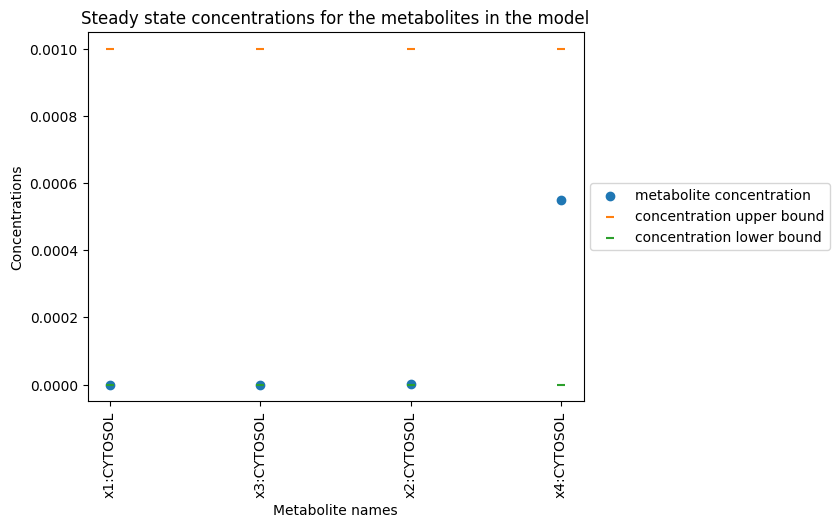

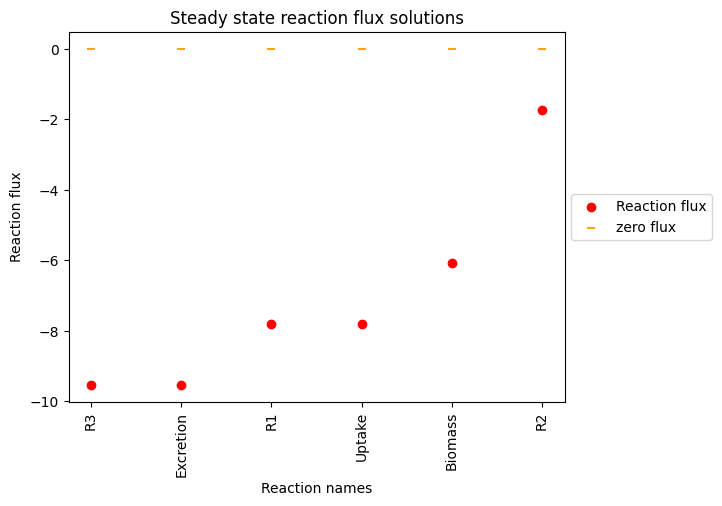

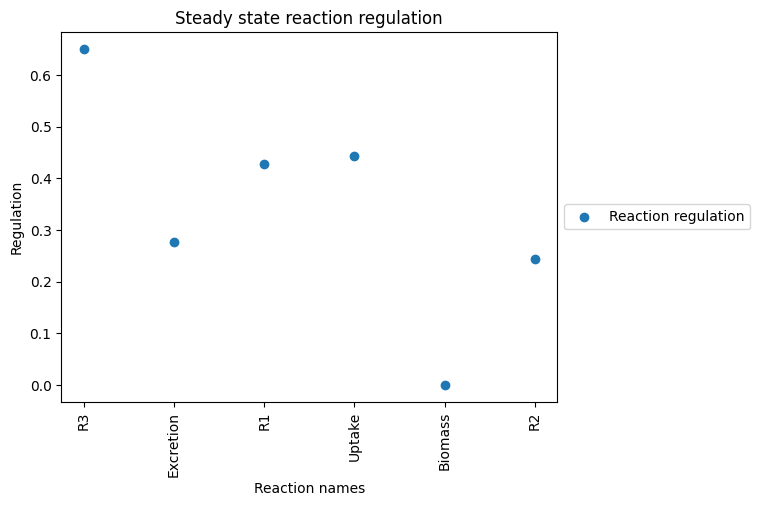

lowKModel_x1_e:ENVIRONMENT_1e-09_


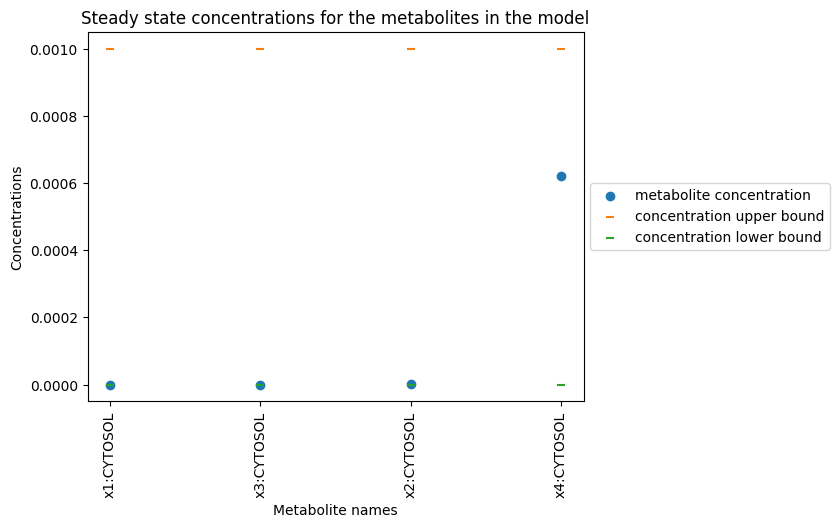

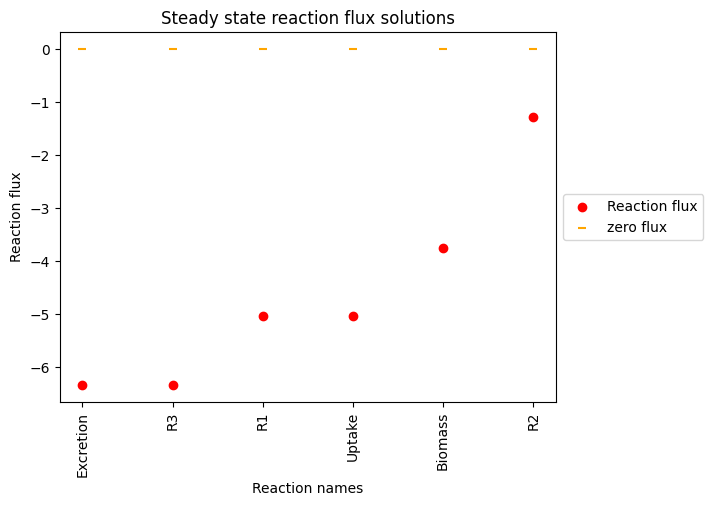

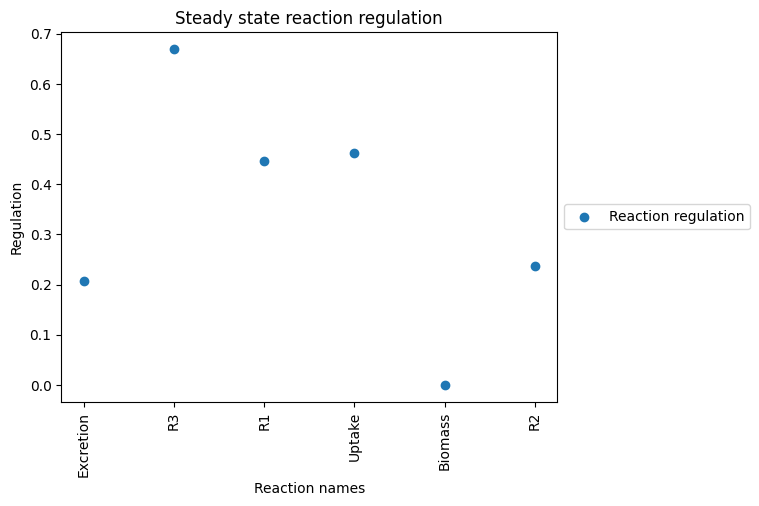

lowKModel_x1_e:ENVIRONMENT_1e-08_


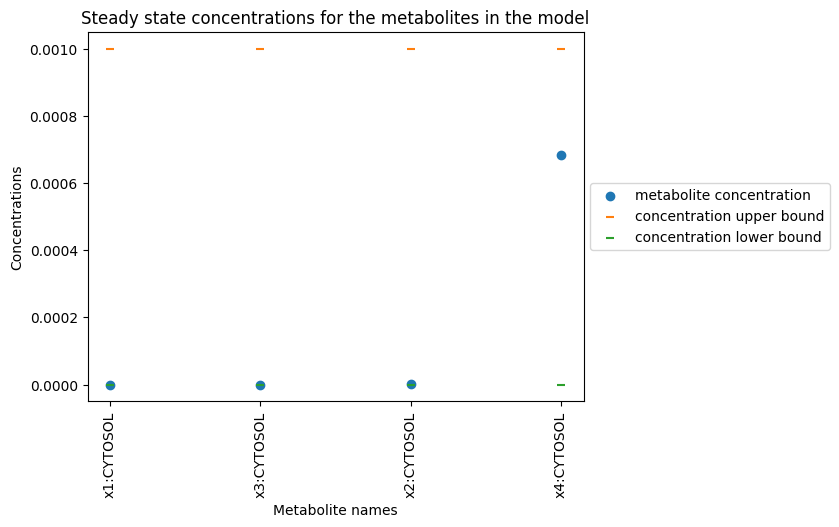

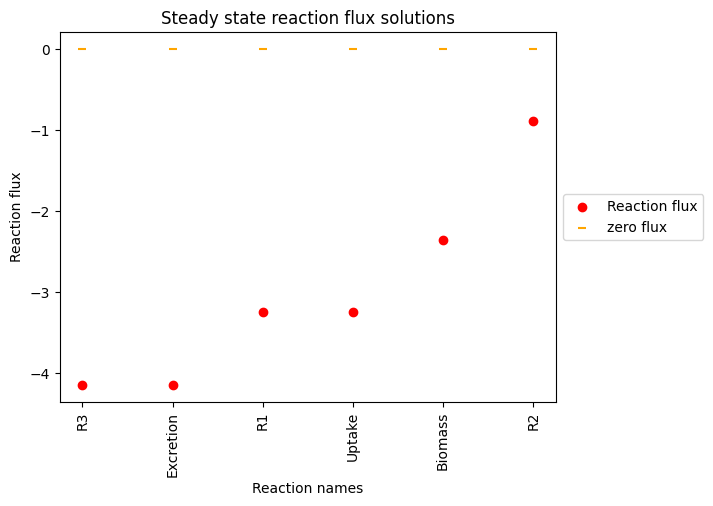

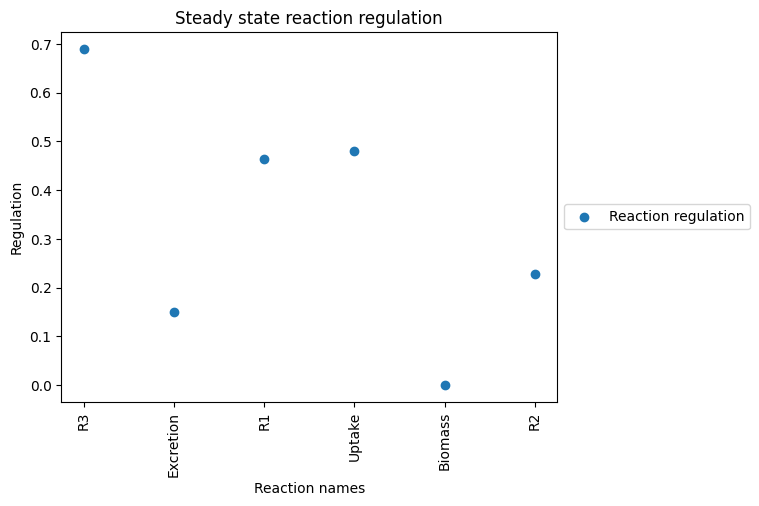

lowKModel_x1_e:ENVIRONMENT_1e-07_


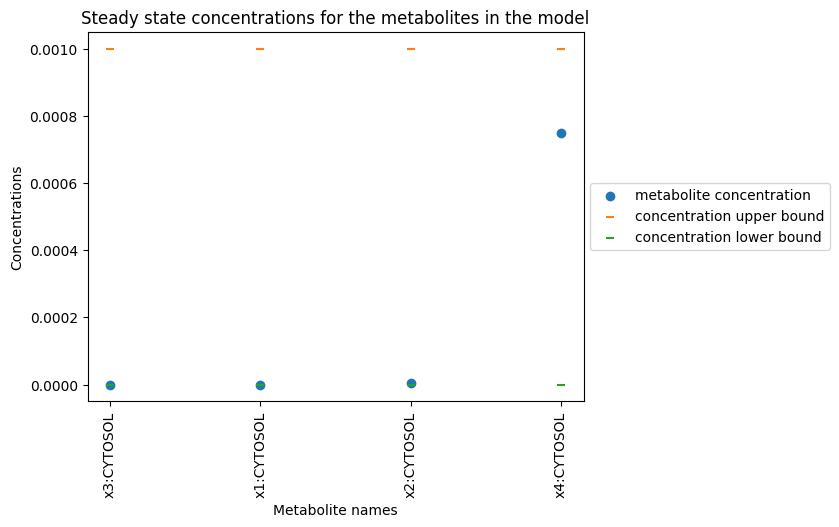

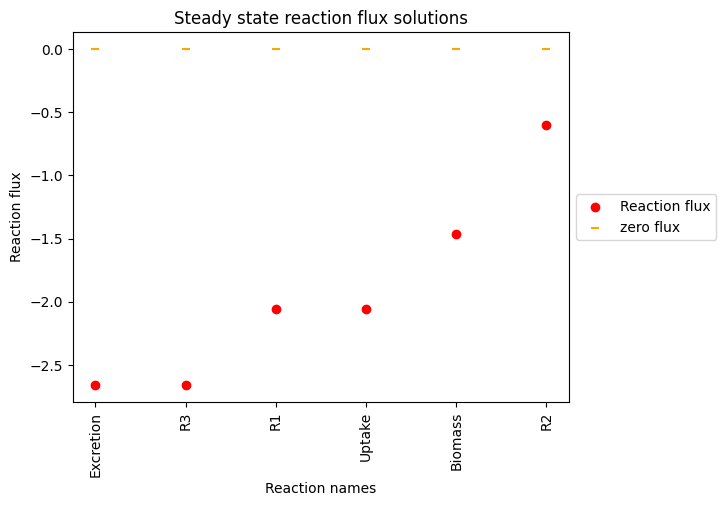

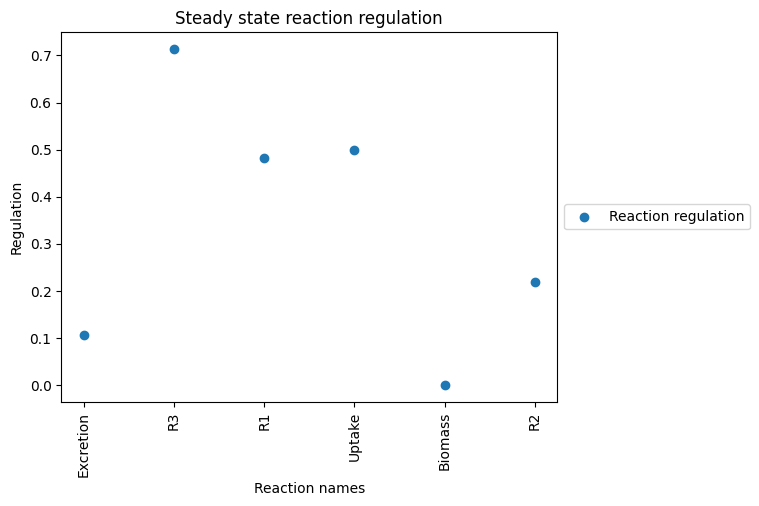

lowKModel_x1_e:ENVIRONMENT_1e-06_


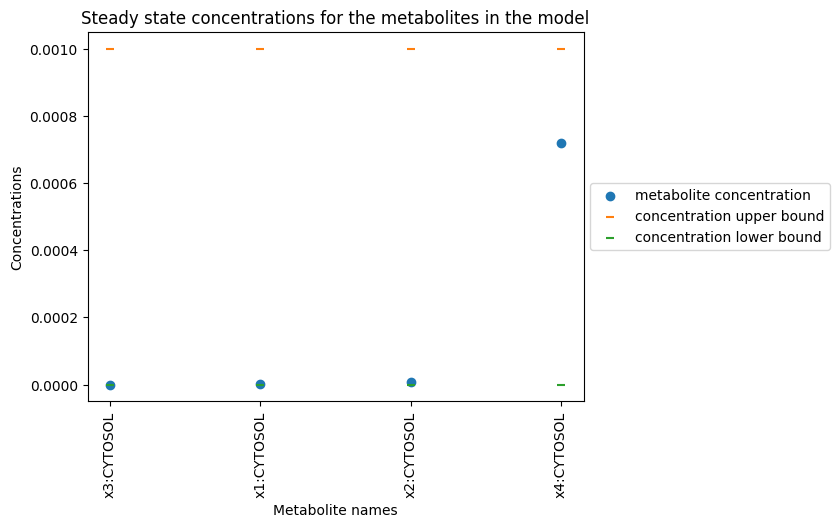

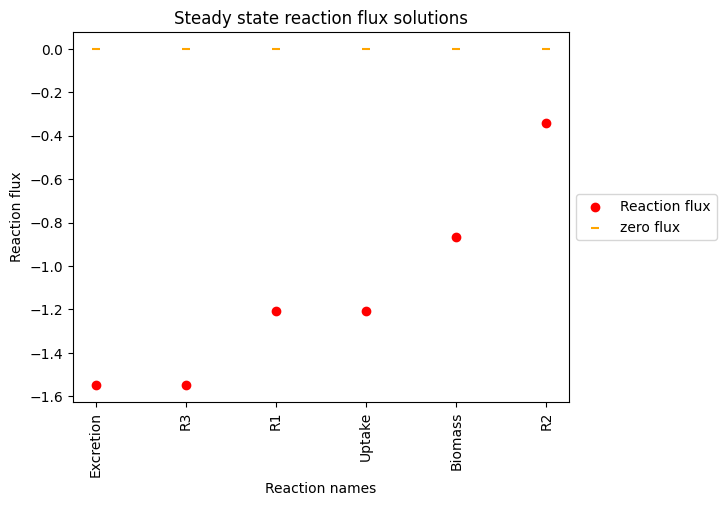

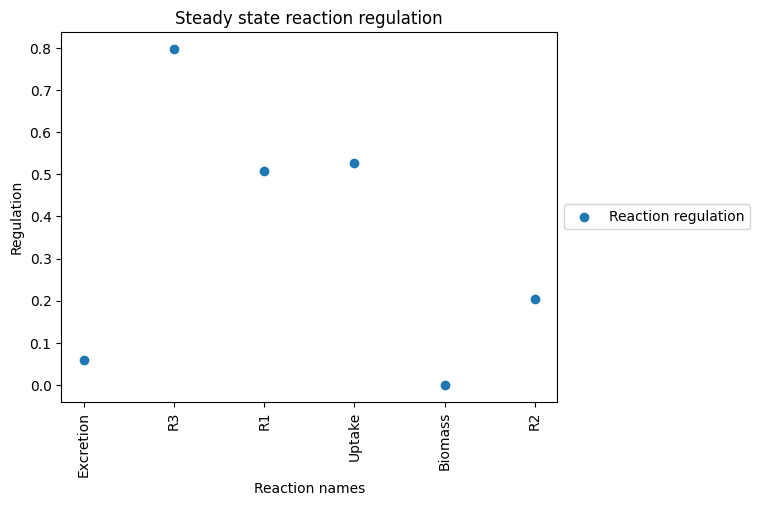

lowKModel_x1_e:ENVIRONMENT_1e-05_


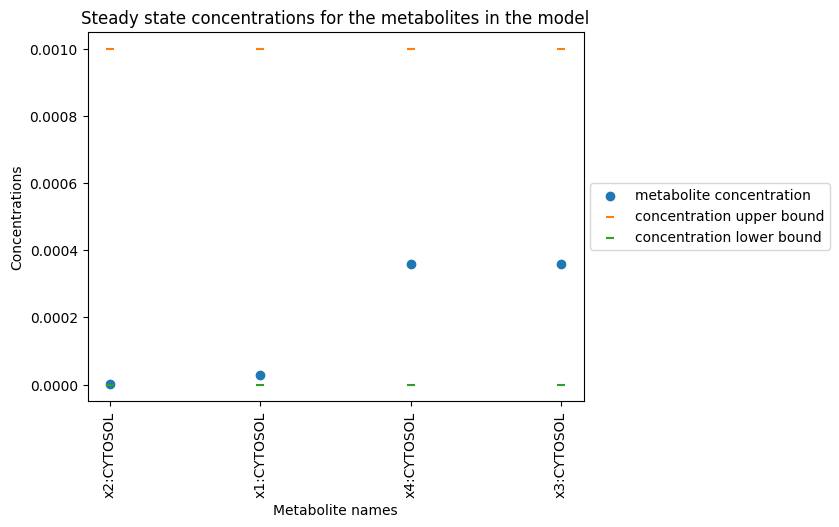

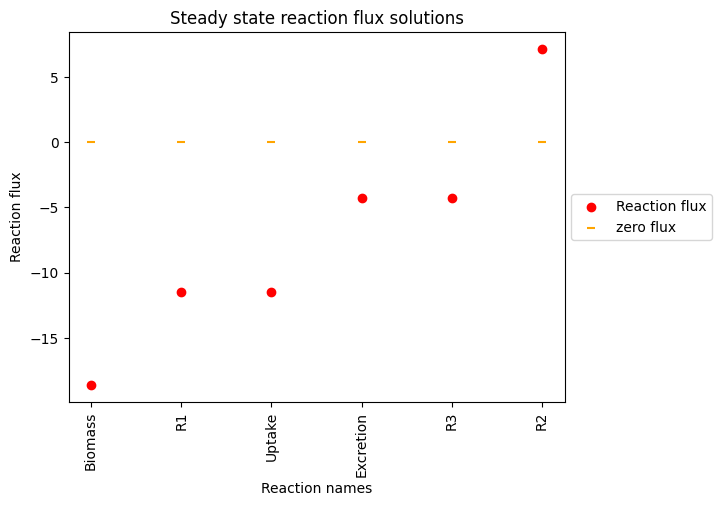

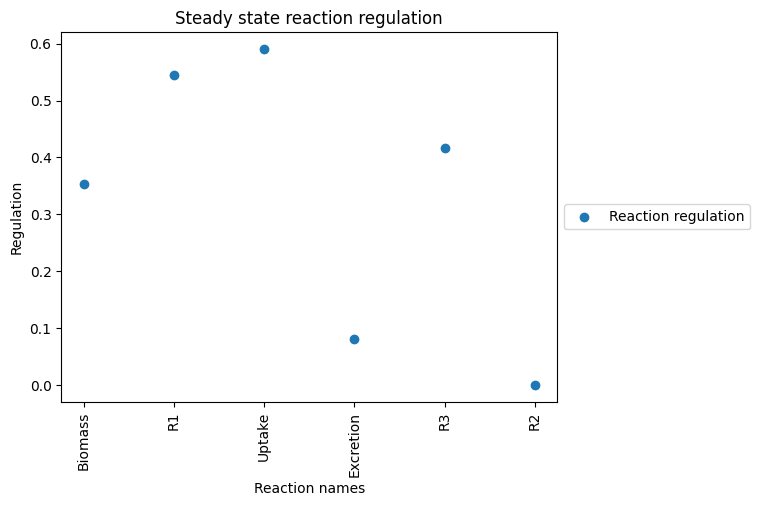

lowKModel_x1_e:ENVIRONMENT_0.0001_


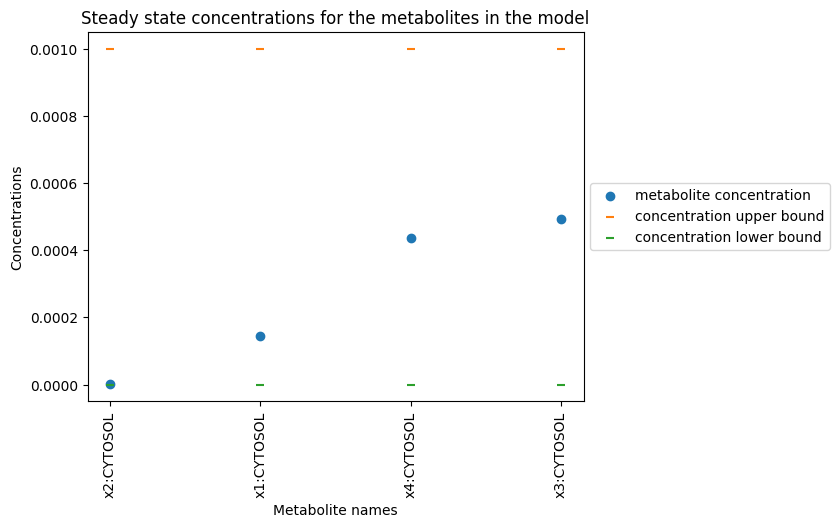

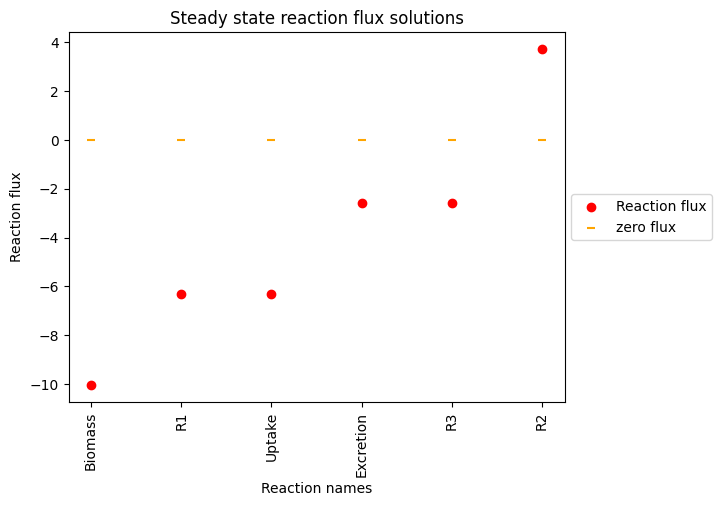

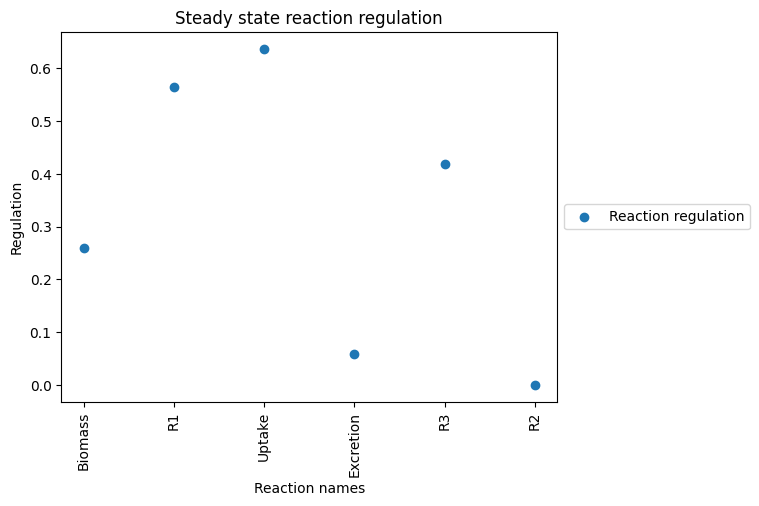

Concentrations:


,condition,x1:CYTOSOL,x2:CYTOSOL,x3:CYTOSOL,x4:CYTOSOL
0,1.000000e-10,2.544385e-10,8.402839e-07,2.613946e-09,0.000549
1,1.000000e-09,1.586298e-09,1.461269e-06,5.835527e-09,0.000620
2,1.000000e-08,9.971799e-09,2.494528e-06,1.347737e-08,0.000682
3,1.000000e-07,6.286299e-08,4.253442e-06,3.123837e-08,0.000750
4,1.000000e-06,3.841004e-07,6.870845e-06,7.226083e-08,0.000720
5,1.000000e-05,2.805510e-05,7.728791e-07,3.600332e-04,0.000357
6,1.000000e-04,1.443191e-04,1.560332e-06,4.912203e-04,0.000437


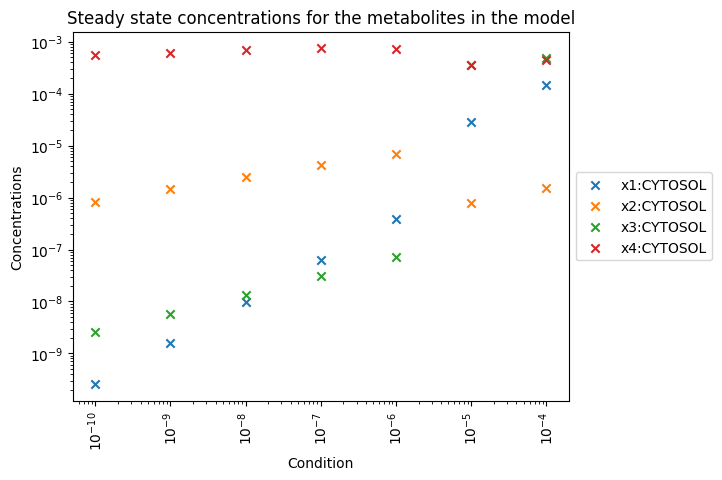

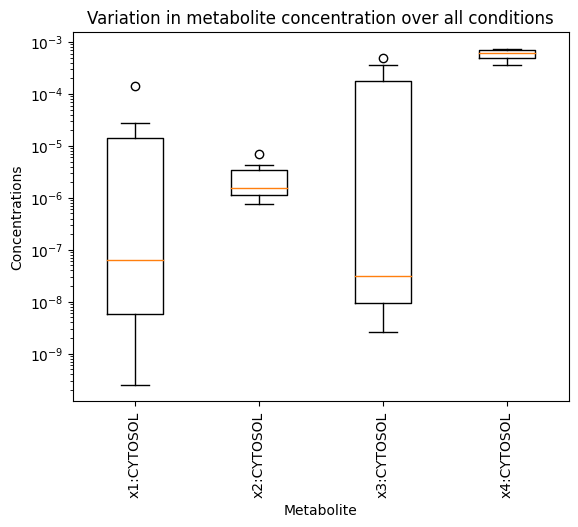

Flux:


,condition,R1,R2,R3,Uptake,Excretion,Biomass
0,1.000000e-10,-7.801569,-1.731246,-9.532815,-7.801569,-9.532815,-6.070323
1,1.000000e-09,-5.046482,-1.292116,-6.338597,-5.046482,-6.338597,-3.754366
2,1.000000e-08,-3.251019,-0.893566,-4.144585,-3.251019,-4.144585,-2.357453
3,1.000000e-07,-2.060347,-0.598112,-2.658459,-2.060347,-2.658459,-1.462235
4,1.000000e-06,-1.207099,-0.340852,-1.547951,-1.207099,-1.547951,-0.866247
5,1.000000e-05,-11.459512,7.148489,-4.311022,-11.459512,-4.311022,-18.608001
6,1.000000e-04,-6.306907,3.723657,-2.583250,-6.306907,-2.583250,-10.030565


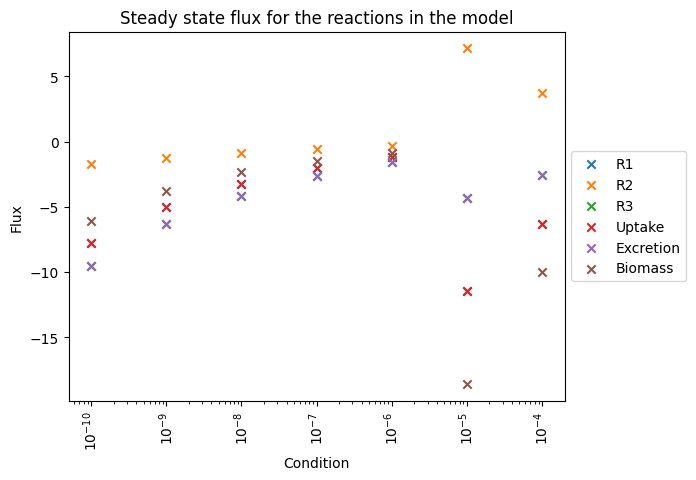

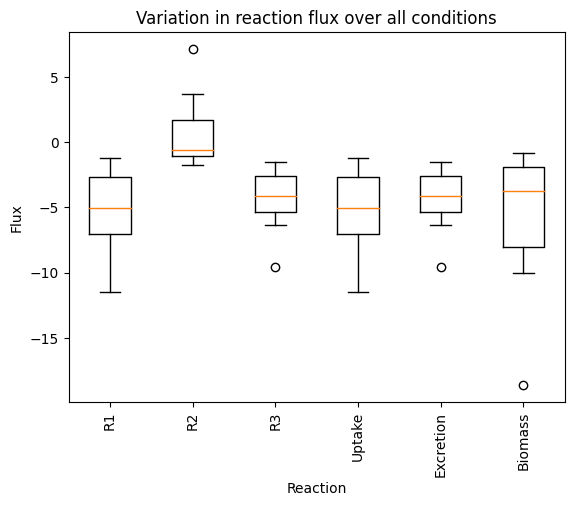

Regulation:


,condition,R1,R2,R3,Uptake,Excretion,Biomass
0,1.000000e-10,0.426855,0.243434,0.650207,0.443683,0.276372,8.375411e-07
1,1.000000e-09,0.445505,0.236209,0.669600,0.462685,0.207702,1.156417e-06
2,1.000000e-08,0.463127,0.227102,0.689887,0.480291,0.149488,1.677050e-06
3,1.000000e-07,0.483016,0.217885,0.713930,0.499010,0.105372,2.411034e-06
4,1.000000e-06,0.507062,0.203127,0.797539,0.527701,0.058930,3.304020e-06
5,1.000000e-05,0.545315,0.000346,0.417322,0.590717,0.081335,3.537504e-01
6,1.000000e-04,0.563662,0.000267,0.419347,0.636691,0.059639,2.602505e-01


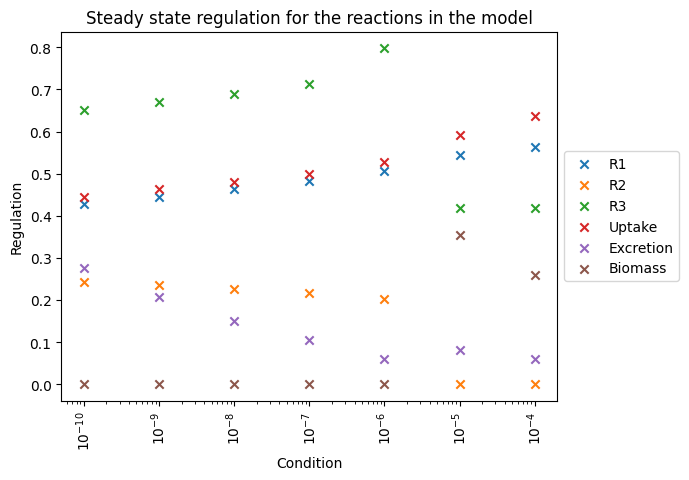

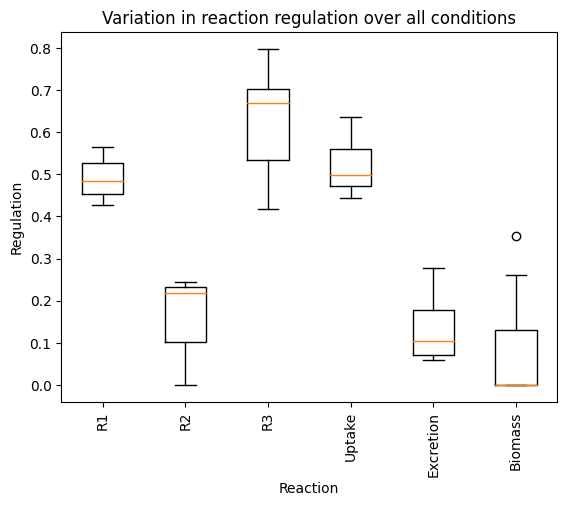

In [299]:
reload(anf)
conditionVector=[1e-10,1e-9,1e-8,1e-7,1e-6,1e-5,1e-4]
metaboliteSubset=['x1:CYTOSOL','x2:CYTOSOL','x3:CYTOSOL','x4:CYTOSOL']
reactionSubset=[]
concentrationdf =anf.PlotBestSimulations(bestSimulations,control_dictionary,metaboliteSubset,reactionSubset,conditionVector)

References:

    [1] "An approach to learn regulation to maximize growth and entropy production rates in metabolism", (2023), King, E. et al. Front. Syst. Biol., 3
    
    [2] "Acceleration Strategies to Enhance Metabolic Ensemble Modeling Performance", (2017), Greene, J. L. et al. Biophys J., 113